## MSDS 7331 Lab Three: Clustering

#### Authors: Jaren Shead, Kristin Henderson, Tom Hines

### Business Understanding

##### ***Describe the purpose of the data set you selected (i.e. why was this data collected in the first place?).***

The Diabetes 130-US Hospitals dataset includes over 100,000 hospital records from inpatients diagnosed with diabetes, collected across 130 U.S. hospitals between 1999 and 2008. It was originally created to support research into hospital readmissions, specifically to understand and predict whether patients would be readmitted within 30 days after discharge. The hope was to identify patterns that could help improve patient care, reduce complications, and lower hospital costs. Because the dataset covers a wide range of patient, treatment, and hospital-level factors, it’s also well-suited for exploring broader patterns of diabetic patient care during hospital stays.


##### ***How will you measure the effectiveness of a good algorithm?***

Because clustering is unsupervised, there’s no “ground truth” to compare against directly. We'll evaluate how well the clusters capture meaningful groupings in the data. One approach is to use internal validation metrics like silhouette scores or Adjusted Rand Index (ARI) (for comparing models), but we’ll also rely on visualizations, cluster size/distribution, and the interpretability of the groupings. For some models (like DBSCAN), we may also look at the percentage of noise points as an additional indicator.

In particular, we’ll use visualizations to examine whether the clusters differ on variables such as hospital resource use, admission source, referring practitioner, insurance type, and readmission outcome. We’ll also assess whether the clusters are reasonably sized, avoiding overly small or fragmented groups that may not be practically useful.

Eventually, we’ll also test whether these cluster assignments improve performance when used as features in downstream classification tasks, such as predicting readmission risk. If adding cluster labels helps those models, it suggests the clustering captured something meaningful.


##### ***Why does your chosen validation method make sense for this specific dataset and stakeholder needs?***

Using internal validation methods like silhouette scores and ARI provides one way to assess clustering quality, which is helpful given this dataset’s high dimensionality and mix of categorical and continuous variables. But for stakeholders, like hospital administrators, doctors, or policymakers, it's most important that the clusters reveal differences in patient types, care approaches, or resource needs.

Clusters that are hard to interpret aren’t likely to be useful, even if they score well on metrics. That’s why we’re combining internal metrics with graphics for visual assessment and evaluating whether the clusters help with later tasks, like improving classification models. This way, we’re not just aiming for technically good clusters, but ones that are actually helpful in practice.


#### Setup & Data Import

In [1]:
%pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Essential Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import re
import time
import warnings # Suppress sklearn OneHotEncoder warnings about unseen categories during transform
from textwrap import wrap
from pathlib import Path
from numpy.linalg import inv

# Machine Learning Libraries
import umap.umap_ as umap # From umap-learn (pip install umap-learn)
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, SGDClassifier, SGDRegressor, Lasso, LassoCV
from sklearn.svm import SVC, SVR, LinearSVR
from sklearn.decomposition import PCA
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBRegressor
from sklearn import metrics as mt
from sklearn.metrics import classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.experimental import enable_halving_search_cv  # Enable HalvingGridSearchCV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV
from scipy.stats import ttest_rel
from scipy.stats import skew, kurtosis, chi2
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multitest import multipletests

# Added for Clustering 
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE, trustworthiness
from scipy.cluster.hierarchy import linkage, dendrogram

# Display plots inline
%matplotlib inline

In [3]:
# Load dataset
NOTEBOOK_DIR = Path.cwd()
DATA_DIR = NOTEBOOK_DIR / "data"
df_path = DATA_DIR / "diabetic_data.csv"
df = pd.read_csv(df_path)

df.head()

encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)      ?   
1        149190     55629189        Caucasian  Female  [10-20)      ?   
2         64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3        500364     82442376        Caucasian    Male  [30-40)      ?   
4         16680     42519267        Caucasian    Male  [40-50)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital  ... citoglipton insulin  glyburide-metformin  \
0                 1  ...          No      No                   No   
1                 3  ...          No      Up                   No   
2                 2  ...          No      No                   No   
3                 2  ...          No      Up                   No   
4                 1  ...          No  Steady                   No   

   glipizide-metformin  glimepiride-pioglitazone  metformin-rosiglitazone  \
0                   No                        No                       No   
1                   No                        No                       No   
2                   No                        No                       No   
3                   No                        No                       No   
4                   No                        No                       No   

   metformin-pioglitazone  change diabetesMed readmitted  
0                      No      No          No         NO  
1                      No      Ch         Yes        >30  
2                      No      No         Yes         NO  
3                      No      Ch         Yes         NO  
4                      No      Ch         Yes         NO  

[5 rows x 50 columns]

### Data Understanding

##### ***Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file.***

The dataset includes over 100,000 records of diabetic inpatient encounters, with a mix of categorical, ordinal, and continuous variables. Attributes fall into these general categories:

- **Demographics**: Categorical variables such as race, gender, and age (in 10-year intervals).
- **Hospital details**: Admission type, discharge disposition, and admission source (numeric codes mapped to categories).
- **Clinical features**: Continuous counts of lab procedures, medications, and prior hospital visits.
- **Diagnostics**: ICD-9 diagnosis codes (`diag_1`, `diag_2`, `diag_3`) recorded as strings (integer values).
- **Lab results**: Categorical (e.g., `A1Cresult`, `max_glu_serum`) with ordinal levels (e.g. Untested, Normal, Above Normal, High).
- **Medications**: 22 variables indicating drug use and dosage changes (ordinal: No, Down, Steady, Up).
- **Outcomes**: The target variable `readmitted` is ordinal with three classes: `<30`, `>30`, and `NO`.

#### Data Cleaning & Preprocessing

We perform basic preprocessing:
- Replace placeholder missing values with `NaN`
- Fill missing categorical values with 'Unknown' or appropriate labels
- Drop irrelevant columns
- Convert numeric categorical columns to strings
- Set appropriate category orders for ordinal features like `age`, `readmitted`, and `A1Cresult`
- Preprocess drug usage and diagnostic codes

In [4]:
### Make a copy of the dataset
df_clean = df.copy()

# Replace '?' with NaN
df_clean.replace('?', np.nan, inplace=True)

# Fill missing values
df_clean[['medical_specialty', 'payer_code', 'race']] = df_clean[['medical_specialty', 'payer_code', 'race']].fillna('Unknown')
df_clean[['diag_1', 'diag_2', 'diag_3']] = df_clean[['diag_1', 'diag_2', 'diag_3']].fillna('Unknown/None')
df_clean[['max_glu_serum', 'A1Cresult']] = df_clean[['max_glu_serum', 'A1Cresult']].fillna('Untested')

# Convert numeric categorical columns to strings explicitly (not category yet)
numeric_categorical_cols = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']
df_clean[numeric_categorical_cols] = df_clean[numeric_categorical_cols].astype(str)

# Drop unnecessary columns
df_clean.drop(columns=['encounter_id', 'examide', 'citoglipton', 'weight', 'patient_nbr'], inplace=True)

# Define ordinal category orders
category_orders = {
    'readmitted': ['<30', '>30', 'NO'],
    'max_glu_serum': ['Untested', 'Norm', '>200', '>300'],
    'A1Cresult': ['Untested', 'Norm', '>7', '>8'],
    'age': ['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)',
            '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)']
}

# Convert ordinal variables
for col, order in category_orders.items():
    df_clean[col] = pd.Categorical(df_clean[col], categories=order, ordered=True)

# Convert drug variables to ordinal categories
drug_order = ['No', 'Down', 'Steady', 'Up']
drug_cols = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 
                'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'tolazamide', 
                'pioglitazone', 'rosiglitazone', 'troglitazone', 'acarbose', 'miglitol', 
                'insulin', 'glyburide-metformin', 'glipizide-metformin',
                'metformin-rosiglitazone', 'metformin-pioglitazone', 'glimepiride-pioglitazone']
for col in drug_cols:
    df_clean[col] = pd.Categorical(df_clean[col], categories=drug_order, ordered=True)

# Preprocess diag_1, diag_2, diag_3 combining all codes with decimals under their integer values
for col in ['diag_1', 'diag_2', 'diag_3']:
    df_clean[col] = df_clean[col].str.split('.').str[0]  # Drop decimals and digits after

df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 45 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   race                      101766 non-null  object  
 1   gender                    101766 non-null  object  
 2   age                       101766 non-null  category
 3   admission_type_id         101766 non-null  object  
 4   discharge_disposition_id  101766 non-null  object  
 5   admission_source_id       101766 non-null  object  
 6   time_in_hospital          101766 non-null  int64   
 7   payer_code                101766 non-null  object  
 8   medical_specialty         101766 non-null  object  
 9   num_lab_procedures        101766 non-null  int64   
 10  num_procedures            101766 non-null  int64   
 11  num_medications           101766 non-null  int64   
 12  number_outpatient         101766 non-null  int64   
 13  number_emergency          101

##### ***Verify data quality: Are there missing values? Duplicate data? Outliers? Are those mistakes? How do you deal with these problems?***

The dataset contained no duplicate records. Missing values appeared in variables such as `race`, `payer_code`, and `medical_specialty`, which we filled using the placeholder "Unknown" to retain records while acknowledging the gaps. Diagnosis codes (`diag_1`, `diag_2`, `diag_3`) were cleaned by removing decimals and filling missing values with "Unknown/None". Lab test results were standardized to include an "Untested" category.

We removed ID columns (e.g. `encounter_id`, `patient_nbr`) and fields with no variance (i.e. `examide` and `citoglipton`) or a high proportion (> 95%) of missing values (i.e. `weight`).

Outliers were assessed using the IQR method. Several hospital visit variables (`number_outpatient`, `number_emergency`, `number_inpatient`) had a high percentage of extreme values (5%+), often reflecting a small group of patients with repeated visits. These variables showed right-skewed distributions with low medians and long upper tails. Other numeric features like `num_medications` also displayed heavy-tailed distributions. Rather than removing these records outright, we noted the potential importance of these outliers, they may indicate complex or high-risk patient cases.

#### Visualization of Important Variables

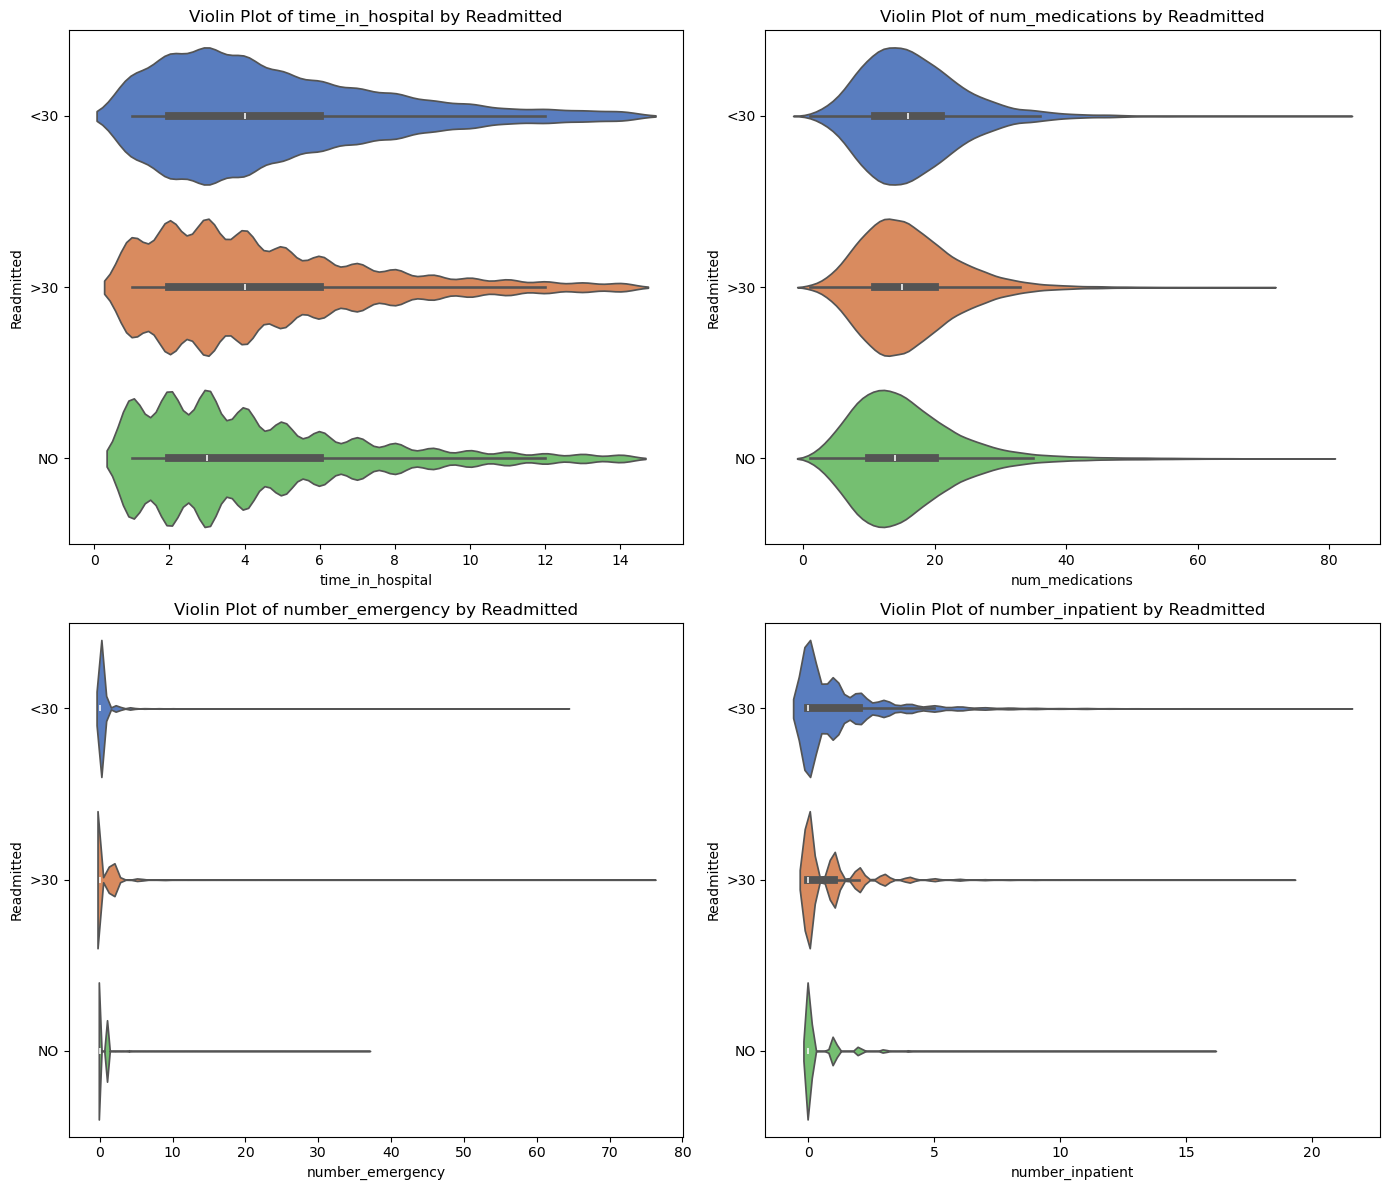

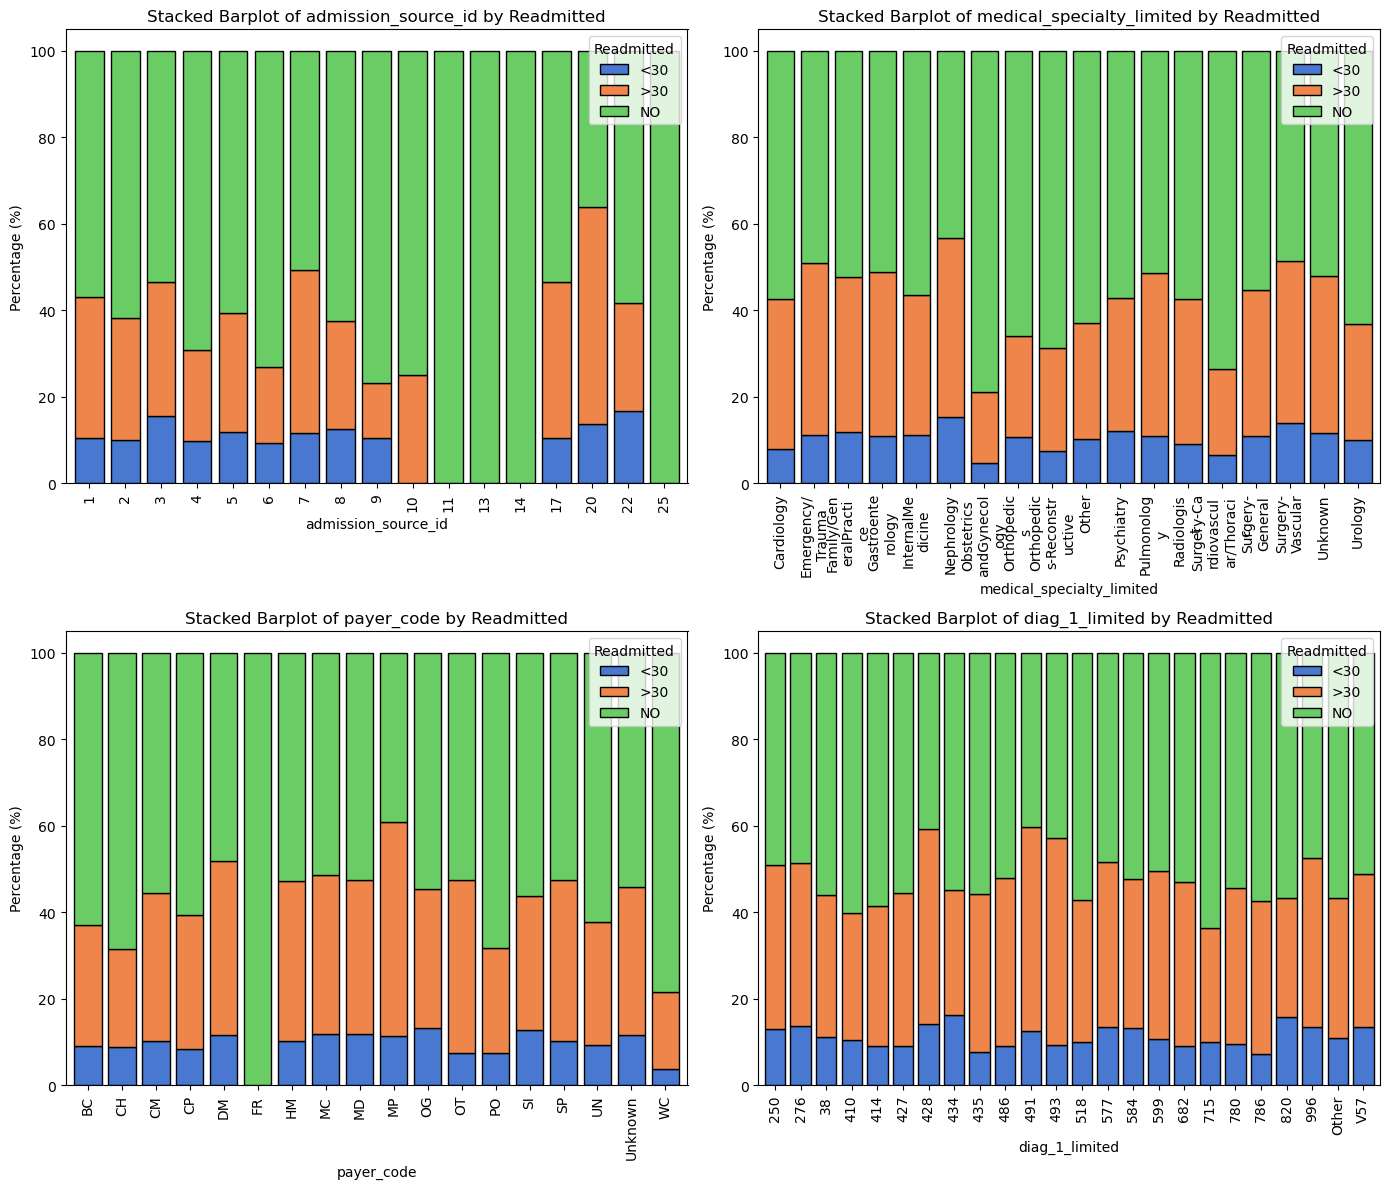

In [5]:
df_plotting = df_clean.copy()

# Filter admission_source_id, medical specialty, and diag_1 to include only categories with more than 500 or 1000 occurrences
# adm_src_top_values = df_plotting['admission_source_id'].value_counts()
# adm_src_top_values = adm_src_top_values[adm_src_top_values > 200].index
# df_plotting['admission_source_id_limited'] = df_plotting['admission_source_id'].where(df_plotting['admission_source_id'].isin(adm_src_top_values), other='Other')
med_spec_top_values = df_plotting['medical_specialty'].value_counts()
med_spec_top_values = med_spec_top_values[med_spec_top_values > 500].index
df_plotting['medical_specialty_limited'] = df_plotting['medical_specialty'].where(df_plotting['medical_specialty'].isin(med_spec_top_values), other='Other')
diag_1_top_values = df_plotting['diag_1'].value_counts()
diag_1_top_values = diag_1_top_values[diag_1_top_values > 1000].index
df_plotting['diag_1_limited'] = df_plotting['diag_1'].where(df_plotting['diag_1'].isin(diag_1_top_values), other='Other')

# Define numeric and categorical variables
numVar = ['time_in_hospital', 'num_medications', 'number_emergency', 'number_inpatient']
catVar = ['admission_source_id', 'medical_specialty_limited', 'payer_code', 'diag_1_limited']

# Violin Plots for Numeric Variables in Two Columns
ncols = 2  # Number of columns in the grid
nrows = -(-len(numVar) // ncols)  # Calculate the number of rows needed (ceiling division)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 6 * nrows))  # Adjust size for clarity
axes = axes.flatten()  # Flatten axes for easier indexing if nrows * ncols > len(numVar)

for i, var in enumerate(numVar):
    ax = axes[i]  # Get the appropriate subplot axis
    sns.violinplot(
        data=df_plotting, 
        x=var, 
        y='readmitted', 
        hue = 'readmitted',
        # order=readmit_order,
        palette='muted', 
        ax=ax
    )
    ax.set_title(f'Violin Plot of {var} by Readmitted')
    ax.set_xlabel(var)
    ax.set_ylabel('Readmitted')

# Hide any unused subplots
for j in range(len(numVar), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
# plt.savefig(f'plots/grouped_violinplots.png')
plt.show()

# Stacked Barplots for Categorical Variables in Two Columns
ncols = 2  # Number of columns in the grid
nrows = -(-len(catVar) // ncols)  # Calculate the number of rows needed (ceiling division)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 6 * nrows))
axes = axes.flatten()  # Flatten axes for easier indexing if nrows * ncols > len(catVar)

for i, var in enumerate(catVar):
    ax = axes[i]  # Get the appropriate subplot axis
    # Calculate proportions of response classes within each level of the categorical variable
    grouped_counts = (
        df_plotting.groupby(var, observed=True)['readmitted']
        .value_counts(normalize=True)
        .unstack(fill_value=0) * 100
    )
    # Sort admission_source_id numerically
    if var == 'admission_source_id':
        grouped_counts = grouped_counts.sort_index(key=lambda x: x.astype(int))
    # Plot stacked barplot
    # grouped_counts[readmit_order].plot(
    grouped_counts.plot(    
        kind='bar', 
        stacked=True, 
        ax=ax, 
        color=sns.color_palette("muted"), 
        edgecolor='black',
        width=0.8
    )
    ax.set_title(f'Stacked Barplot of {var} by Readmitted')
    ax.set_xlabel(var)
    ax.set_ylabel('Percentage (%)')
    ax.legend(title='Readmitted', loc='upper right')
    ax.tick_params(axis='x', rotation=0)  # Prevent rotation here for cleaner wrapping

    # Dynamically fetch and wrap the x-tick labels
    labels = [ '\n'.join(wrap(label, 10)) for label in grouped_counts.index.astype(str)]
    ax.set_xticks(range(len(labels)))  # Ensure tick positions match
    ax.set_xticklabels(labels, rotation=90)  # Apply wrapped labels

# Hide any unused subplots
for j in range(len(catVar), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
# plt.savefig(f'plots/stacked_barplots.png')
plt.show()

##### ***Visualize any important attributes appropriately. Provide an interpretation for any charts or graphs.***

We used a variety of plots during EDA, including violin plots, histograms, boxplots, stacked bar plots, pairplots, correlation matrices, and cross-tabulations, to explore patterns across numeric and categorical variables.

**Observations from These Plots and EDA Visualizations:**

- **Hospital Visit Metrics**: Variables like `number_emergency` and `number_inpatient` show right-skewed distributions with extreme values. Violin plots suggest that early and late readmitted patients have broader and higher visit counts than non-readmitted patients. These trends support clustering based on system usage patterns.

- **Resource Usage**: `time_in_hospital` and `num_medications` display overlapping but slightly shifted distributions across readmission classes. Early readmitted patients tend to have longer stays and more medications. These subtle trends suggest resource intensity may influence readmission likelihood.

- **Care Context Variables**: Stacked bar plots show differences in readmission proportions across levels of `admission_source_id`, `medical_specialty`, and `payer_code`. Some categories (e.g. nephrology) have higher early readmission rates while others had lower non-readmission rates (e.g. admission_source 20 and MP), indicating administrative context may play a role in patient outcomes.

- **Diagnosis Codes**: Among common values of `diag_1`, we observed variation in readmission class proportions. Some diagnoses (e.g. 434 and 820) had higher early readmission rates, while others (e.g. 435 and 786) had fewer early readmissions.

- **Drug Variables**: While many medications were imbalanced (i.e. most patients weren’t prescribed them), we saw variation in readmission rates across drug usage levels. Insulin and metformin were common; some drug combinations and change indicators (e.g. `diabetesMed`, `change`) also showed class differences.

- **Pairplots and Correlations**: There were no strong linear relationships between numeric variables. `num_medications` is moderately correlated with `time_in_hospital` and `num_procedures`, but overall multicollinearity is low. Most numeric variables show skew and clusters of low values.

**Summary**:  
While no single variable provides perfect class separation, the plots reveal structure in the data that is promising for clustering. Patterns in hospital resource use, admission context, and diagnosis groupings suggest the potential to form meaningful patient subgroups with differing readmission risks and care profiles.

### Clustering Strategy Overview

To uncover meaningful patient subgroups, we explore clustering in two main areas:

1. **Hospital Resource Usage:**  
   - Features: length of stay, number of procedures/lab procedures/medications, outpatient/emergency/inpatient visits  
   - Goal: Identify patient groups with differing levels of system use.

2. **Care Context (Administrative) Variables:**  
   - Features: admission source, medical specialty, payer code  
   - Goal: Explore whether admission context and insurer affects care or outcomes.

For each group, we apply:
- KMeans (and MiniBatch variant)
- DBSCAN
- Hierarchical Agglomerative Clustering (HAC)

We compare clustering results using:
- Silhouette scores
- Adjusted Rand Index (ARI)
- PCA-based visualizations

Cluster assignments may later be used as features in classification tasks (e.g. predicting early readmission).

Additional clustering routes to explore could be:
- Demographics (age, race, gender) to understand patient groups by basic traits
- Medications (all drug columns, insulin, diabetesMed, change) to group by treatment regimen (medication-heavy vs. medication-light treatment strategies)
- Diagnoses (diag_1, diag_2, diag_3) to group based on common clinical patterns
- Outcome (readmitted and discharge_disposition_id) to cluster patients with similar outcomes

### Clustering Based on Hospital Resource Usage

We begin by clustering patients using healthcare usage features:

- `time_in_hospital`
- `num_lab_procedures`
- `num_procedures`
- `num_medications`
- `number_outpatient`
- `number_emergency`
- `number_inpatient`

We also test adding patient age for added context.

This can help identify high vs. low users, which may provide insight for treatment intensity and cost.

### Data Preparation

#### Feature Engineering: Resource Variables

We create two datasets:
1. Resource Only – core resource usage features
2. Resource + Age – same as above, plus age using range midpoints to preserve ordinal information

In [6]:
# Copy the dataset
df_clustered = df_clean.copy()

# Select the feature set
resource_features = [
    'time_in_hospital', 'num_lab_procedures', 'num_procedures',
    'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient'
]

# Convert 'age' from range to midpoint integer to retain the ordinal nature rather than one-hot encoding
age_map = {
    '[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35,
    '[40-50)': 45, '[50-60)': 55, '[60-70)': 65,
    '[70-80)': 75, '[80-90)': 85, '[90-100)': 95
}
df_clustered['age_numeric'] = df_clustered['age'].map(age_map)

# Build the datasets
# Dataset 1: resource use only
X_resource_only = df_clustered[resource_features].copy()
# Dataset 2: resource use + age
X_resource_age = df_clustered[resource_features + ['age_numeric']].copy()

#### Feature Scaling

All selected variables are numeric but on different scales.  
We use `StandardScaler` to standardize features before clustering.

In [7]:
# Scale the data
scaler = StandardScaler()
X_resource_scaled = scaler.fit_transform(X_resource_only)
X_resource_age_scaled = scaler.fit_transform(X_resource_age)

### Modeling and Evaluation

#### KMeans: Optimal Cluster Selection

To figure out the most appropriate number of clusters, we use two internal evaluation methods to choose a $k$ that balances both metrics:

- Elbow Method – evaluates how compact the clusters by using inertia or within-cluster sum of squared errors (SSE), the distance of each point to its cluster center 
- Silhouette Score – measures how well-separated the clusters are by comparing the distance of each point to its own cluster vs. the nearest neighboring cluster


Running KMeans for: Resource Only
Resource Only - Time: 7.20 minutes

Running KMeans for: Resource + Age
Resource + Age - Time: 7.11 minutes


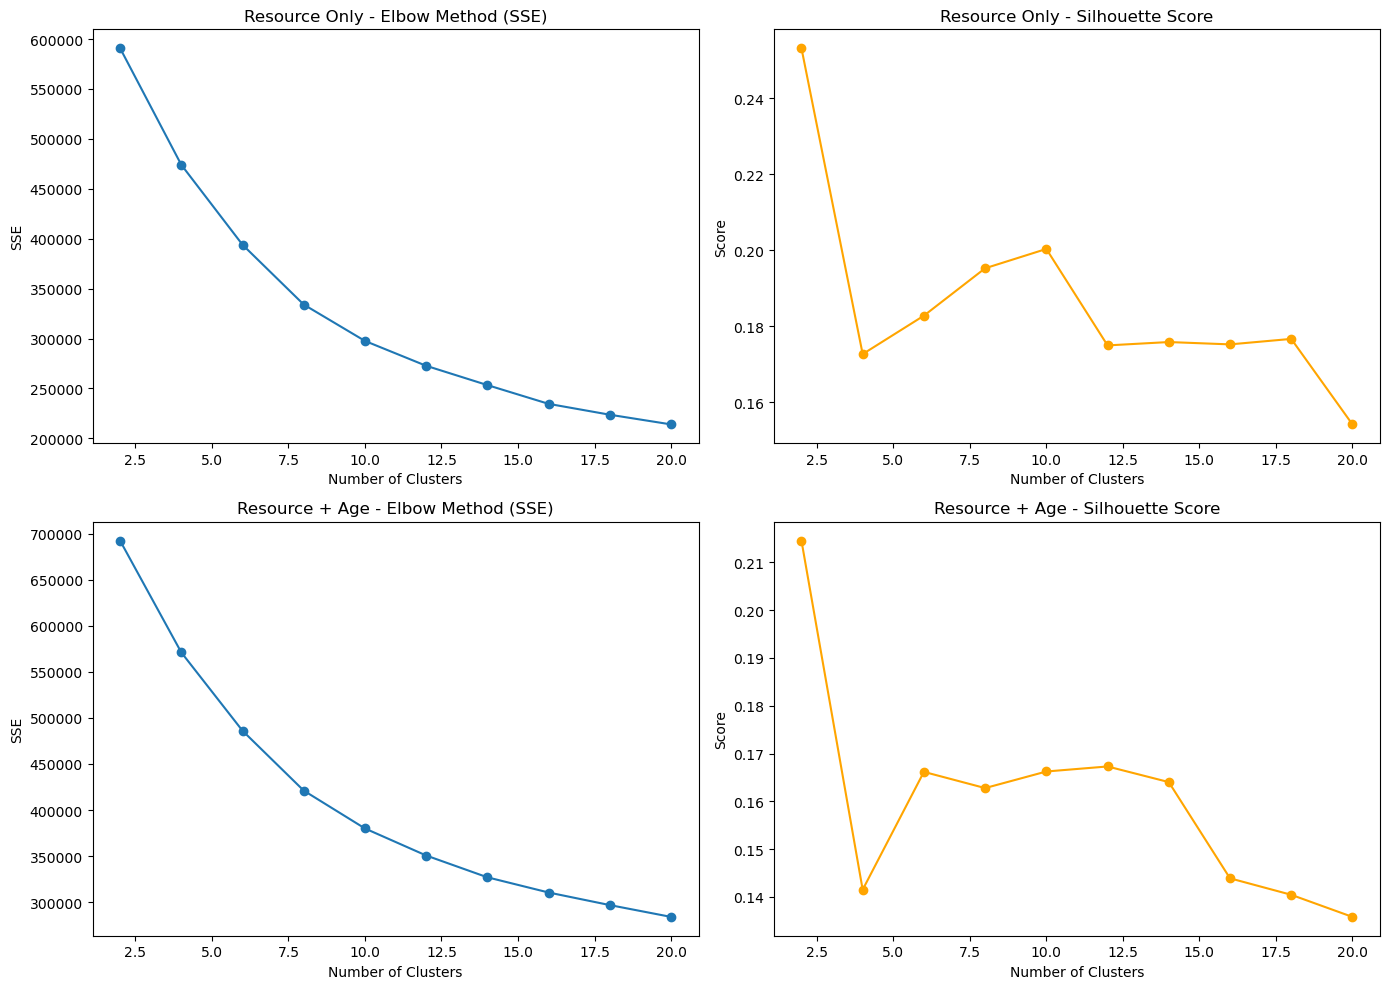

In [8]:
# Use an elbow plot and silhouette score to find the best number of clusters

# Two datasets to compare
datasets = {
    'Resource Only': X_resource_scaled,
    'Resource + Age': X_resource_age_scaled
}

# Store results
results = {}

K_range = range(2, 21, 2)

for name, X in datasets.items():
    sse = []
    sil_scores = []
    print(f"\nRunning KMeans for: {name}")

    start_time = time.time()
    for k in K_range:
        kmeans = KMeans(
            init='k-means++',
            n_clusters=k,
            n_init=5,
            random_state=1234
        )
        labels = kmeans.fit_predict(X)
        sse.append(kmeans.inertia_)
        sil_scores.append(silhouette_score(X, labels))
    
    elapsed = (time.time() - start_time)/60
    print(f"{name} - Time: {elapsed:.2f} minutes")
    
    results[name] = {'sse': sse, 'silhouette': sil_scores}

# Plot results side-by-side
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for i, (name, res) in enumerate(results.items()):
    axes[i][0].plot(K_range, res['sse'], marker='o')
    axes[i][0].set_title(f'{name} - Elbow Method (SSE)')
    axes[i][0].set_xlabel('Number of Clusters')
    axes[i][0].set_ylabel('SSE')

    axes[i][1].plot(K_range, res['silhouette'], marker='o', color='orange')
    axes[i][1].set_title(f'{name} - Silhouette Score')
    axes[i][1].set_xlabel('Number of Clusters')
    axes[i][1].set_ylabel('Score')

plt.tight_layout()
plt.show()


Running KMeans for: Resource Only
Resource Only - Time: 3.45 minutes

Running KMeans for: Resource + Age
Resource + Age - Time: 3.34 minutes


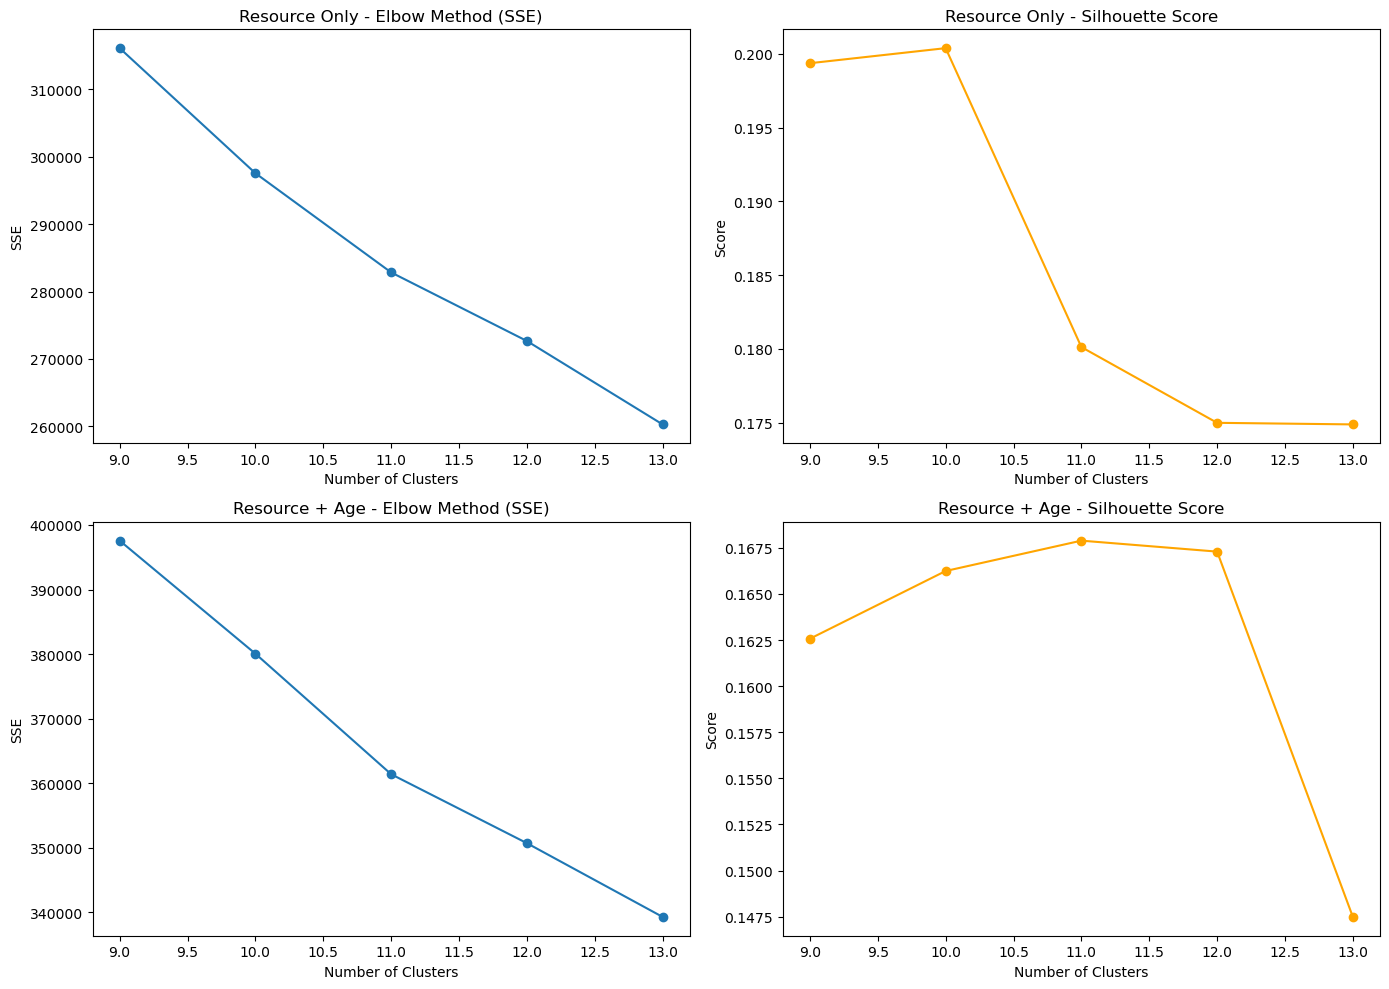

In [9]:
# Use an elbow plot and silhouette score to find the best number of clusters

# Two datasets to compare
datasets = {
    'Resource Only': X_resource_scaled,
    'Resource + Age': X_resource_age_scaled
}

# Store results
results = {}

K_range = range(9, 14)

for name, X in datasets.items():
    sse = []
    sil_scores = []
    print(f"\nRunning KMeans for: {name}")

    start_time = time.time()
    for k in K_range:
        kmeans = KMeans(
            init='k-means++',
            n_clusters=k,
            n_init=5,
            random_state=1234
        )
        labels = kmeans.fit_predict(X)
        sse.append(kmeans.inertia_)
        sil_scores.append(silhouette_score(X, labels))

    elapsed = (time.time() - start_time)/60
    print(f"{name} - Time: {elapsed:.2f} minutes")
    
    results[name] = {'sse': sse, 'silhouette': sil_scores}

# Plot results side-by-side
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for i, (name, res) in enumerate(results.items()):
    axes[i][0].plot(K_range, res['sse'], marker='o')
    axes[i][0].set_title(f'{name} - Elbow Method (SSE)')
    axes[i][0].set_xlabel('Number of Clusters')
    axes[i][0].set_ylabel('SSE')

    axes[i][1].plot(K_range, res['silhouette'], marker='o', color='orange')
    axes[i][1].set_title(f'{name} - Silhouette Score')
    axes[i][1].set_xlabel('Number of Clusters')
    axes[i][1].set_ylabel('Score')

plt.tight_layout()
plt.show()

We initially test a wide range of clusters (k = 2 to 20), then focus on a narrower range (k = 9 to 13) based on preliminary findings.

Observations:
- The Elbow plot shows diminishing returns after k = 10–11 clusters.
- Silhouette scores generally decline after k = 10, especially for the Resource-Only dataset.
- For consistency and simplicity, we choose k = 10 for both datasets.

#### Compare K-Means and Mini-Batch K-Means:

- PCA plots help us visualize the clusters in 2D, so we can get a sense of their shape and separation.
- We use Silhouette Scores to see how well-defined the clusters are.
- Adjusted Rand Index (ARI) gives us a sense of how similar the groupings are between the two methods. A value of 1 means perfect agreement between the methods and 0 means no better than random chance.

In [10]:
# Compare Batch K-Means to Mini-Batch K-Means for both datasets

k = 10

clustering_results = {}

for name, X in datasets.items(): # datasets was created above
    print(f"\n--- Clustering comparison for: {name} ---")

    # Fit KMeans
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=1234)
    kmeans_labels = kmeans.fit_predict(X)

    # Fit MiniBatchKMeans
    mbk = MiniBatchKMeans(n_clusters=k, batch_size=512, n_init=10, random_state=1234)
    mbk_labels = mbk.fit_predict(X)

    # Store everything
    clustering_results[name] = {
        'X': X,
        'kmeans_labels': kmeans_labels,
        'mbk_labels': mbk_labels,
        'silhouette_kmeans': silhouette_score(X, kmeans_labels),
        'silhouette_mbk': silhouette_score(X, mbk_labels),
        'ari': adjusted_rand_score(kmeans_labels, mbk_labels)
    }

    print(f"KMeans silhouette score:        {clustering_results[name]['silhouette_kmeans']:.4f}")
    print(f"MiniBatchKMeans silhouette score: {clustering_results[name]['silhouette_mbk']:.4f}")
    print(f"Adjusted Rand Index (agreement): {clustering_results[name]['ari']:.4f}")


--- Clustering comparison for: Resource Only ---
KMeans silhouette score:        0.2004
MiniBatchKMeans silhouette score: 0.1791
Adjusted Rand Index (agreement): 0.5803

--- Clustering comparison for: Resource + Age ---
KMeans silhouette score:        0.1648
MiniBatchKMeans silhouette score: 0.1421
Adjusted Rand Index (agreement): 0.5632


Interpretation:
- Moderate ARI values suggest some similarity in groupings for both datasets.
- Including age slightly lowered overall silhouette scores in both methods, suggesting age may not improve separation.
- K-Means performs slightly better overall with higher silhouette Scores for both datasets.
- We will use the Resource-Only dataset and K-Means algorithm for further analysis.

#### Principal Component Analysis for 2-D Visualization of Clusters

To get a sense of the clustering structure, we use Principal Component Analysis (PCA) to project the high-dimensional data into 2-D space.

The plots show the clusters formed using both K-Means and Mini-Batch K-Means, for both datasets.


--- PCA Visualization for: Resource Only ---


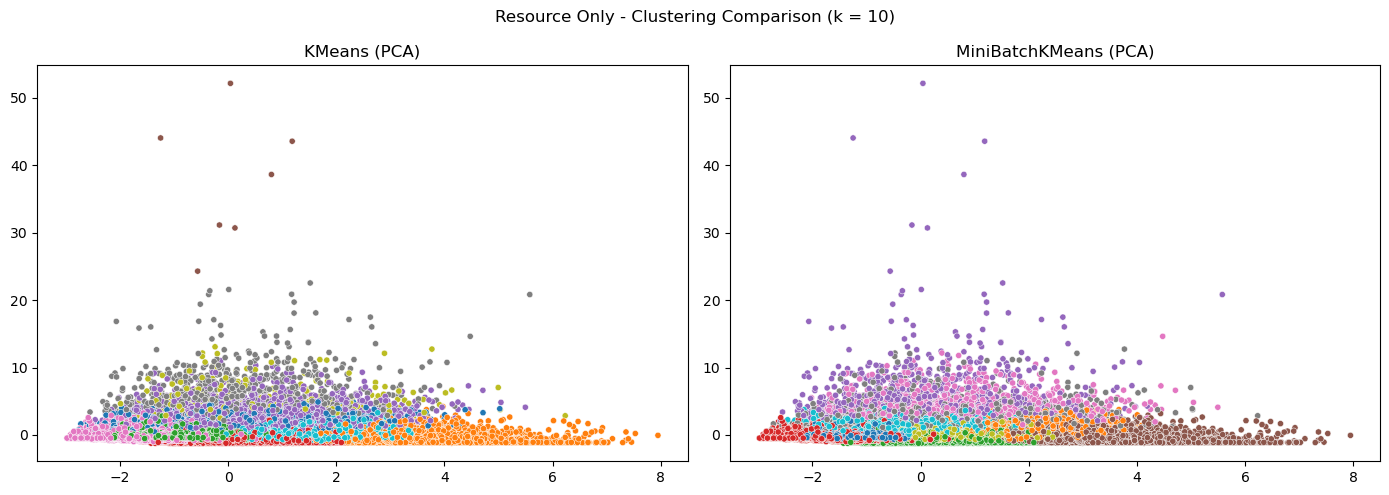


--- PCA Visualization for: Resource + Age ---


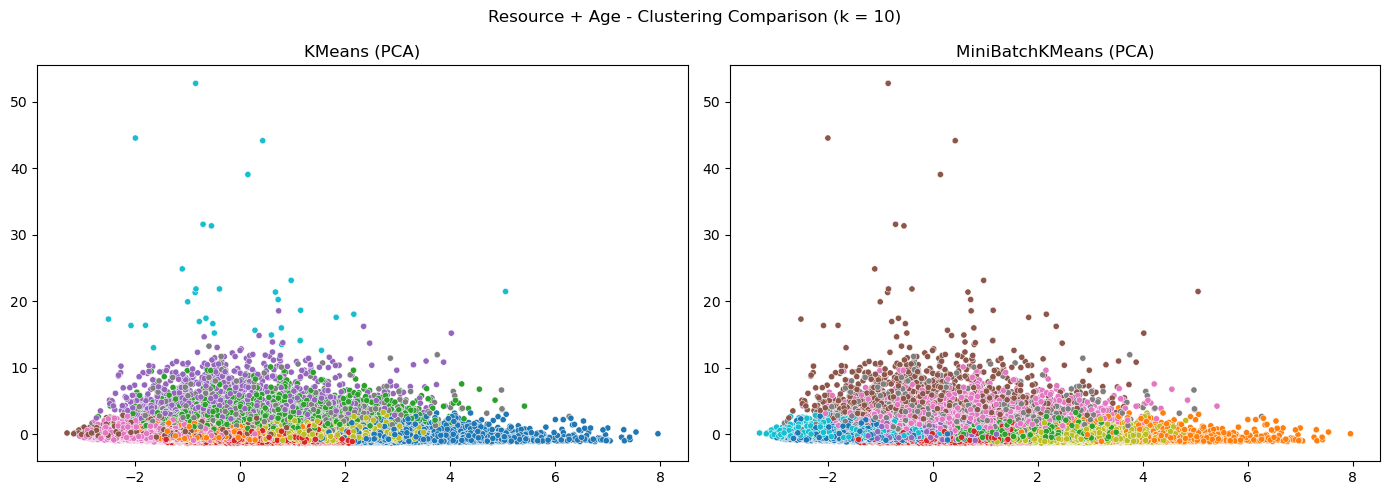

In [11]:
# Visualize the 2D clustering with PCA

for name, res in clustering_results.items():
    print(f"\n--- PCA Visualization for: {name} ---")
    X = res['X']
    kmeans_labels = res['kmeans_labels']
    mbk_labels = res['mbk_labels']

    # PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=kmeans_labels,
                    palette='tab10', s=20, ax=axes[0], legend=False)
    axes[0].set_title('KMeans (PCA)')

    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=mbk_labels,
                    palette='tab10', s=20, ax=axes[1], legend=False)
    axes[1].set_title('MiniBatchKMeans (PCA)')

    plt.suptitle(f'{name} - Clustering Comparison (k = {k})')
    plt.tight_layout()
    plt.show()

#### Examine the Cluster Sizes

Looking now at only the $k=10$ clusters formed KMeans on the Resource-Only dataset:

In [12]:
# Look at the number of points in each cluster of the K-means for the Resource-Only dataset

# Get the KMeans labels from the Resource-Only dataset
kmeans_labels = clustering_results['Resource Only']['kmeans_labels']

# Check cluster sizes
print(pd.Series(kmeans_labels).value_counts().sort_index())

# Add the cluster labels to the main dataset
df_clustered['cluster_kmeans_resource'] = kmeans_labels

0     4100
1     6451
2    34026
3    12924
4     5627
5        7
6    19116
7      884
8      285
9    18346
Name: count, dtype: int64


Observations:
- Cluster sizes vary significantly.
- Cluster 2 captures about one-third of the data.
- Clusters 3, 6, and 9 are also quite large.
- Clusters 5, 7, and 8 are small, which may reflect select patient subgroups.

We also assign the cluster labels to the `df_clustered` dataframe for later interpretation.

#### Cluster Interpretation: Resource Use and Readmission Patterns

To attempt understand what might distinguish the clusters, we plotted the distribution of each resource-related feature across the 10 clusters.

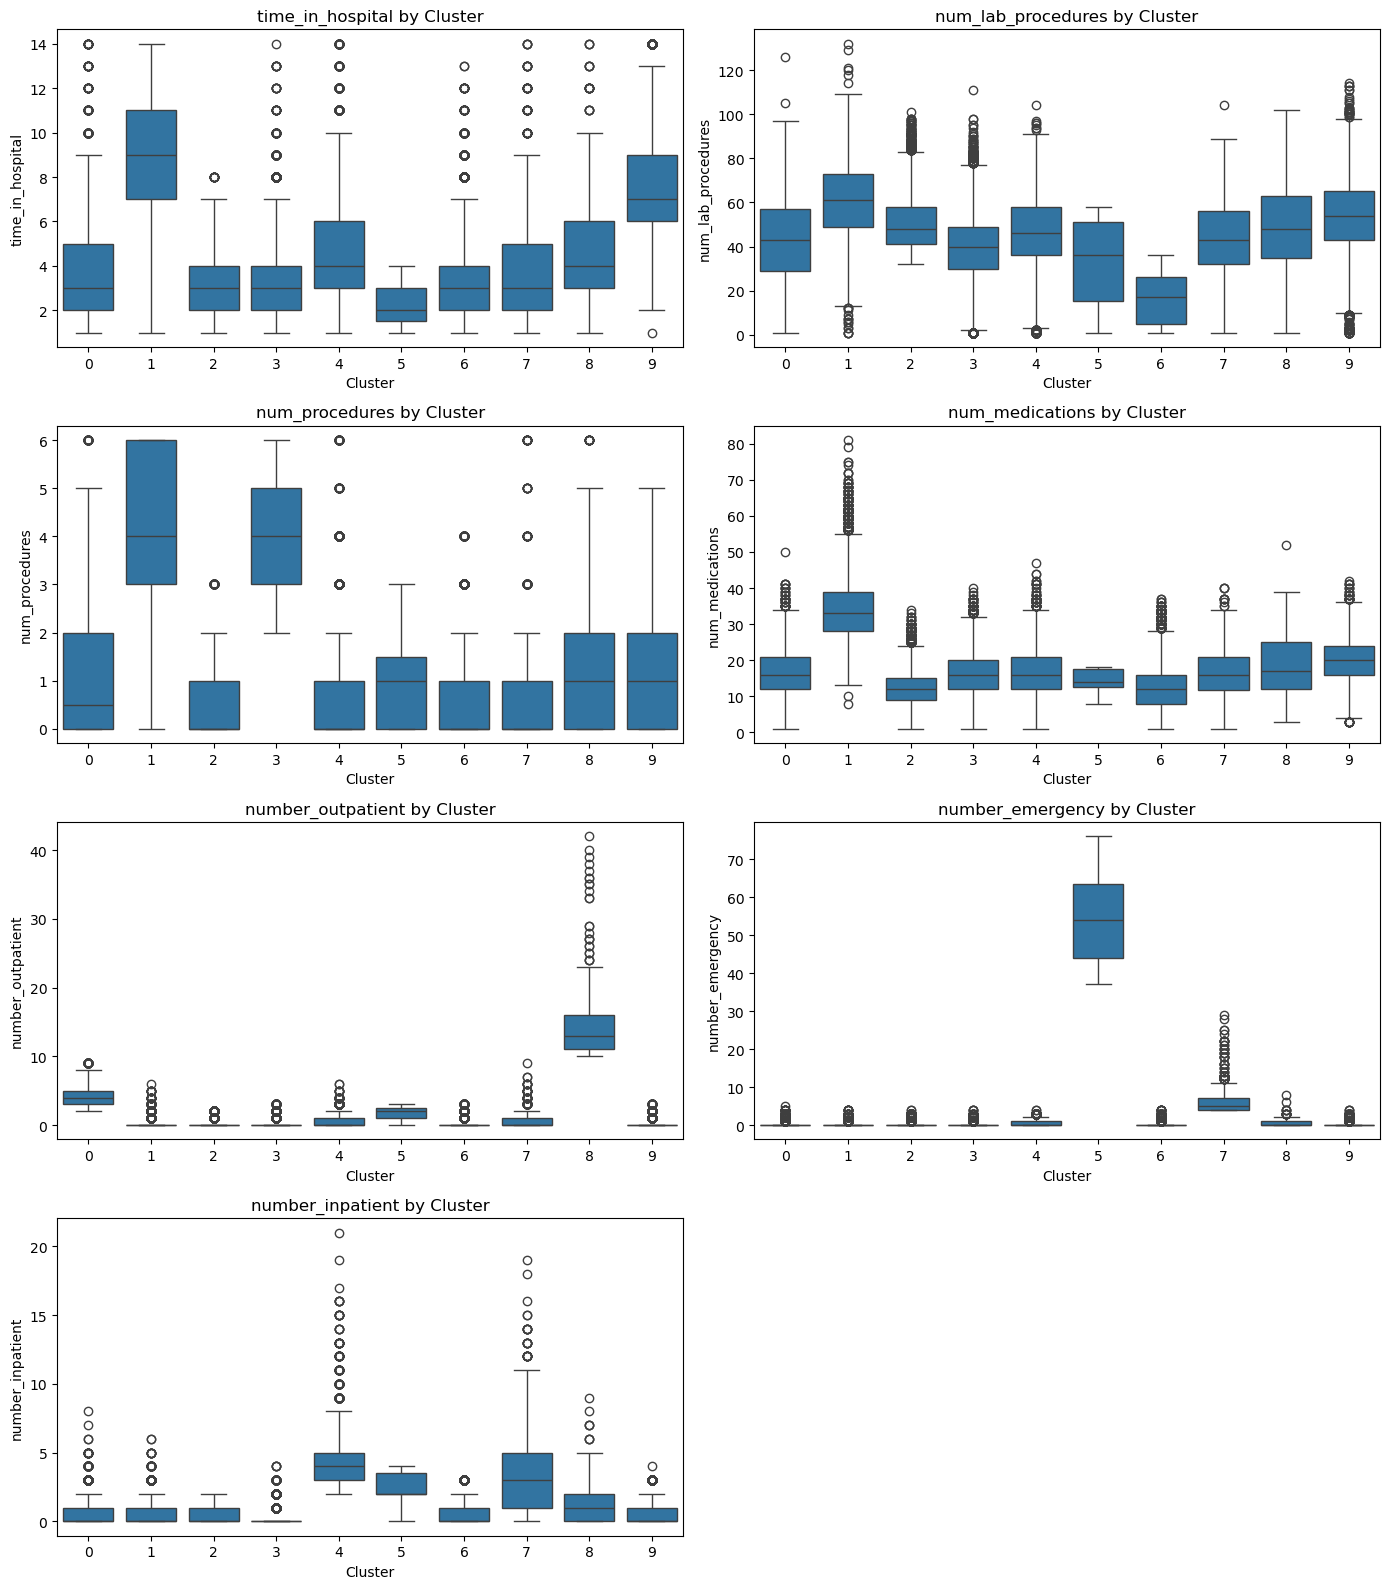

In [13]:
# # Use only the features relevant to resource use
# resource_features = [
#     'time_in_hospital', 'num_lab_procedures', 'num_procedures',
#     'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient'
# ]

cluster_col = 'cluster_kmeans_resource'  # make sure this was assigned earlier

# Plotting setup: 2 columns
n = len(resource_features)
n_cols = 2
n_rows = (n + 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 4))
axes = axes.flatten()

# Loop through features and plot
for i, feature in enumerate(resource_features):
    sns.boxplot(data=df_clustered, x=cluster_col, y=feature, ax=axes[i])
    axes[i].set_title(f"{feature} by Cluster")
    axes[i].set_xlabel("Cluster")
    axes[i].set_ylabel(feature)

# Turn off any unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Observations:
- Some clusters show clearly higher or lower usage for specific features.
  - Two small clusters stand out for number of visits, cluster 8 for outpatient visits and cluster 5 for emergency visits.
  - Cluster 1 stands out for highest median length of stay and number of medications. The number of procedures and lab procedures are also notably high, while the number of visits is low.

We also looked at the proportion of readmission status (`<30`, `>30`, `NO`) within each cluster.

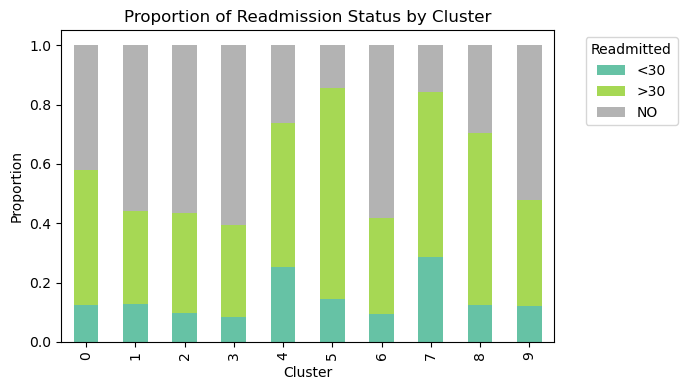

In [14]:
# Cross-tab: readmitted by cluster
readmit_ct = pd.crosstab(df_clustered['cluster_kmeans_resource'], df_clustered['readmitted'])

# Normalize to get row-wise proportions
readmit_props = readmit_ct.div(readmit_ct.sum(axis=1), axis=0)

# Plot stacked bar chart
readmit_props.plot(kind='bar', stacked=True, figsize=(7, 4), colormap='Set2')
plt.title('Proportion of Readmission Status by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Proportion')
plt.legend(title='Readmitted', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Observations:
- Most clusters had similar proportions of readmission overall.
- Clusters 4 and 7 had noticeably higher rates of early readmission and lower rates of no readmission.
- The small cluster 5 had similar rates of early readmission to the majority but much higher rates of late readmission. 

Resource use patterns may be associated with readmission risk, which we may explore further with classification modeling.

#### Feature Reduction with UMAP

Uniform Manifold Approximation & Projection (UMAP) is another Dimension Reduction technique, similar to t-SNE, that can be used for visualization and general non-linear dimension reduction. It's designed to preserve the local structure of the data and is robust to noise and outliers. Since we have a relatively complicated dataset with a moderate number of features, we can trial UMAP to see if it helps us visualize or cluster our data in a lower dimension.

In [15]:
# === Apply Preprocessing ===
df_model = df_clean.copy()
df_model = df_model.select_dtypes(include=['number'])

model_ss = StandardScaler().fit_transform(df_model)
model_rs = RobustScaler().fit_transform(df_model)
model_yeo = PowerTransformer(method='yeo-johnson', standardize=True).fit_transform(df_model)

In [16]:
df_model_standard = pd.DataFrame(model_ss, columns=df_model.columns)
df_model_robust = pd.DataFrame(model_rs, columns=df_model.columns)
df_model_yeo = pd.DataFrame(model_yeo, columns=df_model.columns)

To determine the most suitable distance metric for assessing clusters based on hospital resource usage, we need to consider the characteristics of the data.
Since the variables in our dataset have different scales and units (e.g., 'time_in_hospital' is in days, 'num_lab_procedures' is a count). Using a distance metric that is sensitive to scale differences may not be ideal.

Considering these factors, we have a few options that might be suitable:
1.	Mahalanobis distance: This metric takes into account the covariance between variables, making it suitable when the variables are correlated. However, it assumes that the data is multivariate normal, which might not be the case.
2.	SEuclidean (Standardized Euclidean) distance: This metric standardizes the variables to have unit variance, which can help alleviate the issue of different scales. It's a good choice when the variables are not highly correlated.
3.	Cosine similarity: Cosine similarity may also be useful in certain scenarios because it's scale-invariant and not affected by the magnitude of the values, only their direction.

In [17]:
# === Assess Multivariate Normality ===
def qq_plot_mahalanobis(X):
    X = X - np.mean(X, axis=0)
    S = np.cov(X, rowvar=False)
    S_inv = inv(S)
    d_squared = np.array([x @ S_inv @ x.T for x in X])
    d_squared.sort()

    chi2_quantiles = chi2.ppf((np.arange(1, len(d_squared)+1) - 0.5)/len(d_squared), df=X.shape[1])

    plt.scatter(chi2_quantiles, d_squared)
    plt.plot(chi2_quantiles, chi2_quantiles, color='red', lw=2)
    plt.title('Chi-Square Q-Q Plot of Mahalanobis Distances')
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel('Sample Quantiles')
    plt.grid()
    plt.show()

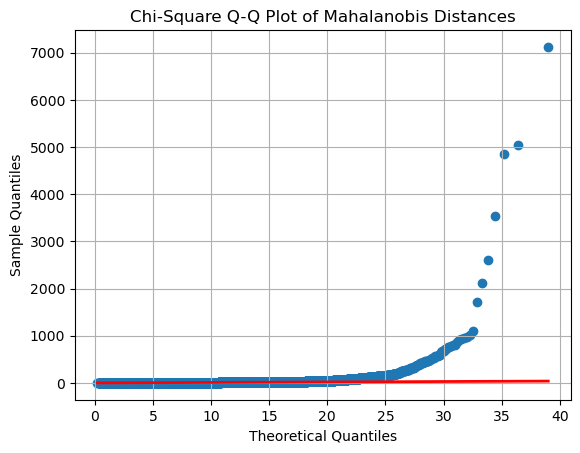

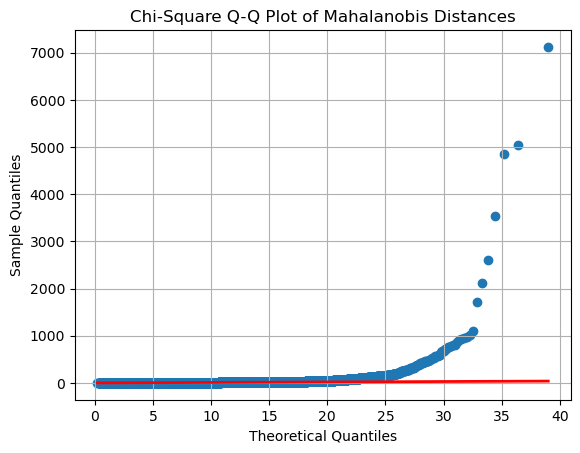

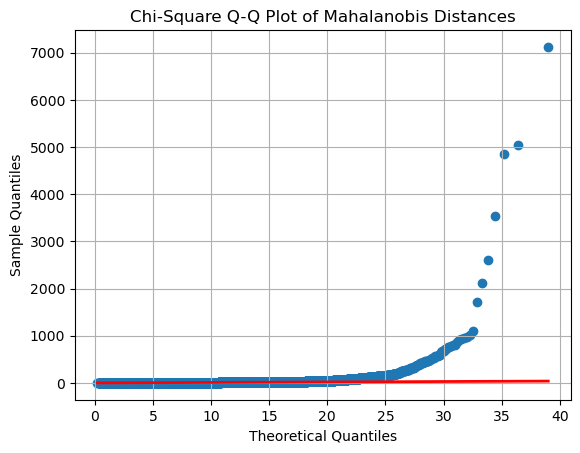

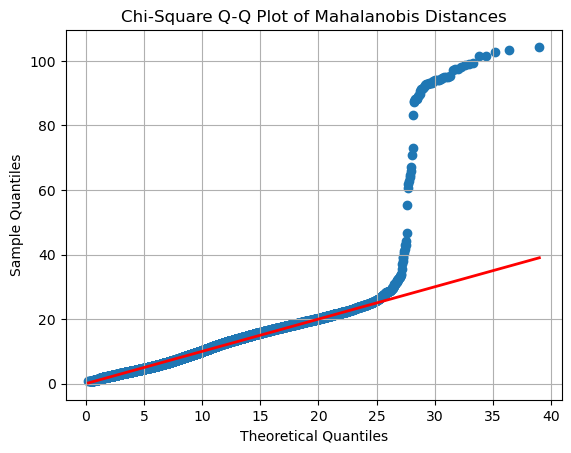

In [18]:
qq_plot_mahalanobis(df_model.values)
qq_plot_mahalanobis(df_model_standard.values)
qq_plot_mahalanobis(df_model_robust.values)
qq_plot_mahalanobis(df_model_yeo.values)

In [19]:
def mardia_test(X):
    n, p = X.shape
    X = X - np.mean(X, axis=0)
    S = np.cov(X, rowvar=False)
    S_inv = inv(S)
    d = np.array([x @ S_inv @ x.T for x in X])

    # Mardia's multivariate skewness
    skewness = np.sum([(x @ S_inv @ x.T)**3 for x in X]) / n**2
    # Mardia's multivariate kurtosis
    kurt = np.sum(d**2) / n

    return {'Mardia Skewness': skewness, 'Mardia Kurtosis': kurt}

In [20]:
result = mardia_test(df_model.values)
result_ss = mardia_test(df_model_standard.values)
result_rs = mardia_test(df_model_robust.values)
result_yeo = mardia_test(df_model_yeo.values)

print("Mardia Test (No Processing):", result)
print("Mardia Test (Standard Scaler):", result_ss)
print("Mardia Test (Robust Scaler):", result_rs)
print("Mardia Test (Yeo-Johnson):", result_yeo)

Mardia Test (No Processing): {'Mardia Skewness': 67.17526048263367, 'Mardia Kurtosis': 1612.7529271910773}
Mardia Test (Standard Scaler): {'Mardia Skewness': 67.17526048263376, 'Mardia Kurtosis': 1612.752927191077}
Mardia Test (Robust Scaler): {'Mardia Skewness': 67.17526048263363, 'Mardia Kurtosis': 1612.7529271910767}
Mardia Test (Yeo-Johnson): {'Mardia Skewness': 0.013963120746800346, 'Mardia Kurtosis': 85.76783726555527}


In [21]:
# === Baseline Clustering in High-Dimensional Space ===
kmeans_hd = KMeans(n_clusters=10, random_state=1234)
labels_hd = kmeans_hd.fit_predict(df_model_yeo)

In [22]:
# === PCA Comparison ===
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_model_yeo)

kmeans_pca = KMeans(n_clusters=10, random_state=1234)
labels_pca = kmeans_pca.fit_predict(X_pca)

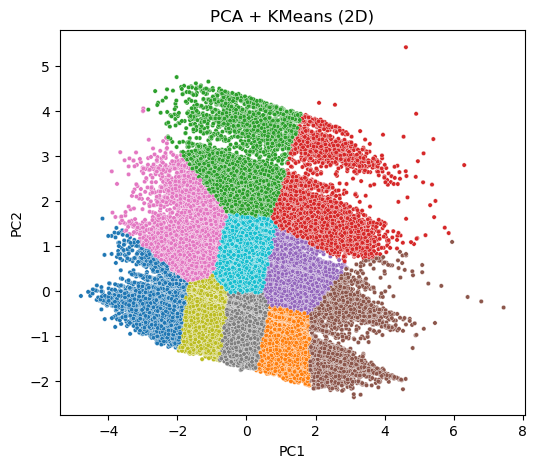

In [23]:
# PCA Scatter Plot
plt.figure(figsize=(6, 5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels_pca, palette='tab10', s=10, legend=False)
plt.title("PCA + KMeans (2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [24]:
# === UMAP Reduction ===
umap_mahalanobis = umap.UMAP(n_neighbors=30, min_dist=0.1, n_components=2, metric='mahalanobis', random_state=1234)
umap_cosine = umap.UMAP(n_neighbors=30, min_dist=0.1, n_components=2, metric='cosine', random_state=1234)
# umap_seuclidean = umap.UMAP(n_neighbors=30, min_dist=0.1, n_components=2, metric='seuclidean', random_state=1234)

In [25]:
X_umap_maha = umap_mahalanobis.fit_transform(df_model_yeo)
X_umap_cos = umap_cosine.fit_transform(df_model_yeo)
# X_umap_seuclid = umap_seuclidean.fit_transform(df_model_yeo)

/opt/anaconda3/envs/ML7331/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/ML7331/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/envs/ML7331/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/ML7331/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


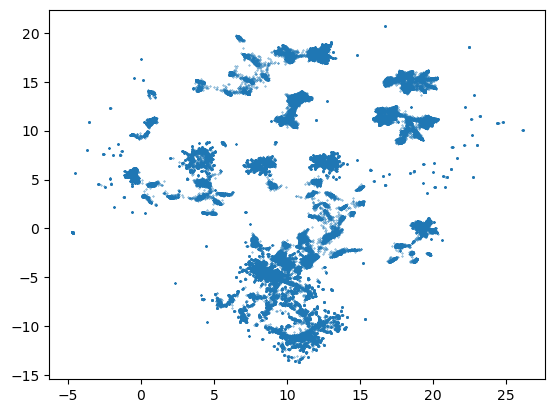

In [26]:
plt.scatter(X_umap_maha[:, 0], X_umap_maha[:, 1], s=0.1)

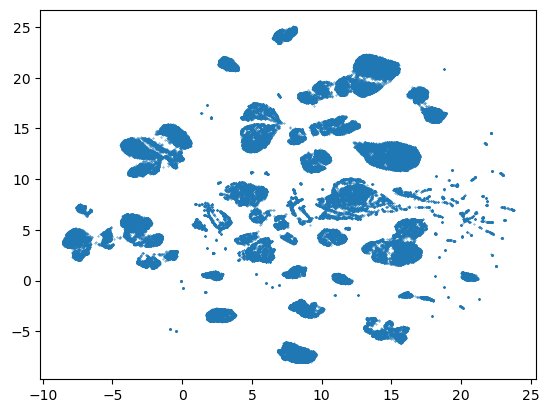

In [27]:
plt.scatter(X_umap_cos[:, 0], X_umap_cos[:, 1], s=0.1)

In [28]:
# === Clustering on UMAP-Reduced Data ===
kmeans_umap = KMeans(n_clusters=10, random_state=1234)
labels_umap_maha = kmeans_umap.fit_predict(X_umap_maha)
labels_umap_cos = kmeans_umap.fit_predict(X_umap_cos)

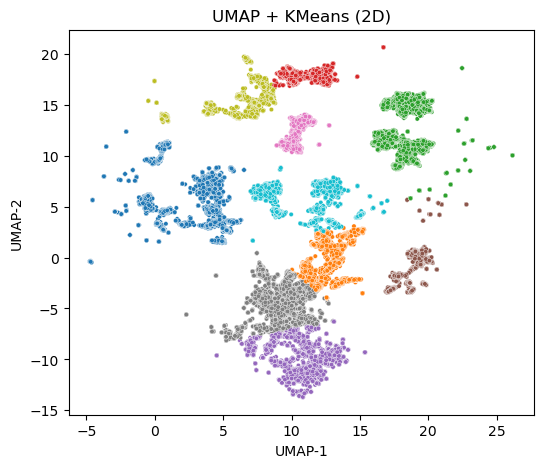

In [29]:
# === UMAP Visualization: Mahalanobis Distance ===
plt.figure(figsize=(6, 5))
sns.scatterplot(x=X_umap_maha[:, 0], y=X_umap_maha[:, 1], hue=labels_umap_maha, palette='tab10', s=10, legend=False)
plt.title("UMAP + KMeans (2D)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()

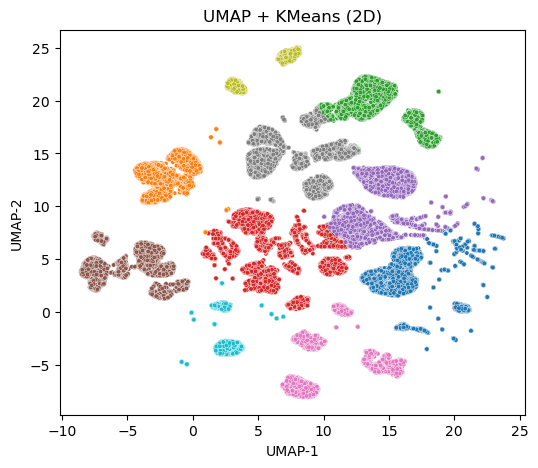

In [30]:
# === UMAP Visualization: Cosine Similarity ===
plt.figure(figsize=(6, 5))
sns.scatterplot(x=X_umap_cos[:, 0], y=X_umap_cos[:, 1], hue=labels_umap_cos, palette='tab10', s=10, legend=False)
plt.title("UMAP + KMeans (2D)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()

To compare the difference between PCA and UMAP for our data, we use various metrics that assess the quality of the dimensionality reduction and clustering approach.

1.	Trustworthiness: Measures the proportion of points that are among the k nearest neighbors in the original space and remain so in the reduced space.
2.	Silhouette Score: Measures the separation between clusters and the cohesion within clusters.
3.	Davies-Bouldin Index: Measures the average similarity between each cluster and its most similar cluster.
4.	Calinski-Harabasz Index: Measures the ratio of between-cluster variance to within-cluster variance.

In [31]:
# Sample 10,000 rows for Trustworthiness Metric (Very memory intensive otherwise)
np.random.seed(1234) 
sample_idx = np.random.choice(df_model_yeo.shape[0], size=10000, replace=False)
X_sample = df_model_yeo.values[sample_idx]

X_pca_sample = X_pca[sample_idx]
X_umap_sample_maha = X_umap_maha[sample_idx]
X_umap_sample_cos = X_umap_cos[sample_idx]

In [32]:
# Evaluation Metrics (Baseline)
# No trustworthiness for baseline because it’s already the reference. There is no dimensionality reduction to evaluate.
sil_hd = silhouette_score(df_model_yeo, labels_hd)
db_hd = davies_bouldin_score(df_model_yeo, labels_hd)
ch_hd = calinski_harabasz_score(df_model_yeo, labels_hd)

In [33]:
# Evaluation Metrics (PCA)
# trust_pca = trustworthiness(X_sample, X_pca_sample, n_neighbors=5)
sil_pca = silhouette_score(X_pca, labels_pca)
db_pca = davies_bouldin_score(X_pca, labels_pca)
ch_pca = calinski_harabasz_score(X_pca, labels_pca)

In [34]:
# Evaluation Metrics (UMAP)
trust_umap_maha = trustworthiness(X_sample, X_umap_sample_maha, n_neighbors=30)
sil_umap_maha = silhouette_score(X_umap_maha, labels_umap_maha)
db_umap_maha = davies_bouldin_score(X_umap_maha, labels_umap_maha)
ch_umap_maha = calinski_harabasz_score(X_umap_maha, labels_umap_maha)

In [35]:
# Evaluation Metrics (UMAP)
trust_uma_cos = trustworthiness(X_sample, X_umap_sample_cos, n_neighbors=30)
sil_umap_cos = silhouette_score(X_umap_cos, labels_umap_cos)
db_umap_cos = davies_bouldin_score(X_umap_cos, labels_umap_cos)
ch_umap_cos = calinski_harabasz_score(X_umap_cos, labels_umap_cos)

In [36]:
# === Clustering Metrics Comparison ===
print("\nClustering Performance with K-MEANS:\n")
print(f"{'Metric':<30}{'Baseline':>12}{'PCA':>12}{'UMAP-Maha':>12}{'UMAP-Cos':>12}")
print("-" * 80)
print(f"{'Trustworthiness':<30}{'N/A':>12}{'N/A':>12}{trust_umap_maha:12.3f}{trust_uma_cos:12.3f}")
print(f"{'Silhouette Score':<30}{sil_hd:12.3f}{sil_pca:12.3f}{sil_umap_maha:12.3f}{sil_umap_cos:12.3f}")
print(f"{'Davies-Bouldin Index':<30}{db_hd:12.3f}{db_pca:12.3f}{db_umap_maha:12.3f}{db_umap_cos:12.3f}")
print(f"{'Calinski-Harabasz Score':<30}{ch_hd:12.3f}{ch_pca:12.1f}{ch_umap_maha:12.1f}{ch_umap_cos:12.3f}")


Clustering Performance with K-MEANS:

Metric                            Baseline         PCA   UMAP-Maha    UMAP-Cos
--------------------------------------------------------------------------------
Trustworthiness                        N/A         N/A       0.893       0.978
Silhouette Score                     0.187       0.357       0.501       0.485
Davies-Bouldin Index                 1.604       0.824       0.661       0.666
Calinski-Harabasz Score          14461.531     79584.4    169744.6  130917.130


In [37]:
#Replace '?' with NaN 
df_2 = df.copy()

df_2.replace('?', pd.NA, inplace=True)

# Check for columns with missing values
missing_summary = df_2.isnull().sum()

In [38]:
# Drop columns that may not contribute to analysis
df_2.drop(['encounter_id', 'patient_nbr','weight','max_glu_serum','A1Cresult','examide','citoglipton'], axis=1, inplace=True)


high_cardinality_columns = [col for col in df_2.columns if df_2[col].nunique() > 9]

# Step 1: Create frequency maps for all columns
frequency_maps = {col: df_2[col].value_counts() for col in high_cardinality_columns}

# Step 2: Apply frequency encoding
for col in high_cardinality_columns:
    df_2[f'{col}_encoded'] = df_2[col].map(frequency_maps[col])

# Apply encoding with fallback for unseen categories
for col in high_cardinality_columns:
    df_2[f'{col}_encoded'] = df_2[col].map(frequency_maps[col]).fillna(0)

print(df)

# Dropping old high cardinality columns
df_2.drop(high_cardinality_columns, axis=1, inplace=True)

# Identify all new columns that have 'encoded' in their names
high_cardinality_columns = [col for col in df_2.columns if 'encoded' in col ]

        encounter_id  patient_nbr             race  gender      age weight  \
0            2278392      8222157        Caucasian  Female   [0-10)      ?   
1             149190     55629189        Caucasian  Female  [10-20)      ?   
2              64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3             500364     82442376        Caucasian    Male  [30-40)      ?   
4              16680     42519267        Caucasian    Male  [40-50)      ?   
...              ...          ...              ...     ...      ...    ...   
101761     443847548    100162476  AfricanAmerican    Male  [70-80)      ?   
101762     443847782     74694222  AfricanAmerican  Female  [80-90)      ?   
101763     443854148     41088789        Caucasian    Male  [70-80)      ?   
101764     443857166     31693671        Caucasian  Female  [80-90)      ?   
101765     443867222    175429310        Caucasian    Male  [70-80)      ?   

        admission_type_id  discharge_disposition_id  admission_

In [39]:
categorical_columns = df_2.select_dtypes(include='object').columns
categorical_columns = list(categorical_columns[0:23]) + list(categorical_columns[24:26])
print(categorical_columns)


#one-hot encoding to all categorical columns
df_encoded = pd.get_dummies(df_2.drop(columns=high_cardinality_columns + ['change']), 
                            columns=categorical_columns, 
                            drop_first=False)

df_encoded = pd.concat([df_2[high_cardinality_columns] , df_2[['change']], df_encoded], axis=1)

['race', 'gender', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'diabetesMed', 'readmitted']


In [40]:
## Remove duplicate columns
df_encoded = df_encoded.loc[:, ~df_encoded.T.duplicated()]

# Check for columns with missing values
missing_summary = df_encoded.isnull().sum()

In [41]:
df_encoded = df_encoded.drop(columns=['payer_code_encoded'] + ['medical_specialty_encoded'])

# Factorize all categorical variables

# Select all boolean columns
categorical_columns = list(df_encoded.select_dtypes(include='bool').columns)

# Append 'readmitted' column to the list (if it exists in the DataFrame)
if 'change' in df_encoded.columns:
    categorical_columns.append('change')

# Factorize    
for col in categorical_columns:
    df_encoded[col], mapping = pd.factorize(df_encoded[col])

In [42]:
# Define threshold
threshold = 0.8

# Compute the most common value frequency per column
highly_constant_columns = [
    col for col in df_encoded.columns 
    if df_encoded[col].value_counts(normalize=True).iloc[0] > threshold
]

# Drop these columns
df_filtered = df_encoded.drop(columns=highly_constant_columns)

In [43]:
from sklearn.ensemble import RandomForestClassifier

# Quick feature importance analysis
X = df_filtered.drop(['change'], axis=1)
y = df_filtered['change']

model = RandomForestClassifier(random_state=1234)
model.fit(X, y)

# Feature importance
feature_importance = pd.Series(model.feature_importances_, index=X.columns)
feature_importance.sort_values(ascending=False, inplace=True)

for feature,importance in feature_importance.items():
     if importance >= .02:
         print(f"{feature}: {importance}")
         
# Save feature names with importance >= 0.02 into a list
important_features = feature_importance[feature_importance >= 0.02].index.tolist()

insulin_No: 0.1519994820599512
diabetesMed_No: 0.10388205012830021
insulin_Steady: 0.10297590499144837
diabetesMed_Yes: 0.09147010646412693
num_lab_procedures_encoded: 0.06504953506013622
num_medications_encoded: 0.06090815684284003
diag_2_encoded: 0.059924752990208933
diag_1_encoded: 0.05992460297163986
diag_3_encoded: 0.05855837026978577
time_in_hospital_encoded: 0.03777486001193439
age_encoded: 0.03472386406390971
number_diagnoses_encoded: 0.02648790384350557
num_procedures: 0.02563212010701538
discharge_disposition_id_encoded: 0.022925199213445036


In [44]:
# Drop these columns
df_filtered = df_encoded.drop(columns=highly_constant_columns)
df_reduced = df_filtered.drop(columns=['readmitted_>30', 'readmitted_NO'])

In [45]:
df_2['readmitted'], uniques = pd.factorize(df_2['readmitted'])

### Normalizing data before clustering
scaler = StandardScaler()

# Fit and transform the data
df_normalized = scaler.fit_transform(df_reduced)
df_normalized = pd.DataFrame(df_normalized, columns=df_reduced.columns)

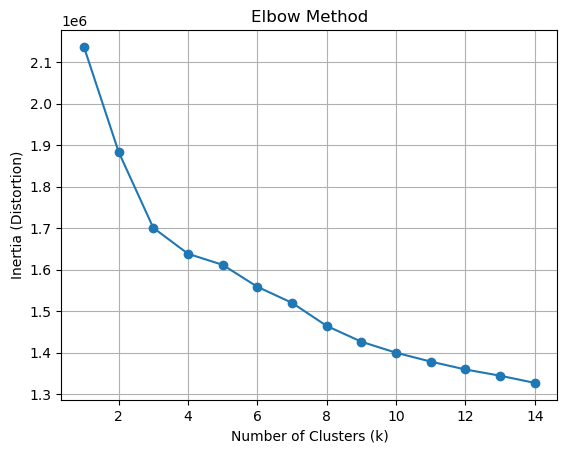

In [46]:
inertia = []
K_range = range(1, 15)

for k in K_range:
    model = KMeans(n_clusters=k, random_state=1234)
    model.fit(df_normalized)
    inertia.append(model.inertia_)  # Sum of squared distances to cluster centers

# Plot
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Distortion)')
plt.grid(True)
plt.show()

In [47]:
### Performing Clustering
k = 7  
model = KMeans(n_clusters=k, random_state=42)
cluster_labels = model.fit_predict(df_normalized)

# Add cluster labels back to original dataset
df_labeled = df_reduced.copy()  
df_labeled['Cluster'] = cluster_labels

# Cluster Statistics
cluster_summary = df_labeled.groupby('Cluster').mean()

In [48]:
# Comparing Readmission rates
df_labeled['readmitted'] = df_2['readmitted']
readmission_by_cluster = df_labeled.groupby('Cluster')['readmitted'].value_counts(normalize=True)
print(readmission_by_cluster)

Cluster  readmitted
0        0             0.504764
         1             0.356724
         2             0.138512
1        0             0.591085
         1             0.314735
         2             0.094180
2        0             0.518519
         1             0.367901
         2             0.113580
3        0             0.557548
         1             0.337095
         2             0.105357
4        0             0.600324
         1             0.301498
         2             0.098178
5        0             0.477844
         1             0.400760
         2             0.121396
6        0             0.572681
         1             0.321821
         2             0.105497
Name: proportion, dtype: float64


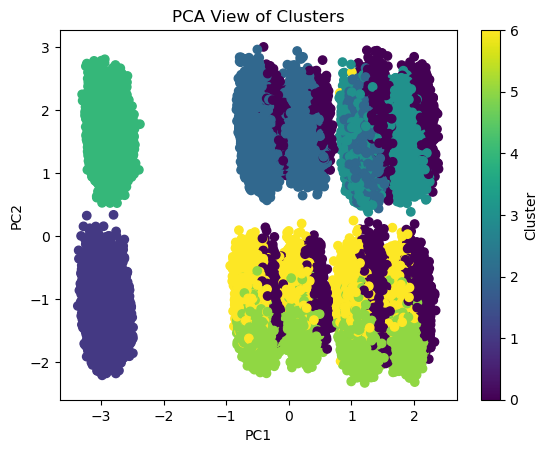

In [49]:
# CLuster Visualization
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_data = pca.fit_transform(df_normalized)

# Save for reuse
df_pca = pd.DataFrame(pca_data, columns=['PC1', 'PC2'])

plt.scatter(pca_data[:, 0], pca_data[:, 1], c=cluster_labels, cmap='viridis')
plt.title('PCA View of Clusters')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Cluster')
plt.show()

In [50]:
### DBSCAN

# Groups points into clusters based on density
# No need to predefine k
# Automatically identifies outliers, which may be patients that don’t conform to common profiles.
dbscan = DBSCAN(eps=3, min_samples=19)  # Start with these; we can tune them
dbscan_labels = dbscan.fit_predict(df_normalized)
df_dbscan = df_reduced.copy()
df_dbscan['Cluster'] = dbscan_labels  # -1 means outlier
df_dbscan['readmitted'] = df_2['readmitted'].values

# Frequency of readmission values per cluster
readmission_by_cluster = df_dbscan.groupby('Cluster')['readmitted'].value_counts(normalize=True).unstack(fill_value=0)
print(readmission_by_cluster)

readmitted         0         1         2
Cluster                                 
-1          0.478456  0.397666  0.123878
 0          0.522902  0.360968  0.116130
 1          0.596131  0.307974  0.095895


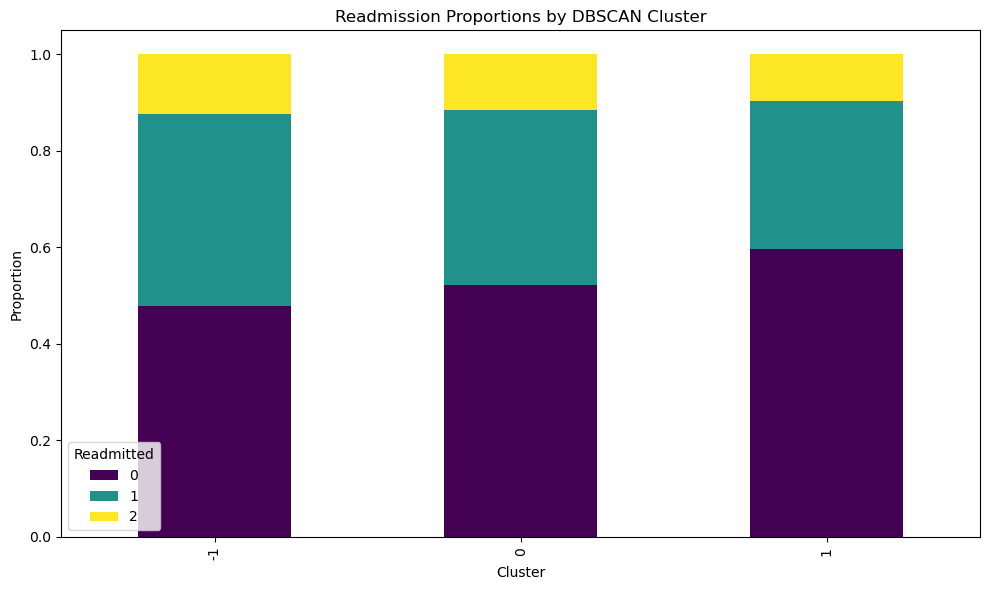

In [51]:
#Stacked Bar Chart
readmission_by_cluster.plot(kind='bar', stacked=True, figsize=(10,6), colormap='viridis')
plt.title('Readmission Proportions by DBSCAN Cluster')
plt.xlabel('Cluster')
plt.ylabel('Proportion')
plt.legend(title='Readmitted')
plt.tight_layout()
plt.show()

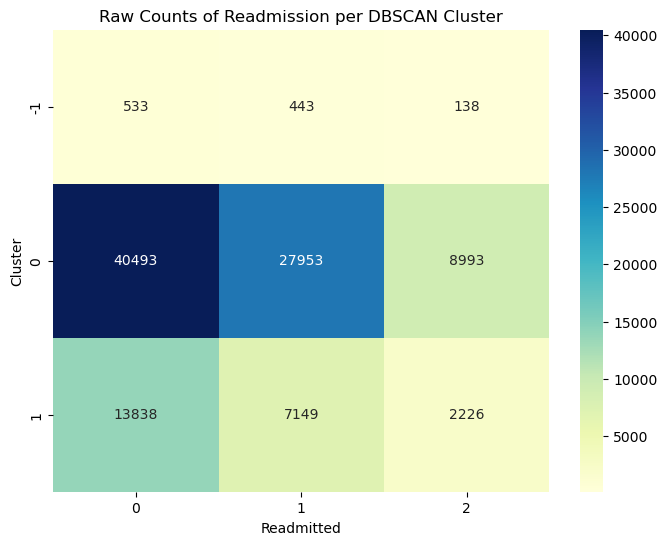

In [52]:
df_dbscan.groupby('Cluster')['readmitted'].value_counts()

np.unique(dbscan_labels, return_counts=True)
heat_data = df_dbscan.groupby(['Cluster', 'readmitted']).size().unstack().fillna(0)

plt.figure(figsize=(8, 6))
sns.heatmap(heat_data, annot=True, fmt='g', cmap='YlGnBu')
plt.title('Raw Counts of Readmission per DBSCAN Cluster')
plt.xlabel('Readmitted')
plt.ylabel('Cluster')
plt.show()

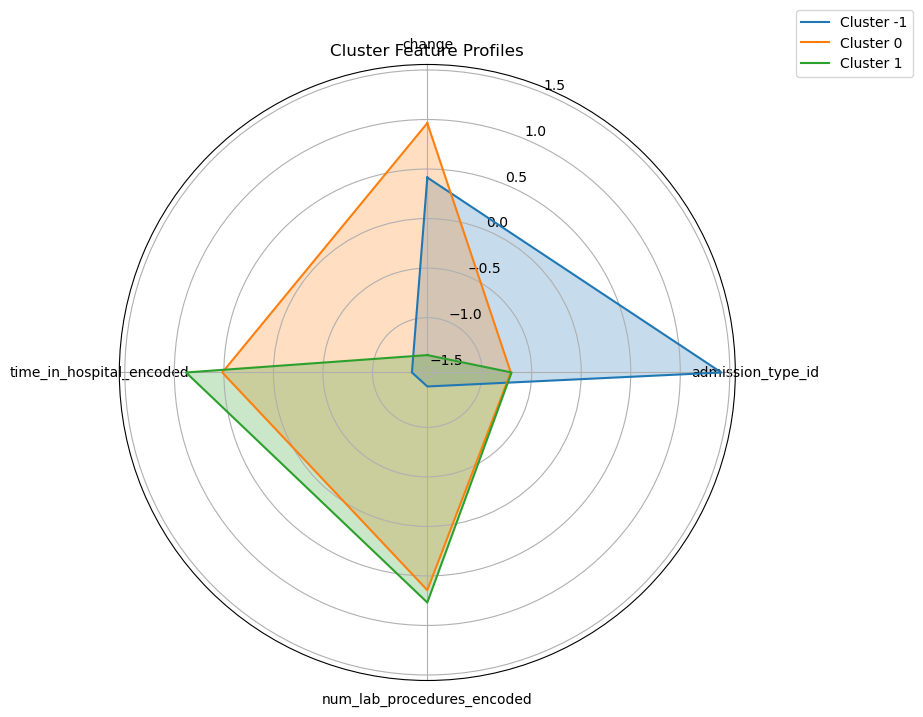

In [53]:
# Choose a few key features to compare
features = ['change', 'admission_type_id', 'num_lab_procedures_encoded', 'time_in_hospital_encoded']
cluster_means = df_dbscan.groupby('Cluster')[features].mean()

# Fit and transform the cluster_means
cluster_means_normalized = pd.DataFrame(
    scaler.fit_transform(cluster_means),
    columns=cluster_means.columns,
    index=cluster_means.index
)

# Radar plot setup
labels = features
num_vars = len(labels)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
labels += labels[:1]
angles += angles[:1]

# Plot each cluster
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for i, row in cluster_means_normalized.iterrows():
    values = row.tolist()
    values += values[:1]
    ax.plot(angles, values, label=f'Cluster {i}')
    ax.fill(angles, values, alpha=0.25)

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), labels[:-1])
plt.title('Cluster Feature Profiles')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()

#### DBSCAN: K-Distance Plot for Distance Tuning

We use DBSCAN to try capturing more irregular or non-globular clusters in the resource use data.

Unlike, K-Means, DBSCAN doesn't require specifying the number of clusters in advance. Instead, it groups points that are close together based on two parameters:

- `eps`: how far apart points can be to be considered neighbors
- `min_samples`: the minimum number of points (minPts) needed to be considered a core point in a cluster

To help choose a good `eps`, we use a K-distance graph, which plots the distance to each point’s $n^{\text{th}}$ nearest neighbor. The "elbow" of this curve suggests a reasonable threshold for `eps`. A good rule of thumb for this $k$ is number of features plus one or two - in our case, 7 + 1 = 8.

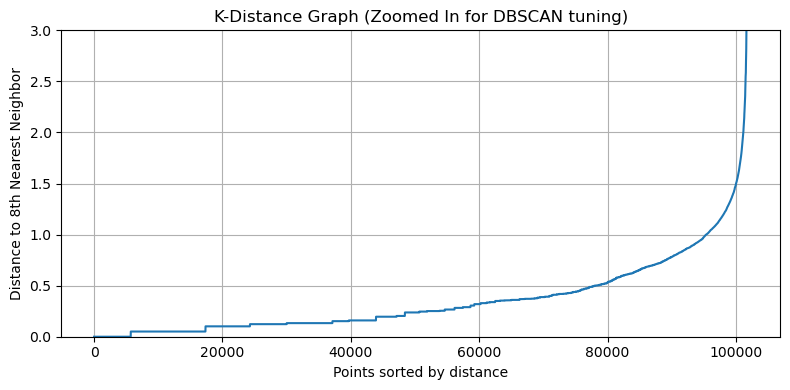

In [54]:
X = datasets['Resource Only']  # already scaled

k = 8  # typically min_samples = k, number of features + 1 (or 2)
nn = NearestNeighbors(n_neighbors=k)
nn_fit = nn.fit(X)
distances, indices = nn_fit.kneighbors(X)

# Get distances to the k-th nearest neighbor
k_distances = np.sort(distances[:, k-1])  # index k-1 because it's 0-based

# Plot the sorted distances
plt.figure(figsize=(8, 4))
plt.plot(k_distances)
plt.ylim(0, 3)  # zoom in to focus on the low-distance region
plt.title("K-Distance Graph (Zoomed In for DBSCAN tuning)")
plt.xlabel("Points sorted by distance")
plt.ylabel(f"Distance to {k}th Nearest Neighbor")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Grid Search `eps` and `min_samples`

We then ran a small grid search over `eps` and `min_samples` looking for a balance between:
- number of clusters
- noise
- silhouette score

We tried additional parameter values, but limited the search below because of computation time.

In [55]:
# Grid search for best eps and minpts based on the elbow from the k-neighbors plot
print("\n--- DBSCAN Grid Search Results ---")

results = []
best_score = -1
best_config = None

start_time = time.time()

for eps in [2.0, 2.2]: # also tried eps, 1.8, 1.9, 2.1, 2.3
    for min_samples in [3, 4, 5, 6]: # also tried higher min_samples 7, 8, 10
        db = DBSCAN(eps=eps, min_samples=min_samples)
        labels = db.fit_predict(X)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = np.sum(labels == -1)

        if n_clusters > 1 and n_noise < len(X):
            score = silhouette_score(X, labels, sample_size=5000, random_state=1234)
            results.append({
                'eps': eps,
                'min_samples': min_samples,
                'n_clusters': n_clusters,
                'n_noise': n_noise,
                'silhouette': score
            })
            if score > best_score:
                best_score = score
                best_config = (eps, min_samples)

results_df = pd.DataFrame(results)
print(results_df.sort_values('silhouette', ascending=False))

print(f"DBSCAN time: {(time.time() - start_time)/60:.2f} minutes")


--- DBSCAN Grid Search Results ---
   eps  min_samples  n_clusters  n_noise  silhouette
1  2.0            4           4      216    0.778884
5  2.2            4           3      148    0.778884
2  2.0            5           3      255    0.776407
3  2.0            6           4      264    0.776407
0  2.0            3           6      189    0.746431
4  2.2            3           6      131    0.746431
DBSCAN time: 10.97 minutes


We selected `eps = 2.0` and `min_samples = 4`. Fewer than 4 clusters seemed too coarse to be useful and that had a reasonable number of unclustered noise points.

The cluster labels were saved to the main dataset for later interpretation.

#### Fit DBSCAN Model

We use the 'best' parameter combination to fit DBSCAN and generate cluster labels.

In [56]:
# Final DBSCAN model
db = DBSCAN(eps=2.0, min_samples=4)
db_labels = db.fit_predict(datasets['Resource Only'])

# Save labels to main dataframe
df_clustered['cluster_dbscan_resource'] = db_labels

#### Visualize DBSCAN Clusters with PCA

We project high-dimensional clustering results into 2-D space for easier visualization.

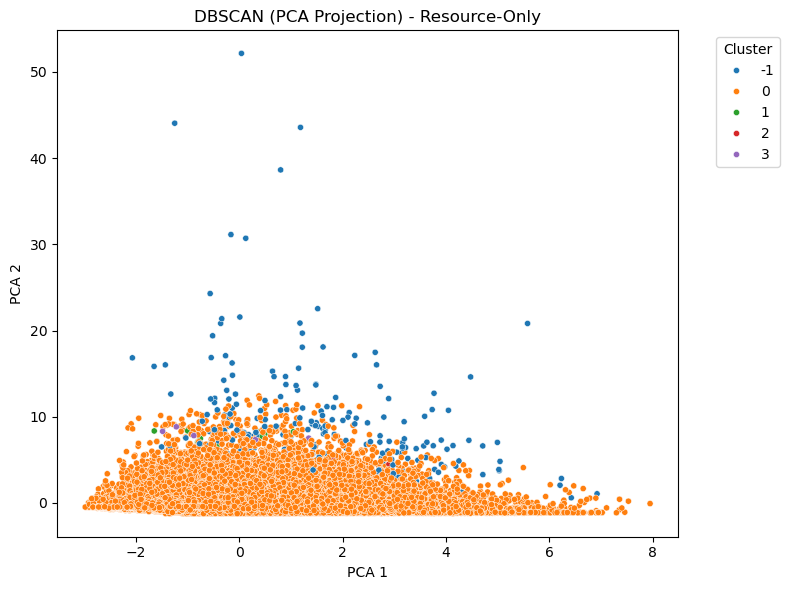

In [57]:
# PCA visualization of DBSCAN clustering

X = datasets['Resource Only']
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=db_labels,
                palette='tab10', s=20)
plt.title('DBSCAN (PCA Projection) - Resource-Only')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# -1 are noise points that don't get clustered in DBSCAN

#### Examine Cluster Sizes

We print the number of points in each cluster, including the noise points (-1) to get a sense of how the data are distributed.

In [58]:
# Check number of points in each DBSCAN cluster
print(pd.Series(db_labels).value_counts().sort_index())

-1       216
 0    101530
 1        10
 2         4
 3         6
Name: count, dtype: int64


Observations:  
- Our chosen parameters formed 3 tiny clusters and identified 216 points as noise (label -1).
- The vast majority of data (over 100,000 records) were grouped into a single dominant cluster (label 0).
- There will likely not be much we can learn about the large cluster 0, but perhaps the others may provide a bit of insight. 

#### Visualize Resource Use by Cluster

We make boxplots for each feature to help compare patterns across clusters.

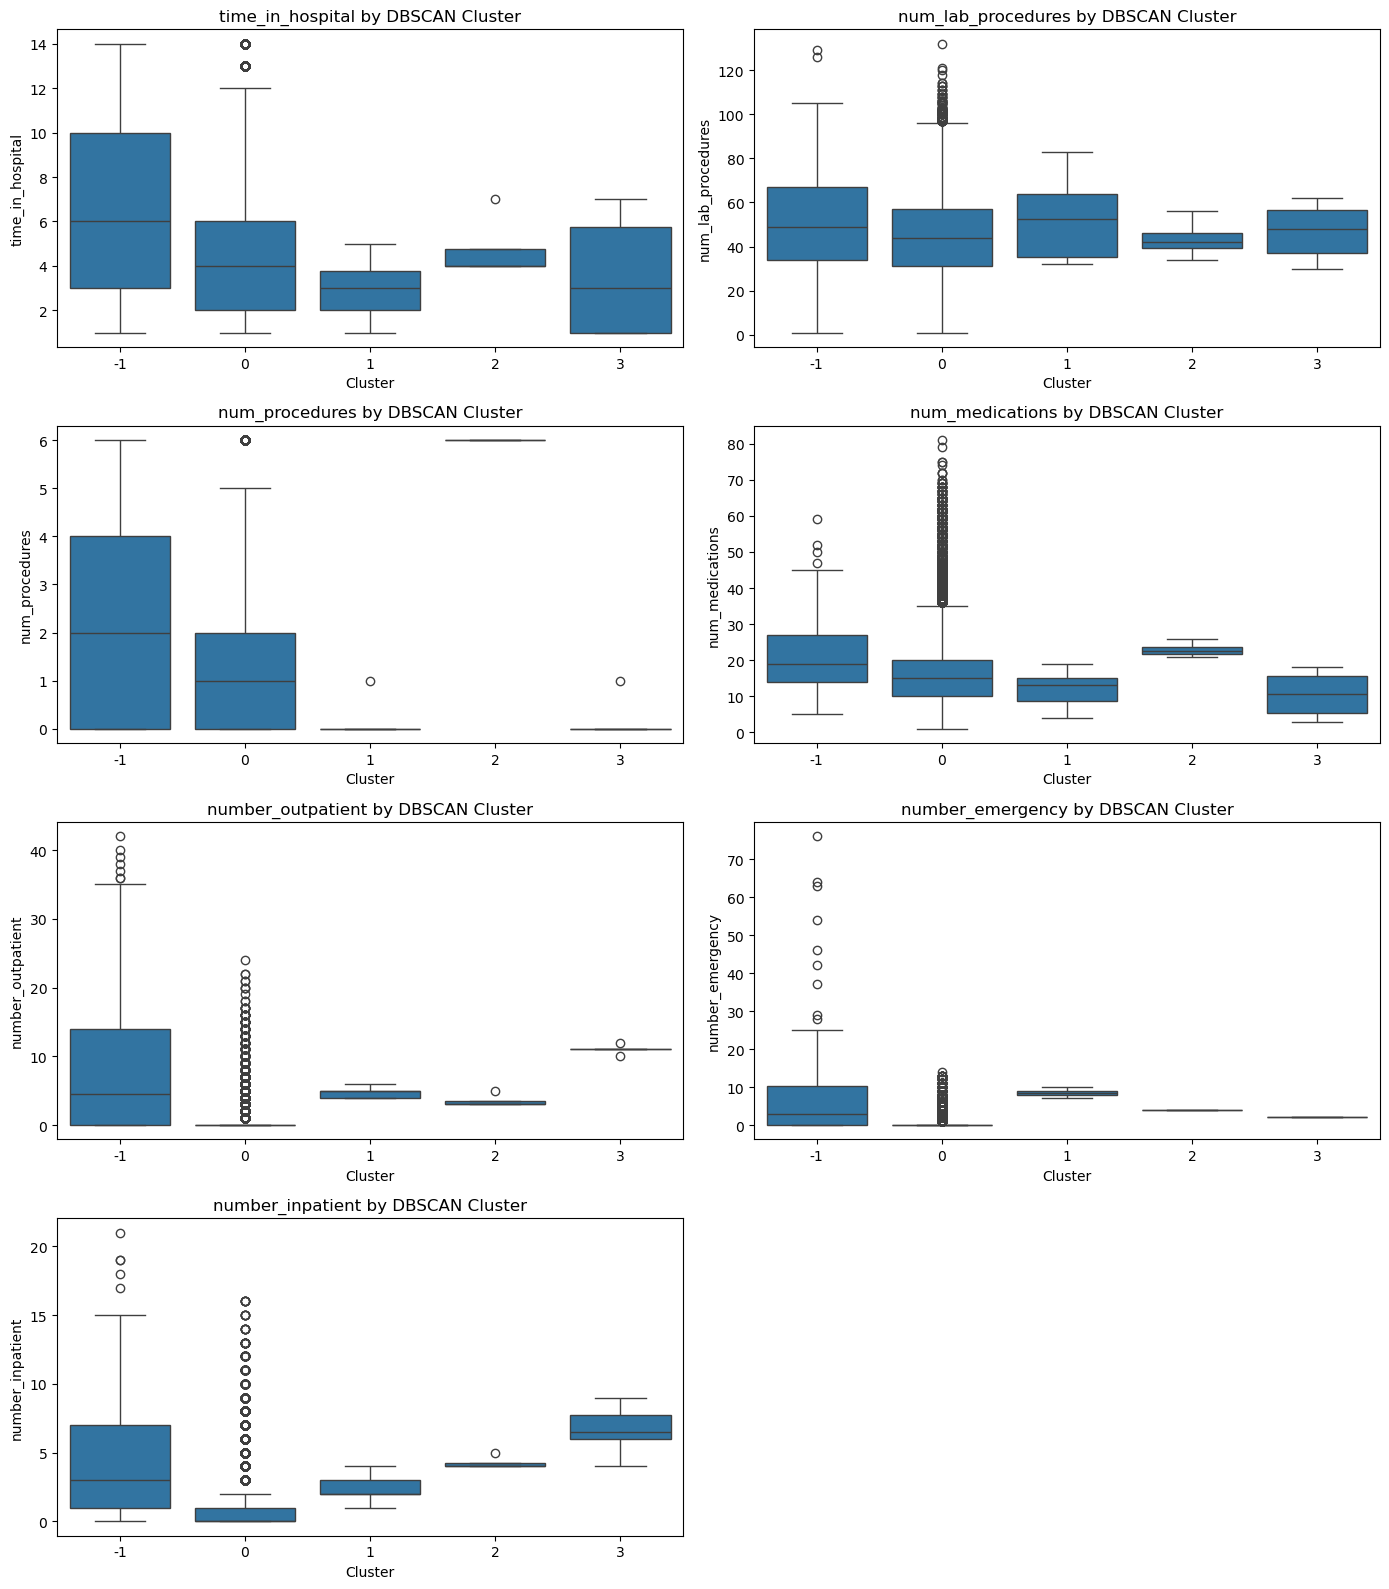

In [59]:
# Boxplots of resource use per cluster
cluster_col = 'cluster_dbscan_resource'

n = len(resource_features)
n_cols = 2
n_rows = (n + 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 4))
axes = axes.flatten()

for i, feature in enumerate(resource_features):
    sns.boxplot(data=df_clustered, x=cluster_col, y=feature, ax=axes[i])
    axes[i].set_title(f"{feature} by DBSCAN Cluster")
    axes[i].set_xlabel("Cluster")
    axes[i].set_ylabel(feature)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Interpretation:  
It is hard to learn much from the boxplots about resource use by cluster based on extreme cluster size differences, though cluster 0 has very low number of hospital visits compared to the other clusters including the noise points.

#### Plot Proportion of Readmission Status by Cluster

A stacked bar chart shows how readmission status varies across the clusters.

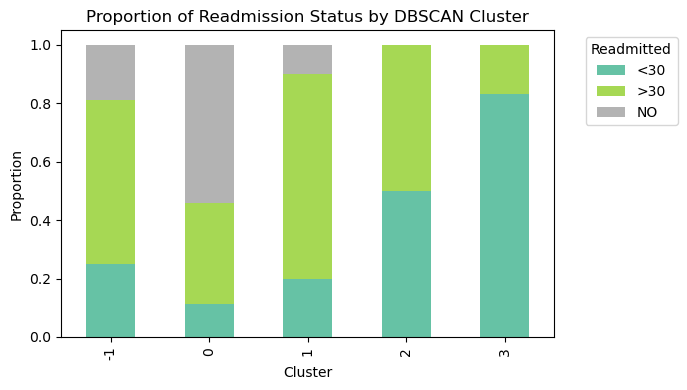

In [60]:
# Cross-tab and proportions
readmit_ct = pd.crosstab(df_clustered['cluster_dbscan_resource'], df_clustered['readmitted'])
readmit_props = readmit_ct.div(readmit_ct.sum(axis=1), axis=0)

# Plot
readmit_props.plot(kind='bar', stacked=True, figsize=(7, 4), colormap='Set2')
plt.title('Proportion of Readmission Status by DBSCAN Cluster')
plt.xlabel('Cluster')
plt.ylabel('Proportion')
plt.legend(title='Readmitted', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Interpretation:  
Although it is hard to take much away from this plot based on the cluster size differences, here are some things to note:
- Readmission proportions vary across the clusters.
- Clusters 2 and 3 have higher proportions of early readmissions (`<30`) and with patients that were not readmitted, though their sample sizes are extremely small.
- Cluster 0 has a much greater proportion of individuals that were not readmitted.

DBSCAN may have helped identify some potential edge cases or outlier groups, but is not ideal for the full dataset due to its heavy skew toward one cluster.

#### Hierarchical Agglomerative Clustering: Tuning Linkage and Cluster Counts

We use Hierarchical Agglomerative Clustering (HAC) to explore patient grouping with an alternate clustering method because we don't know the shape, density, or number of clusters our dataset may have.

To tune HAC, we ran a grid search over three different linkage methods (`ward`, `complete`, and `average`) and tried cluster counts from 3 to 12. Silhouette scores were used to compare cluster quality.

In [61]:
# Kernel kept dying so running search on a sample of the data
# Sample 20,000 rows from X
np.random.seed(1234)
sample_idx = np.random.choice(X.shape[0], size=20000, replace=False)
X_sample = X[sample_idx]

print("\n--- HAC Grid Search Results ---")

results = []
best_score = -1
best_config = None

start_time = time.time()

# Linkages to try
linkages = ['ward', 'complete', 'average']

# Grid search
for link in linkages:
    for n_clstr in range(3, 13): # range includes 4 (DBSCAN) and 10 (k-means)
        if link == 'ward':
            hac = AgglomerativeClustering(n_clusters=n_clstr, linkage=link)
        else:
            hac = AgglomerativeClustering(n_clusters=n_clstr, linkage=link, metric='euclidean')

        # labels = hac.fit_predict(X)
        # score = silhouette_score(X, labels, sample_size=5000, random_state=1234)
        labels = hac.fit_predict(X_sample)
        score = silhouette_score(X_sample, labels)
                                 
        results.append({
            'linkage': link,
            'n_clusters': n_clstr,
            'silhouette': score
        })

        if score > best_score:
            best_score = score
            best_config = (link, n_clstr)

results_df = pd.DataFrame(results)
print(results_df.sort_values('silhouette', ascending=False))

print(f"HAC time: {(time.time() - start_time)/60:.2f} minutes")


--- HAC Grid Search Results ---
     linkage  n_clusters  silhouette
20   average           3    0.827221
21   average           4    0.788506
22   average           5    0.696035
23   average           6    0.695920
24   average           7    0.676843
25   average           8    0.676752
26   average           9    0.668664
27   average          10    0.667499
28   average          11    0.635500
29   average          12    0.635373
10  complete           3    0.570515
11  complete           4    0.570119
13  complete           6    0.536667
14  complete           7    0.536527
12  complete           5    0.532631
15  complete           8    0.530266
16  complete           9    0.429479
19  complete          12    0.337716
17  complete          10    0.337580
18  complete          11    0.337044
4       ward           7    0.152703
3       ward           6    0.147285
1       ward           4    0.141280
8       ward          11    0.139399
7       ward          10    0.136648
0    

Due to kernel crashes on the full dataset, we ran HAC on a random sample of 20,000 patients.

- The best silhouette score came from `average` linkage with 3 clusters.
- However, we also looked at 10 clusters to match what we used for K-Means and see finer-grained differences.

#### Fit HAC Models with 3 and 10 Clusters

We fit one model with the best-scoring config (3 clusters) and another with 10 clusters for comparison with K-Means.

We also assign the resulting cluster labels back to the main dataset.

In [62]:
# Fit HAC on the sample (running the full dataset kills the kernel)
# HAC with 3 clusters
hac_3 = AgglomerativeClustering(n_clusters=3, linkage='average', metric='euclidean')
labels_3 = hac_3.fit_predict(X_sample)

# HAC with 10 clusters (to compare)
hac_10 = AgglomerativeClustering(n_clusters=10, linkage='average', metric='euclidean')
labels_10 = hac_10.fit_predict(X_sample)

# Initialize columns with NaN, assign only for sampled rows
df_clustered['cluster_hac3_resource'] = np.nan
df_clustered['cluster_hac10_resource'] = np.nan

df_clustered.loc[sample_idx, 'cluster_hac3_resource'] = labels_3
df_clustered.loc[sample_idx, 'cluster_hac10_resource'] = labels_10

#### Visualize HAC Clusters with PCA

We use PCA to project the clustering results into 2D space and compare the 3-cluster and 10-cluster solutions.

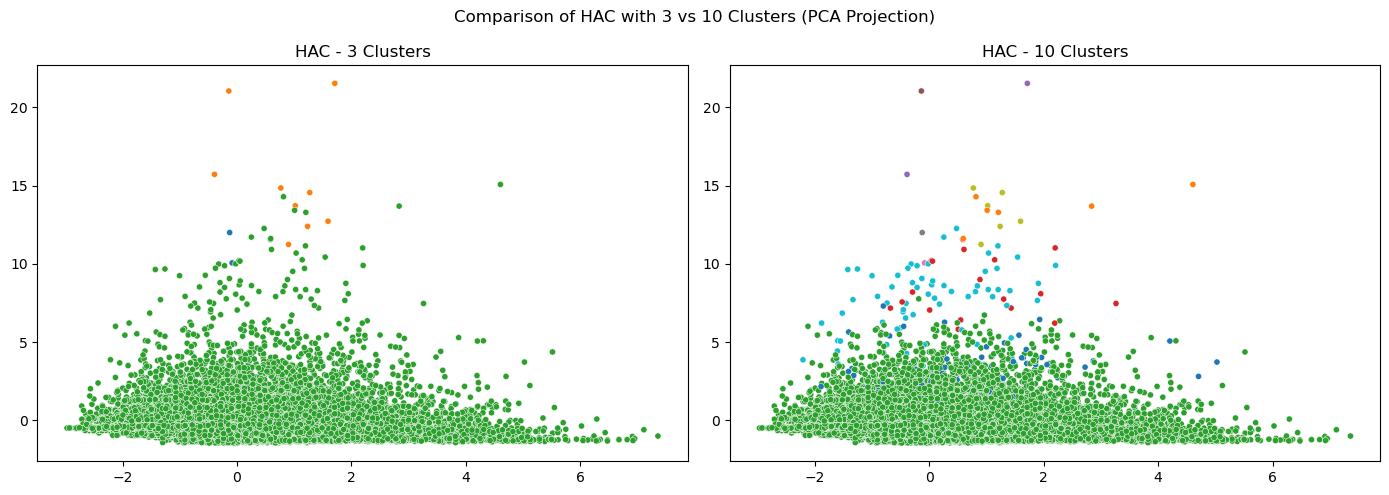

In [63]:
# PCA visualization
# Fit PCA on the sample
pca = PCA(n_components=2)
X_sample_pca = pca.fit_transform(X_sample)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.scatterplot(x=X_sample_pca[:, 0], y=X_sample_pca[:, 1],
                hue=labels_3, palette='tab10', s=20, ax=axes[0], legend=False)
axes[0].set_title("HAC - 3 Clusters")

sns.scatterplot(x=X_sample_pca[:, 0], y=X_sample_pca[:, 1],
                hue=labels_10, palette='tab10', s=20, ax=axes[1], legend=False)
axes[1].set_title("HAC - 10 Clusters")

plt.suptitle("Comparison of HAC with 3 vs 10 Clusters (PCA Projection)")
plt.tight_layout()
plt.show()

Observations:
- PCA plots don't reveal much.
- In both the 3 and 10 cluster sets, there appears to be one very large cluster.
- Both cluster sets show some outlier clusters with somewhat more interesting patterns in the 10 cluster plot.

#### Check HAC Cluster Sizes

We compare how many patients fall into each cluster for both the 3- and 10-cluster models.

In [64]:
# Compare cluster sizes
print("Cluster sizes for HAC (3 clusters):")
print(pd.Series(labels_3).value_counts().sort_index())

print("\nCluster sizes for HAC (10 clusters):")
print(pd.Series(labels_10).value_counts().sort_index())

Cluster sizes for HAC (3 clusters):
0        2
1        9
2    19989
Name: count, dtype: int64

Cluster sizes for HAC (10 clusters):
0       68
1        6
2    19831
3       18
4        2
5        1
6        1
7        1
8        6
9       66
Name: count, dtype: int64


Cluster sizes suggest that even with 10 clusters, most patients fall into a dominant group, with a long tail of smaller clusters.

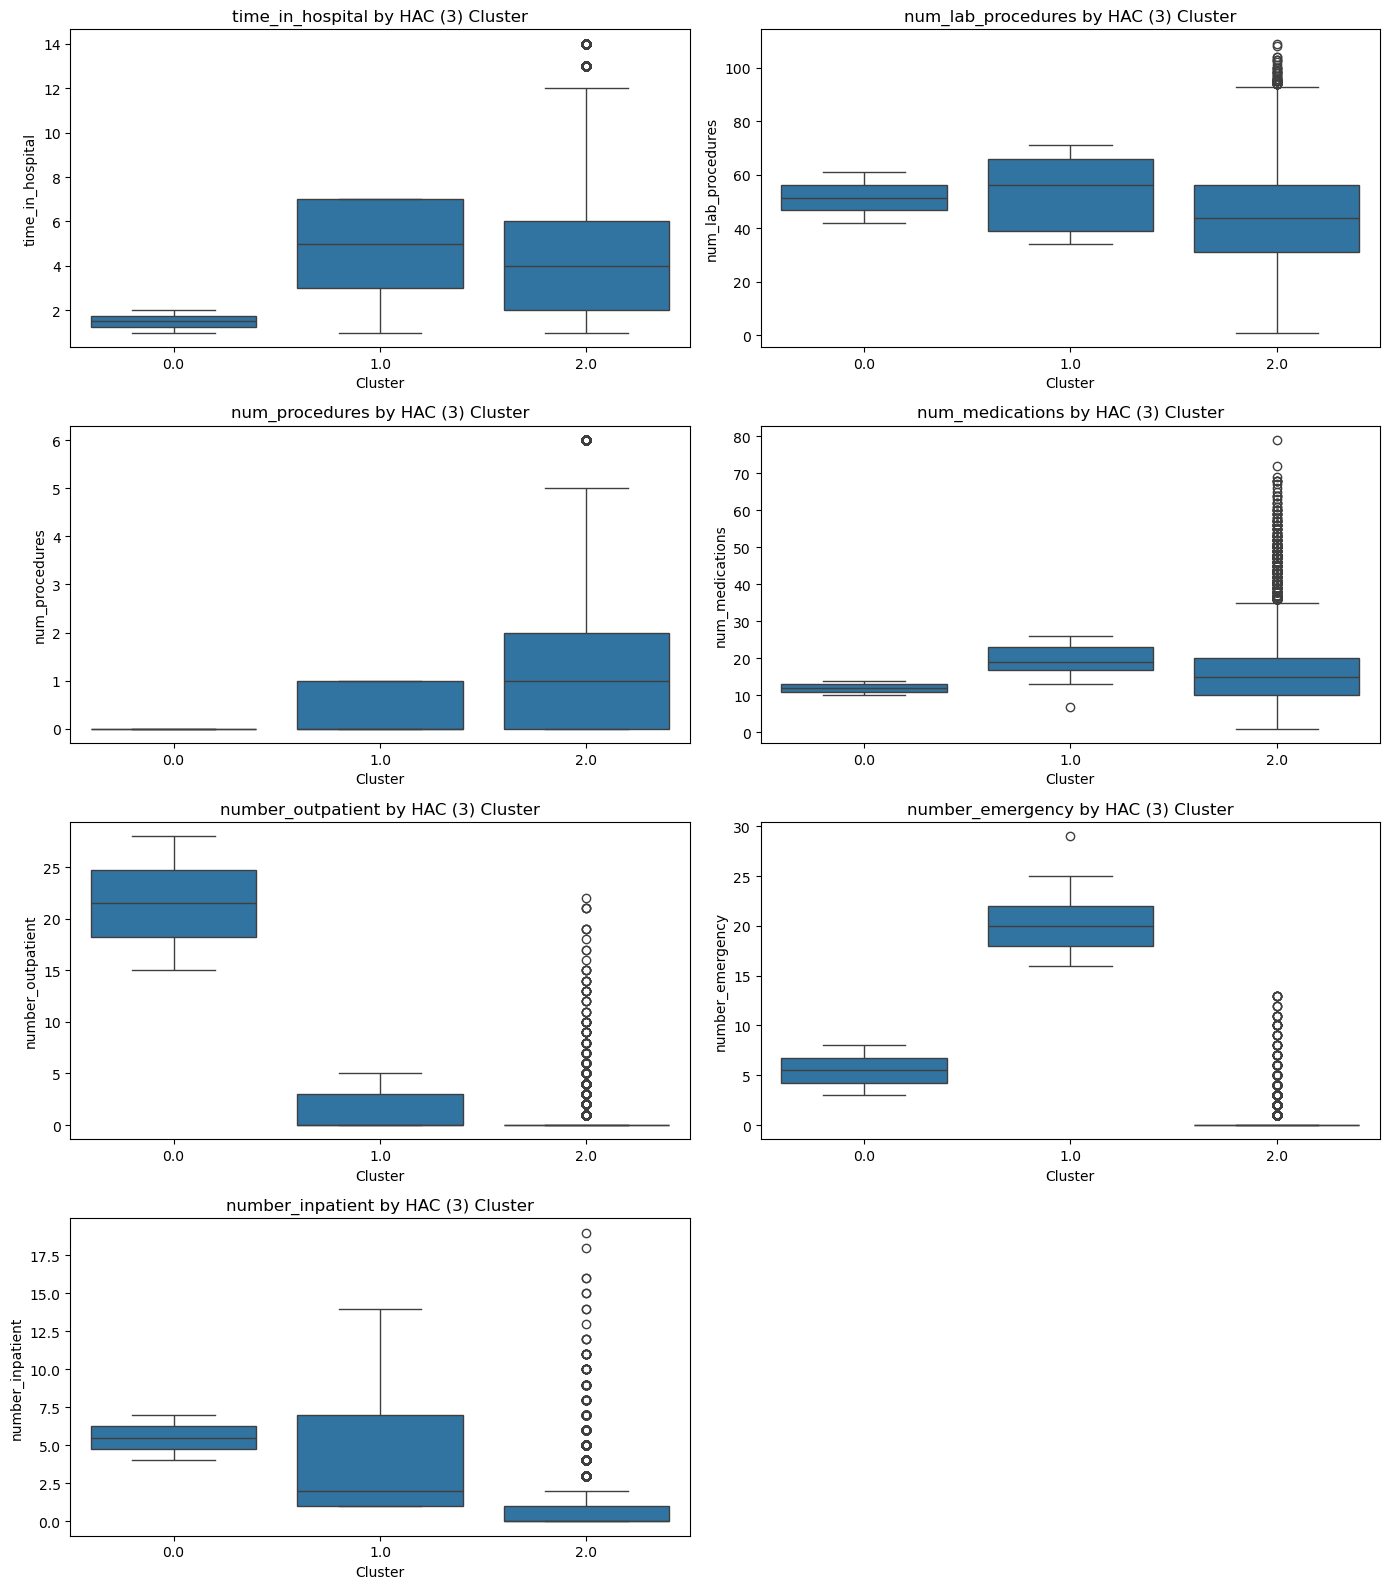

In [65]:
# Boxplots of resource use per HAC cluster
cluster_col = 'cluster_hac3_resource'

# Only include sampled rows (HAC was fit on X_sample only)
hac_mask = df_clustered[cluster_col].notna()

n = len(resource_features)
n_cols = 2
n_rows = (n + 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 4))
axes = axes.flatten()

for i, feature in enumerate(resource_features):
    sns.boxplot(data=df_clustered[hac_mask], x=cluster_col, y=feature, ax=axes[i])
    axes[i].set_title(f"{feature} by HAC (3) Cluster")
    axes[i].set_xlabel("Cluster")
    axes[i].set_ylabel(feature)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Observations:
- Remembering that nearly all the observations are in Cluster 2, the other 2 clusters seem to have distinct outliers, which may be helpful for classification.
- Cluster 0 has the shortest length of stay, all 2 days or less. They have a much higher number of outpatient visits. The number of procedures is also very low, though the number of lab procedures is comparable to the other clusters.
- Cluster 1 has a much higher number of emergency visits than the other clusters.

#### Readmission Patterns by HAC Cluster (3 Clusters)

Again, to explore potential outcome differences between groups, we look at the readmission proportions by cluster.

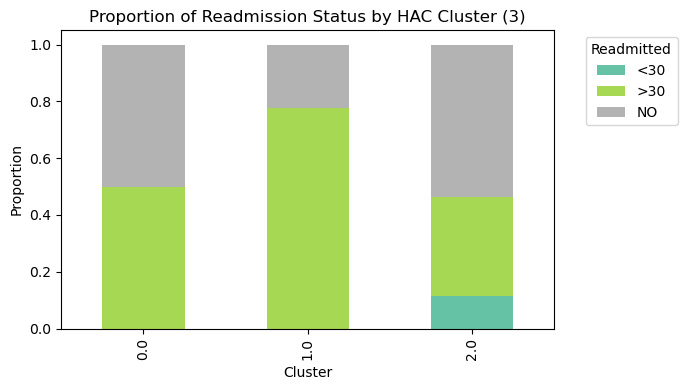

In [66]:
# Readmission breakdown per HAC cluster
readmit_ct = pd.crosstab(df_clustered.loc[hac_mask, cluster_col],
                         df_clustered.loc[hac_mask, 'readmitted'])

readmit_props = readmit_ct.div(readmit_ct.sum(axis=1), axis=0)

# Plot
readmit_props.plot(kind='bar', stacked=True, figsize=(7, 4), colormap='Set2')
plt.title('Proportion of Readmission Status by HAC Cluster (3)')
plt.xlabel('Cluster')
plt.ylabel('Proportion')
plt.legend(title='Readmitted', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Observations: 
- Cluster 2 is the only cluster with early readmission. 
- Though perhaps not useful for a large proportion of the population, this helps define risk for certain edge cases. 
  - Cluster 0: Individuals with hospital stays of 2 days or less, a number of outpatient visits, but very low number of procedures are unlikely to be readmitted early and have equal risk of later or no readmission.
  - Cluster 1: Those with 15+ emergency visits are unlikely to be readmitted early but are very likely to be readmitted later.                                                                                      

#### Truncated Dendrogram

We use a truncated dendrogram to visualize the structure of the HAC. This plot shows only the last 20 merges using the `average` linkage method. It focuses on the largest groupings near the top of the tree rather than showing all individual merges from bottom-up.

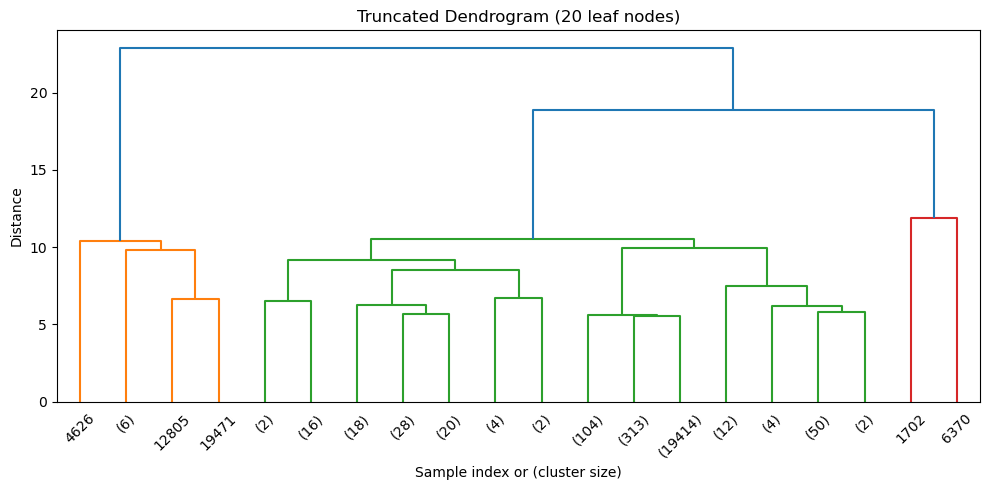

In [67]:
# Maybe try to plot the dendrogram

Z = linkage(X_sample, method='average')  # or 'ward', 'complete'
plt.figure(figsize=(10, 5))
dendrogram(Z, truncate_mode='lastp', p=20, leaf_rotation=45, leaf_font_size=10)
plt.title("Truncated Dendrogram (20 leaf nodes)")
plt.xlabel("Sample index or (cluster size)")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

Interpretation:
- Tick marks without parentheses = individual points or small clusters
- Tick marks with parentheses = merged clusters, with the number of samples in the group

Most merges happen at low distances, forming one large, dense cluster. The remaining two clusters (in the 3-cluster solution) merged in later at higher distances, suggesting they are smaller and more distinct, which matches our earlier HAC result.

To explore more, we may want to isolate the large cluster and re-run HAC to see if additional, finer-grained subtypes within the dominant cluster.

#### Compare Clustering Models for Resource Usage: KMeans, DBSCAN, and HAC

To evaluate the clustering results, we compare the models using three different metrics:

- Silhouette Score: Measures how well each point fits within its cluster. Higher values indicate better-defined clusters.
- Adjusted Rand Index (ARI): Measures the agreement between different clustering assignments (accounting for chance). Higher scores mean the two labelings are more similar.
- Cluster Size Distribution: Helps us see whether the models produce well-balanced clusters or very imbalanced ones.

In [68]:
# Compare silhouette scores of clustering models

X = datasets['Resource Only']

silhouette_scores = {
    'KMeans': silhouette_score(X, df_clustered['cluster_kmeans_resource']),
    'DBSCAN': silhouette_score(
        X[df_clustered['cluster_dbscan_resource'] != -1],
        df_clustered.loc[df_clustered['cluster_dbscan_resource'] != -1, 'cluster_dbscan_resource']
    ),
    'HAC': silhouette_score(X_sample, df_clustered.loc[sample_idx, 'cluster_hac3_resource']),
}

print("Silhouette Scores:")
for method, score in silhouette_scores.items():
    print(f"{method}: {score:.4f}")

Silhouette Scores:
KMeans: 0.2004
DBSCAN: 0.5241
HAC: 0.8272


In [69]:
# Adjusted Rand Index (Pairwise Agreement)

# Use correct label columns
labels_kmeans = df_clustered['cluster_kmeans_resource']
labels_dbscan = df_clustered['cluster_dbscan_resource']
labels_hac = df_clustered['cluster_hac3_resource']  # <- HAC (3 clusters) from sample

# Calculate ARI only on the overlapping sample
sample_mask = df_clustered['cluster_hac3_resource'].notna()

ari_scores = {
    'KMeans vs DBSCAN': adjusted_rand_score(
        labels_kmeans[sample_mask],
        labels_dbscan[sample_mask]
    ),
    'KMeans vs HAC': adjusted_rand_score(
        labels_kmeans[sample_mask],
        labels_hac[sample_mask]
    ),
    'HAC vs DBSCAN': adjusted_rand_score(
        labels_hac[sample_mask],
        labels_dbscan[sample_mask]
    ),
}

print("\nAdjusted Rand Index (ARI) on HAC sample:")
for pair, score in ari_scores.items():
    print(f"{pair}: {score:.4f}")


Adjusted Rand Index (ARI) on HAC sample:
KMeans vs DBSCAN: 0.0022
KMeans vs HAC: 0.0005
HAC vs DBSCAN: 0.3917


In [70]:
# Compare cluster size distributions
print("\nCluster Sizes:")
print("KMeans:\n", labels_kmeans.value_counts().sort_index())
print("\nDBSCAN:\n", labels_dbscan.value_counts().sort_index())  # Includes -1 (noise)
print("\nHAC (sample only):\n", labels_hac.value_counts().sort_index())


Cluster Sizes:
KMeans:
 cluster_kmeans_resource
0     4100
1     6451
2    34026
3    12924
4     5627
5        7
6    19116
7      884
8      285
9    18346
Name: count, dtype: int64

DBSCAN:
 cluster_dbscan_resource
-1       216
 0    101530
 1        10
 2         4
 3         6
Name: count, dtype: int64

HAC (sample only):
 cluster_hac3_resource
0.0        2
1.0        9
2.0    19989
Name: count, dtype: int64


### Interpretation of Cluster Results on the Resource Use Features

Among the three clustering methods we tested, HAC had the highest silhouette score (0.83), which suggests the clusters were well separated from one another. However, it only created one very large cluster and two extremely small ones. It’s likely that the high score reflects how far apart these clusters were, rather than their usefulness for identifying structure in the data.

DBSCAN also had a relatively high silhouette score (0.52) and identified a few small noise clusters, but most points were placed in a single dominant cluster. Like HAC, this doesn’t seem to give much insight into different patterns of resource use.

K-Means had a much lower silhouette score (0.20), which may suggest the clusters weren’t as compact or clearly separated. However, it produced a wider range of cluster sizes and seemed to reflect more variety in the data. While not perfect, it gave more interpretable groupings compared to HAC and DBSCAN.

The ARI values showed that the clustering methods gave very different results. K-Means didn’t agree much with HAC or DBSCAN. HAC and DBSCAN had a bit more overlap, but they still produced different clusters overall.

In terms of cluster sizes, K-Means provided a more balanced distribution, while HAC and DBSCAN both grouped almost everything into one cluster. Given that, K-Means seems like the most reasonable choice if we use the clustering results as features in a future classification model.

### Clustering Based on Care Context Features

In this section, we explore clustering based on how and where patients enter and receive care. These features represent the administrative-level context in which care is given:

- admission_source_id
- medical_specialty
- payer_code

This set of features helps answer questions like:

- Are patients entering the system through emergency or elective admissions?
- Are they being seen by general practitioners or specialists?
- Are there meaningful differences between those with public vs. private insurance?

Understanding these patterns could offer insight into how care varys across patient groups and how healthcare access shape outcomes.

### Data Preparation

#### Subset and Preprocess the Data

We processed the data by one-hot encoding the categorical variables and scaling all features.

In [71]:
# Copy the dataset
df_clustered = df_clean.copy()

# Define care context features
context_features = ['admission_source_id', 'medical_specialty', 'payer_code']

# Create the dataset
df_context = df_clustered[context_features].copy()

# One-hot encode categorical features
df_context_encoded = pd.get_dummies(df_context, drop_first=True)

# Scale the encoded features
scaler_context = StandardScaler()
X_context_scaled = scaler_context.fit_transform(df_context_encoded)

# Store in dictionary like before
datasets['Care Context'] = X_context_scaled

# Check the number of encoded features for context in determining k
print("Number of features in Care Context dataset:", X_context_scaled.shape[1])

Number of features in Care Context dataset: 105


### Modeling and Evaluation

#### Choosing 'k' for K-Means: Elbow and Silhouette Plots

We ran K-Means with a range of values for `k` and examined:

- And Elbow plot to track reduction in SSE  
- Silhouette scores to evaluate cluster cohesion/separation  

We started with a higher range for this dataset because of the number of encoded features, while wanting to choose something manageable.

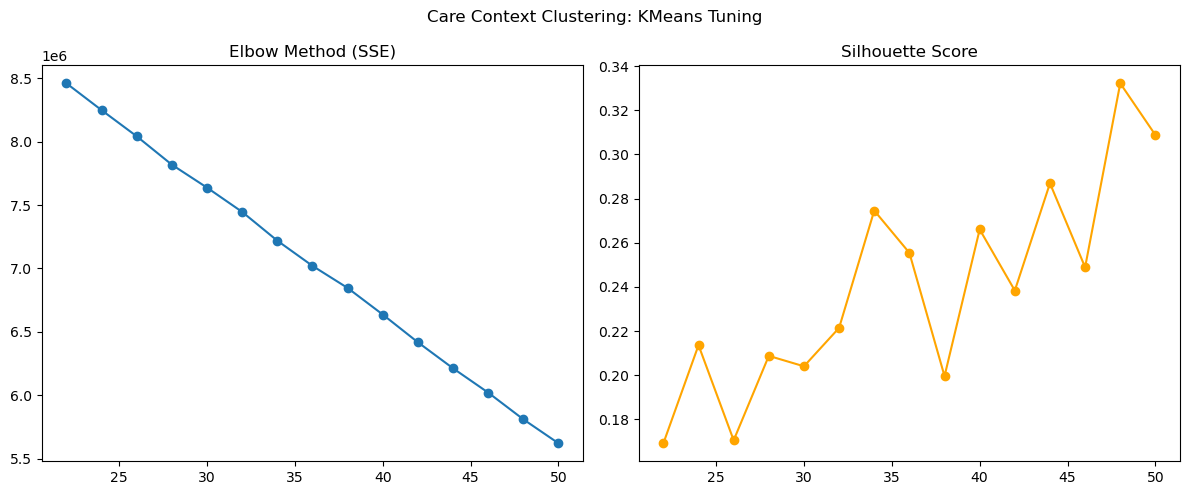

KMeans time: 12.33 minutes


In [72]:
sse = []
sil_scores = []
K_range = range(22, 52, 2)

start_time = time.time()

for k in K_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=5, random_state=1234)
    labels = kmeans.fit_predict(X_context_scaled)
    sse.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_context_scaled, labels))

# Plot
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(K_range, sse, marker='o')
ax[0].set_title('Elbow Method (SSE)')
ax[1].plot(K_range, sil_scores, marker='o', color='orange')
ax[1].set_title('Silhouette Score')
plt.suptitle('Care Context Clustering: KMeans Tuning')
plt.tight_layout()
plt.show()

print(f"KMeans time: {(time.time() - start_time)/60:.2f} minutes")

There isn't a clear "elbow" because the SSE continues to decline with increasing $k$. Silhouette scores increased steadily and peaked at a few points, so we chose to compare points with higher silhouette scores.

In [73]:
# Use scaled care context data
X = datasets['Care Context']

# List of k values to try
k_values = [34] # [34, 44, 48]

# Loop through each k and fit KMeans
for k in k_values:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=1234, n_init=10)
    labels = kmeans.fit_predict(X)
    
    col_name = f'cluster_kmeans_care_{k}'
    df_clustered[col_name] = labels

    # Sort by cluster size instead of index
    cluster_counts = df_clustered[col_name].value_counts().sort_values(ascending=False)
    
    print(f"\nCluster Sizes for k = {k} (sorted by size):")
    print(cluster_counts)

# Assign cluster labels to dataset
df_clustered['cluster_kmeans_care'] = df_clustered['cluster_kmeans_care_34']


Cluster Sizes for k = 34 (sorted by size):
cluster_kmeans_care_34
11    29031
3     18921
10    14128
1      7477
7      7449
0      5562
9      5323
5      3092
8      1609
15     1394
2      1231
24     1138
25      871
30      684
6       658
17      652
27      543
14      391
12      348
32      254
19      203
16      159
23      120
4       109
21      100
18       98
28       87
29       82
13       25
31       17
33        4
20        3
26        2
22        1
Name: count, dtype: int64


We selected `k = 34` because:
- It had one of the highest silhouette scores in our tested range  
- The cluster size distribution looked reasonable:
  - Several large clusters (5K–29K members)  
  - A range of mid-sized clusters  
  - Only a few very small clusters (under 10 members)  

#### PCA and t-SNE Visualizations

We used PCA and t-SNE to reduce the care context features to 2 dimensions for cluster visualization.

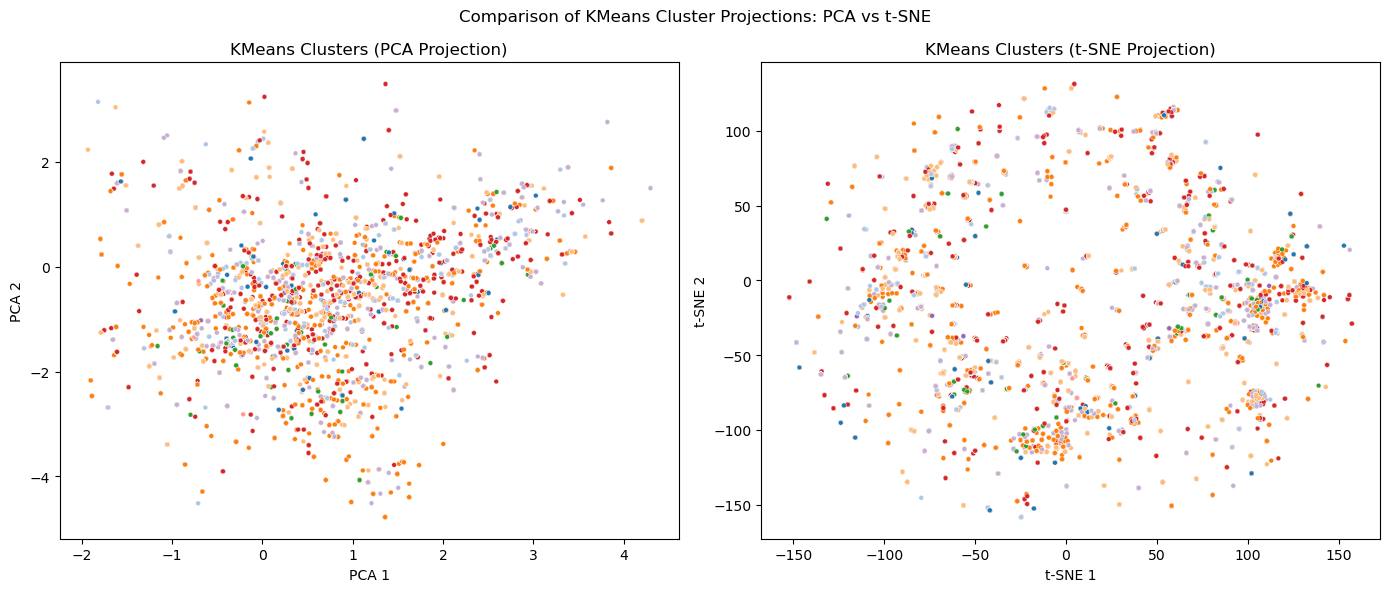

In [74]:
# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(datasets['Care Context'])

# t-SNE (this can take time for large datasets)
tsne = TSNE(n_components=2, perplexity=30, random_state=1234, max_iter=1000)
X_tsne = tsne.fit_transform(datasets['Care Context'])

# Side-by-side plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# PCA scatter
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=kmeans_labels,
                palette='tab20', s=12, ax=axes[0], legend=False)
axes[0].set_title("KMeans Clusters (PCA Projection)")
axes[0].set_xlabel("PCA 1")
axes[0].set_ylabel("PCA 2")

# t-SNE scatter
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=kmeans_labels,
                palette='tab20', s=12, ax=axes[1], legend=False)
axes[1].set_title("KMeans Clusters (t-SNE Projection)")
axes[1].set_xlabel("t-SNE 1")
axes[1].set_ylabel("t-SNE 2")

plt.suptitle("Comparison of KMeans Cluster Projections: PCA vs t-SNE")
plt.tight_layout()
plt.show()

Neither PCA nor t-SNE shows strong separation between clusters. Since we're reducing over 100 original features down to just two dimensions, it’s not surprising that these plots may miss important structure. 

#### Readmission Patterns by Cluster

We examined the proportion of patients with different readmission statuses across the clusters.

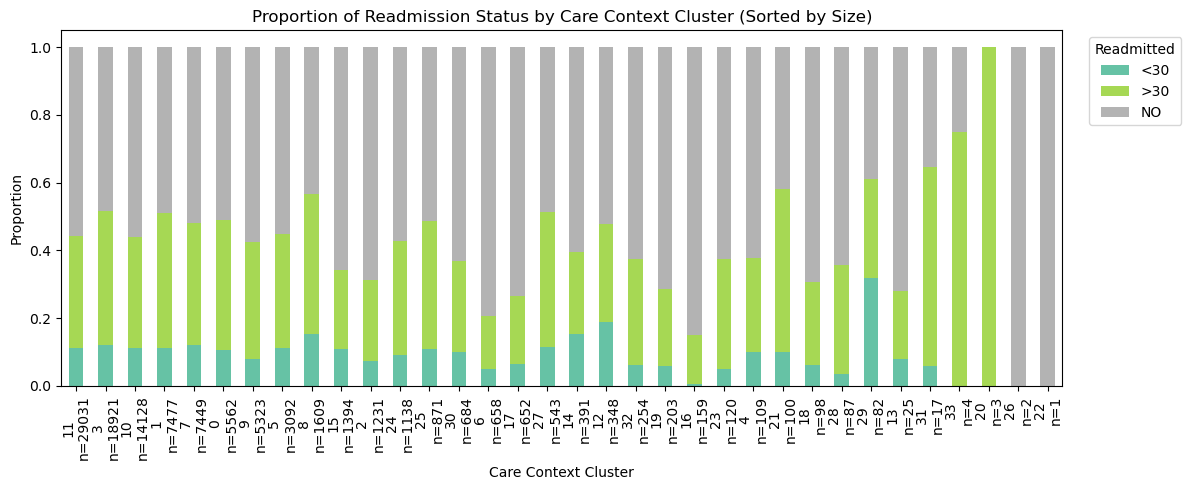

In [75]:
# Sort clusters by size
cluster_sizes = df_clustered['cluster_kmeans_care'].value_counts().sort_values(ascending=False)
sorted_clusters = cluster_sizes.index

# Cross-tab and normalize
readmit_ct = pd.crosstab(df_clustered['cluster_kmeans_care'], df_clustered['readmitted'])
readmit_ct = readmit_ct.loc[sorted_clusters]  # Sort by cluster size
readmit_props = readmit_ct.div(readmit_ct.sum(axis=1), axis=0)

# Create label with sample size
cluster_labels = [f"{idx}\nn={cluster_sizes[idx]}" for idx in sorted_clusters]

# Plot
readmit_props.index = cluster_labels  # Use annotated index
readmit_props.plot(kind='bar', stacked=True, figsize=(12, 5), colormap='Set2')

plt.title('Proportion of Readmission Status by Care Context Cluster (Sorted by Size)')
plt.xlabel('Care Context Cluster')
plt.ylabel('Proportion')
plt.xticks(rotation=90)
plt.legend(title='Readmitted', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

Clusters were sorted by size and labeled with patient counts.

Observations:
- Most clusters have a similar mix of readmission outcomes.
- The smallest clusters with $n < 10$ have only patients that were readmitted later or not readmitted.
- Cluster 29 ($n=82$) has a high proportion of early readmissions.

#### Cluster Characteristics by Feature

To better understand the clusters, we plotted the proportion of patients within each cluster that fall into specific categories for:

- Admission source
- Medical specialty
- Payer code

These features were originally one-hot encoded (i.e. 0/1 dummy variables), so taking the mean of each feature within a cluster gives the proportion of patients in that cluster with that attribute.

The heatmaps highlight if feature categories are common in certain clusters.

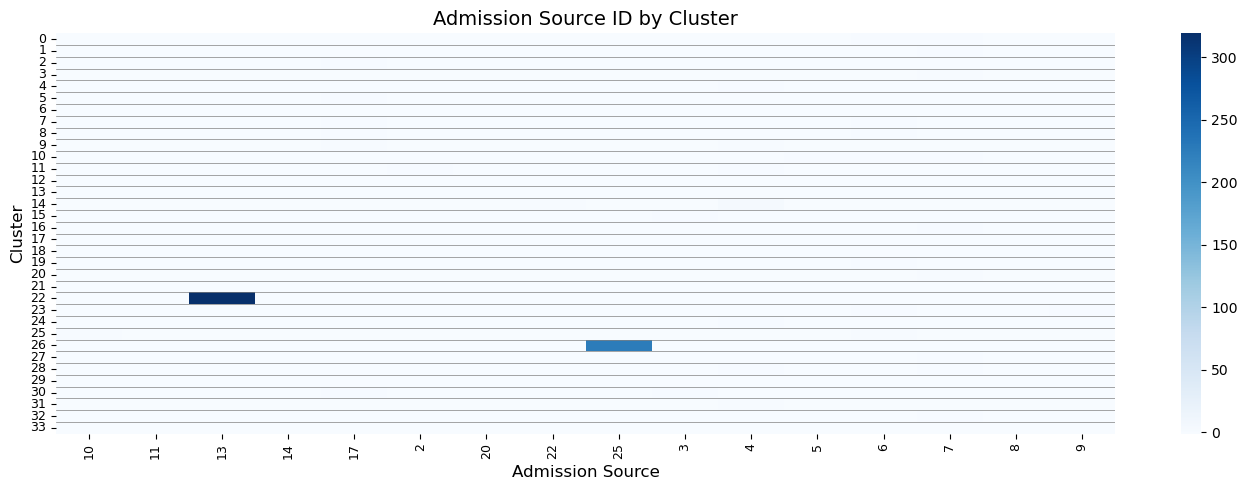

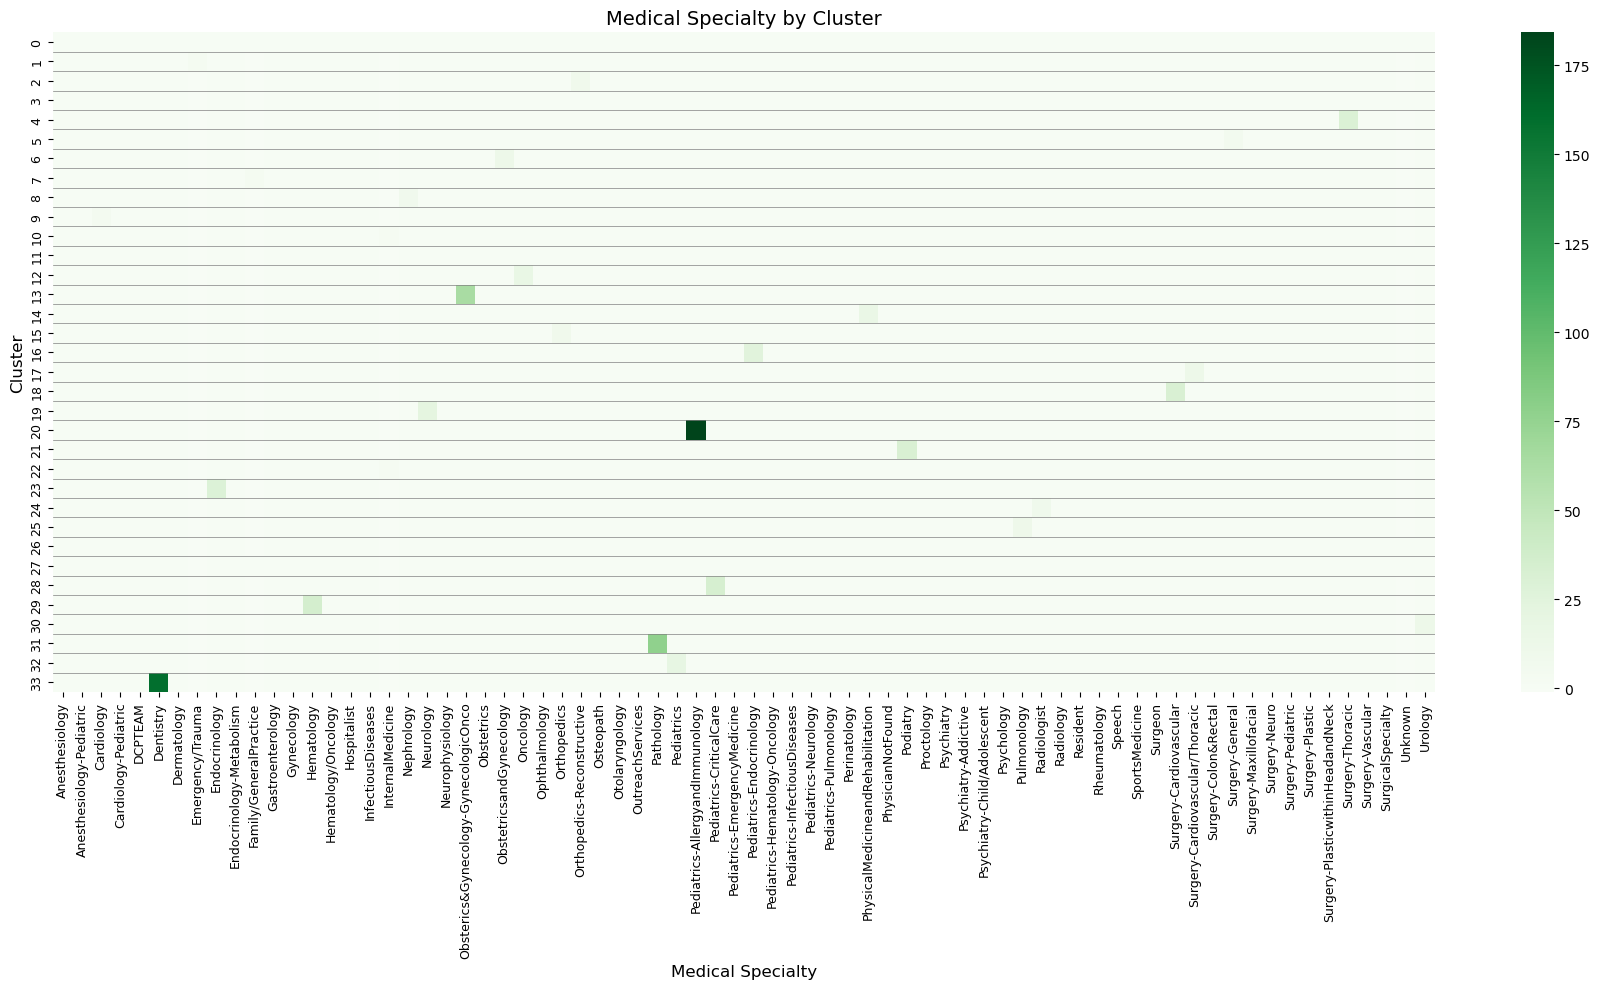

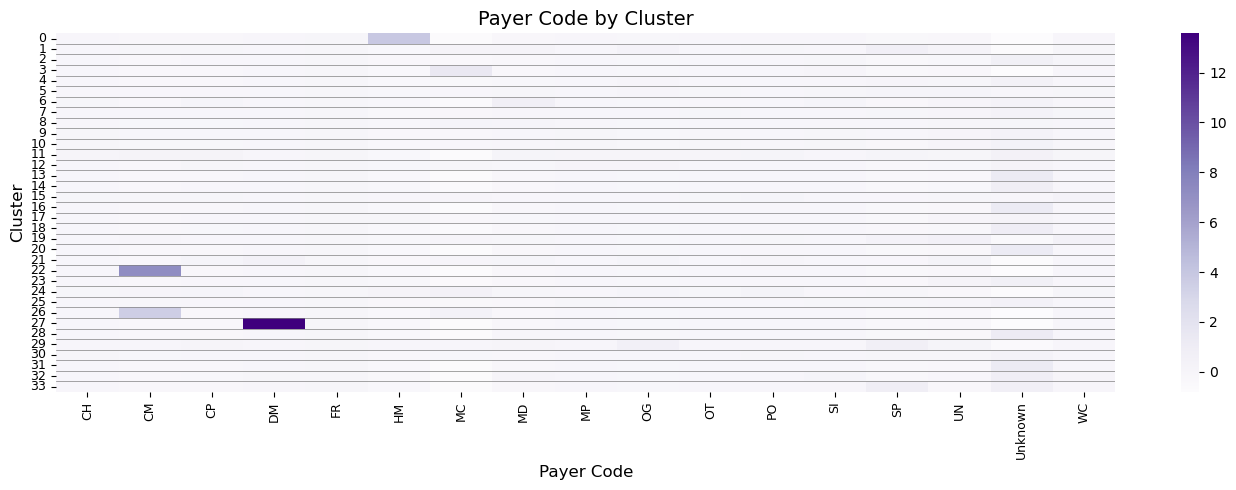

In [76]:
# Rebuild the DataFrame with correct column names
X_encoded = pd.DataFrame(X, columns=df_context_encoded.columns)

# Add the KMeans care context cluster labels
X_encoded['cluster'] = df_clustered['cluster_kmeans_care']

# Calculate average of each feature by cluster
cluster_feature_means = X_encoded.groupby('cluster').mean()

# Re-define your column groups
admission_cols = [col for col in cluster_feature_means.columns if col.startswith('admission_source_id')]
specialty_cols = [col for col in cluster_feature_means.columns if col.startswith('medical_specialty')]
payer_cols = [col for col in cluster_feature_means.columns if col.startswith('payer_code')]

def plot_heatmap_horizontal_lines(data, title, xlabel, col_prefix, cmap='Blues', figsize=(14,5)):
    plt.figure(figsize=figsize)
    
    # Create heatmap with no built-in lines
    ax = sns.heatmap(
        data,
        cmap=cmap,
        cbar=True,
        xticklabels=[col.replace(col_prefix, '') for col in data.columns],
        yticklabels=True,
        linewidths=0,  # no built-in grid lines
        linecolor='white'
    )
    
    # Add horizontal lines manually
    for y in range(1, data.shape[0]):
        ax.axhline(y=y, color='gray', linestyle='-', linewidth=0.5)

    ax.set_title(title, fontsize=14)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel("Cluster", fontsize=12)
    plt.xticks(rotation=90, fontsize=9)
    plt.yticks(fontsize=9)
    plt.tight_layout()
    plt.show()

# Plot: Admission Source
plot_heatmap_horizontal_lines(cluster_feature_means[admission_cols],
                              title="Admission Source ID by Cluster",
                              xlabel="Admission Source",
                              col_prefix='admission_source_id_',
                              cmap='Blues')

# Plot: Medical Specialty
plot_heatmap_horizontal_lines(cluster_feature_means[specialty_cols],
                              title="Medical Specialty by Cluster",
                              xlabel="Medical Specialty",
                              col_prefix='medical_specialty_',
                              cmap='Greens',
                              figsize=(18, 10))

# Plot: Payer Code
plot_heatmap_horizontal_lines(cluster_feature_means[payer_cols],
                              title="Payer Code by Cluster",
                              xlabel="Payer Code",
                              col_prefix='payer_code_',
                              cmap='Purples')

These data are fairly sparse overall, but there are a few patterns where certain features levels are highly concentrated within specific clusters:

- Admission Source
  - Code `13` (13: Sick Baby) is prevalent in Cluster 22
  - Code `25` (25: Transfer from Ambulatory Surgery Center) appears frequently in Cluster 26

- Medical Specialty
  - Dentistry is nearly exclusive to Cluster 33
  - Pediatric Allergy & Immunology is concentrated in Cluster 20
  - OB/Gyn Oncology is prevalent in Cluster 13
  - Pathology is highly represented in Cluster 31

- Payer Code
  - `DM` is nearly all in Cluster 27
  - `CM` is split between Clusters 22 and 26
  - `HM` is largely concentrated in Cluster 0

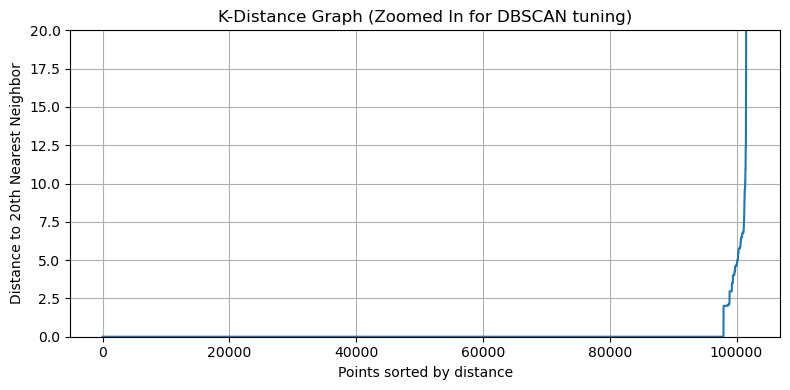

In [77]:
X_care = datasets['Care Context']  # already scaled

k = 20  # Reasonable starting point for high-dimensional, encoded categorical data
nn = NearestNeighbors(n_neighbors=k)
nn_fit = nn.fit(X_care)
distances, indices = nn_fit.kneighbors(X_care)

# Get distances to the k-th nearest neighbor
k_distances = np.sort(distances[:, k-1])  # index k-1 because it's 0-based

# Plot the sorted distances
plt.figure(figsize=(8, 4))
plt.plot(k_distances)
plt.ylim(0, 20)  # zoom in to focus on the low-distance region
plt.title("K-Distance Graph (Zoomed In for DBSCAN tuning)")
#plt.title("K-Distance Graph")
plt.xlabel("Points sorted by distance")
plt.ylabel(f"Distance to {k}th Nearest Neighbor")
plt.grid(True)
plt.tight_layout()
plt.show()

#### DBSCAN: K-Distance Plot

We used a k-distance graph to help tune the `eps` parameter. For each point, we plotted the distance to its 20th nearest neighbor.

We chose 20 as a starting point for min_samples (the number of points required to be a core point), because in high-dimensional datasets, values between 10 and 20 are a common rule of thumb.

The curve starts increasing steeply around eps = 3. We used that as a guideline for a grid search across different combinations of eps and min_samples.

#### Grid Search for eps and minPts

We performed a grid search over a range of `eps` and `min_samples` values and calculated metrics for each combination:
- Number of clusters
- Number of noise points
- Silhouette score (calculated from a random sample of 5,000 points for efficiency)

In [78]:
# Grid search for best eps and minpts based on the elbow from the k-neighbors plot

print("\n--- DBSCAN Grid Search Results ---")

results = []
best_score = -1
best_config = None

start_time = time.time()

for eps in [3, 4, 5]: # also tried 2, 6, 7
    for min_samples in [10, 20, 30, 40, 50]: # also tried 5, 35, 75, 100
        db = DBSCAN(eps=eps, min_samples=min_samples)
        labels = db.fit_predict(X_care)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = np.sum(labels == -1)

        if n_clusters > 1 and n_noise < len(X_care):
            score = silhouette_score(X_care, labels, sample_size=5000, random_state=1234)
            results.append({
                'eps': eps,
                'min_samples': min_samples,
                'n_clusters': n_clusters,
                'n_noise': n_noise,
                'silhouette': score
            })
            if score > best_score:
                best_score = score
                best_config = (eps, min_samples)

results_df = pd.DataFrame(results)
print(results_df.sort_values('silhouette', ascending=False))

print(f"DBSCAN time: {(time.time() - start_time)/60:.2f} minutes")


--- DBSCAN Grid Search Results ---
    eps  min_samples  n_clusters  n_noise  silhouette
0     3           10         256     1605    0.564898
1     3           20         191     2493    0.553727
2     3           30         151     3486    0.537051
3     3           40         127     4295    0.531001
4     3           50         110     5036    0.527430
5     4           10         236     1520    0.488009
6     4           20         175     2347    0.476311
7     4           30         139     3240    0.464484
8     4           40         115     4049    0.458284
9     4           50         100     4699    0.455146
10    5           10         142     1030    0.430576
11    5           20         105     1545    0.426509
12    5           30          82     2100    0.422561
13    5           40          68     2571    0.420988
14    5           50          62     2842    0.417279
DBSCAN time: 5.08 minutes


#### Filtered Results

We filtered the results for DBSCAN configurations that:
- Had reasonably high silhouette scores $\geq$ 0.40
- Produced a manageable number clusters of between 50 and 150
- Labeled fewer than 10,000 points as noise, < 10% of the dataset


--- Reasonable DBSCAN Configurations ---
    eps  min_samples  n_clusters  n_noise  silhouette
3     3           40         127     4295    0.531001
4     3           50         110     5036    0.527430
7     4           30         139     3240    0.464484
8     4           40         115     4049    0.458284
9     4           50         100     4699    0.455146
10    5           10         142     1030    0.430576
11    5           20         105     1545    0.426509
12    5           30          82     2100    0.422561
13    5           40          68     2571    0.420988
14    5           50          62     2842    0.417279


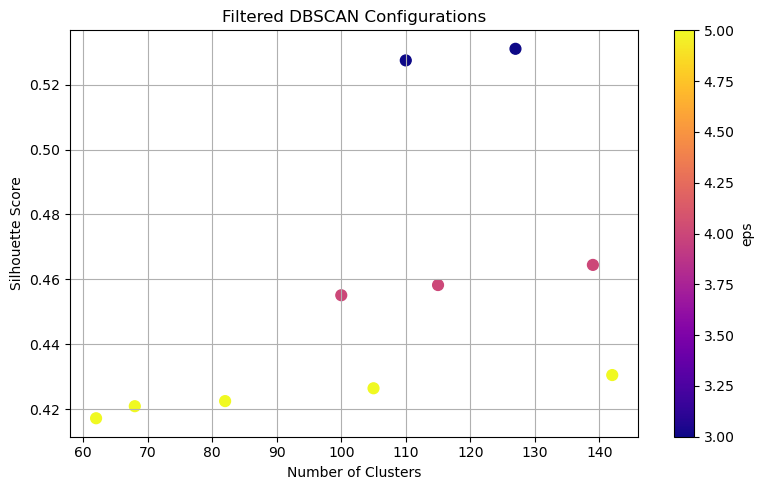

In [79]:
# Heuristic filtering
reasonable = results_df[
    (results_df['silhouette'] >= 0.4) &
    (results_df['n_clusters'] >= 50) & 
    (results_df['n_clusters'] <= 150) & 
    (results_df['n_noise'] < 10000)  # adjust but baseline of ~10% of data
]

# Sort by silhouette score descending
reasonable_sorted = reasonable.sort_values(by='silhouette', ascending=False)

print("\n--- Reasonable DBSCAN Configurations ---")
print(reasonable_sorted)

# Plot tradeoff for reasonable configs
plt.figure(figsize=(8, 5))
plt.scatter(reasonable_sorted['n_clusters'], reasonable_sorted['silhouette'],
            c=reasonable_sorted['eps'], cmap='plasma', s=60)
plt.colorbar(label='eps')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Filtered DBSCAN Configurations")
plt.grid(True)
plt.tight_layout()
plt.show()

These thresholds helped narrow down configurations. This scatterplot helped show the trade-off between silhouette score and number of clusters.

#### Fit Models and Compare Clustering with PCA and Cluster Sizes

We fit two DBSCAN models using configurations from our earlier grid search.
- Config A: eps=4, min_samples=30 (from a previous grid search)
  - clusters:139
  - noise:3240
  - SS:0.446
  - more noise, better separation
- Config B: eps=5, min_samples=10
  - clusters:142
  - noise:1030
  - SS:0.431
  - less noise, but less separation

Again, we used PCA to project the data into 2-D and then colored the points by their cluster assignments to aid in visualizing the clustering results. The two clustering configurations are plotted side-by-side.

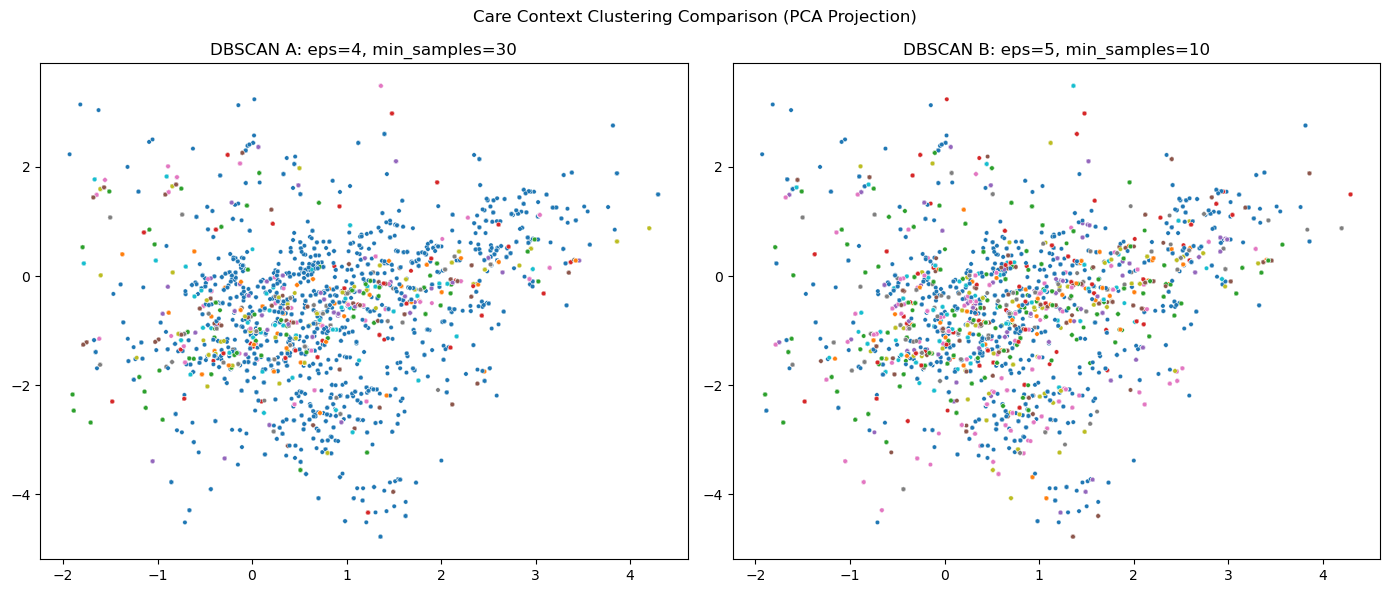

In [80]:
# DBSCAN Config A: eps=4, min_samples=30 (clusters:139, noise:3240, SS:0.446; more noise, better separation, from a previous grid search)
db_a = DBSCAN(eps=4, min_samples=30)
labels_a = db_a.fit_predict(X_care)
df_clustered['cluster_dbscan_care_a'] = labels_a

# DBSCAN Config B: eps=5, min_samples=10 (clusters:142, noise:1030, SS:0.431; less noise, but less separation)
db_b = DBSCAN(eps=5, min_samples=10)
labels_b = db_b.fit_predict(X_care)
df_clustered['cluster_dbscan_care_b'] = labels_b

# PCA for visualization
pca = PCA(n_components=2)
X_care_pca = pca.fit_transform(X_care)

# Plot side-by-side PCA results
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(x=X_care_pca[:, 0], y=X_care_pca[:, 1], hue=labels_a,
                palette='tab10', s=10, ax=axes[0], legend=False)
axes[0].set_title('DBSCAN A: eps=4, min_samples=30')

sns.scatterplot(x=X_care_pca[:, 0], y=X_care_pca[:, 1], hue=labels_b,
                palette='tab10', s=10, ax=axes[1], legend=False)
axes[1].set_title('DBSCAN B: eps=5, min_samples=10')

plt.suptitle("Care Context Clustering Comparison (PCA Projection)")
plt.tight_layout()
plt.show()

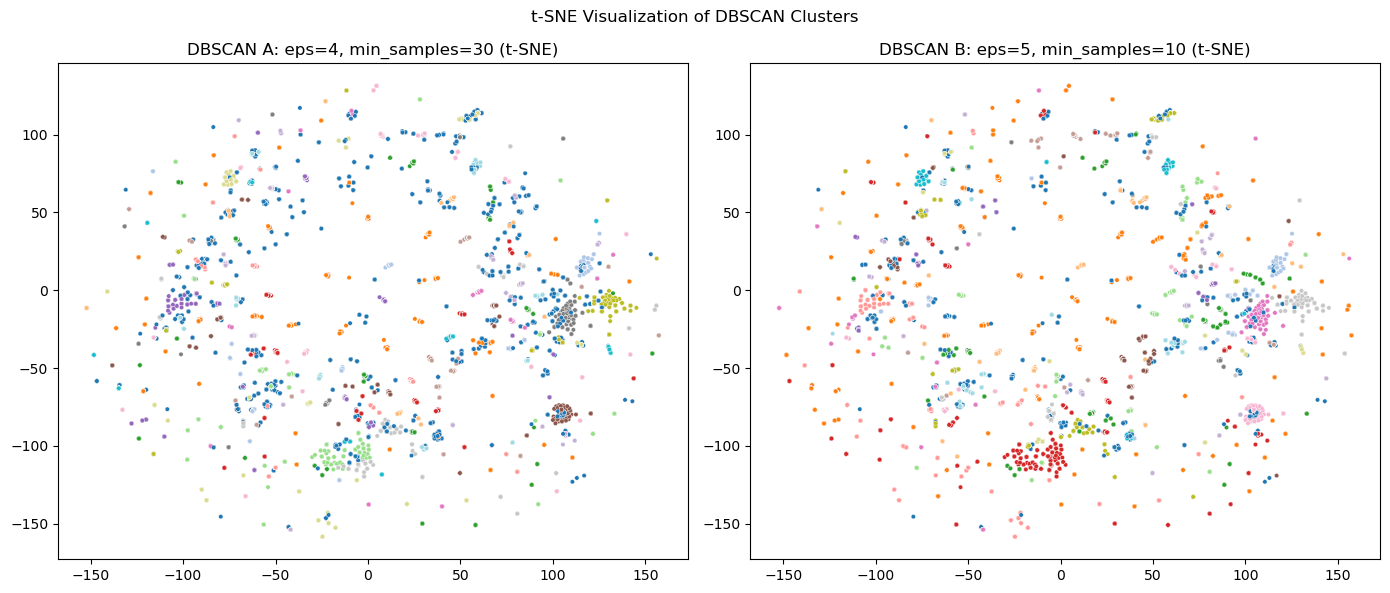

In [81]:
# t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=1234, max_iter=1000)
X_tsne = tsne.fit_transform(X_care)

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=labels_a,
                palette='tab20', s=10, ax=axes[0], legend=False)
axes[0].set_title("DBSCAN A: eps=4, min_samples=30 (t-SNE)")

sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=labels_b,
                palette='tab20', s=10, ax=axes[1], legend=False)
axes[1].set_title("DBSCAN B: eps=5, min_samples=10 (t-SNE)")

plt.suptitle("t-SNE Visualization of DBSCAN Clusters")
plt.tight_layout()
plt.show()

#### Cluster Size Summary

We also summarized the distribution of cluster sizes for each configuration.  

In [82]:
def summarize_cluster_sizes(label_series, config_name):
    sizes = pd.Series(label_series).value_counts()
    sizes = sizes[sizes.index != -1]  # Exclude noise
    print(f"\nSummary for {config_name}")
    print(f"Number of Clusters: {len(sizes)}")
    print(f"Min Size: {sizes.min()}")
    print(f"Max Size: {sizes.max()}")
    print(f"Median Size: {sizes.median()}")
    print(f"Mean Size: {sizes.mean():.2f}")

summarize_cluster_sizes(labels_a, "Config A (eps=4, min_samples=30)")
summarize_cluster_sizes(labels_b, "Config B (eps=5, min_samples=10)")


Summary for Config A (eps=4, min_samples=30)
Number of Clusters: 139
Min Size: 30
Max Size: 50259
Median Size: 92.0
Mean Size: 708.82

Summary for Config B (eps=5, min_samples=10)
Number of Clusters: 142
Min Size: 10
Max Size: 68036
Median Size: 36.5
Mean Size: 709.41


Observations:
- Smaller `min_samples` values (like in Config B) allowed smaller clusters to form.
- Both cluster distributions were right-skewed. 
- However, Config A seemed to strike a better balance, with a narrower range of clusters sizes and a higher median size.

#### Cluster Size Distribution

To get a better look at the distribution of our chosen config, we grouped clusters into size bins.  

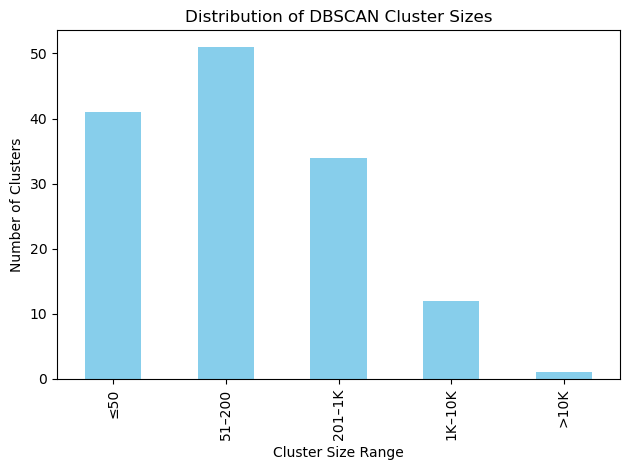

In [83]:
df_clustered['cluster_dbscan_care'] = df_clustered['cluster_dbscan_care_a']

cluster_counts = df_clustered['cluster_dbscan_care'].value_counts()
cluster_counts = cluster_counts[cluster_counts.index != -1]  # exclude noise

bins = [0, 50, 200, 1000, 10000, np.inf]
labels = ['≤50', '51–200', '201–1K', '1K–10K', '>10K']
binned_sizes = pd.cut(cluster_counts, bins=bins, labels=labels)

binned_summary = binned_sizes.value_counts().sort_index()
binned_summary.plot(kind='bar', color='skyblue')
plt.title("Distribution of DBSCAN Cluster Sizes")
plt.xlabel("Cluster Size Range")
plt.ylabel("Number of Clusters")
plt.tight_layout()
plt.show()

#### Readmission Proportions by Cluster Size

To understand whether care context clusters are associated with different readmission outcomes, we visualized the proportions of readmission types within each cluster. To improve readability, we grouped clusters by their size.

- We calculated the number of patients in each cluster (excluding noise) and assigned each cluster to a size bin.
- We created a crosstab of cluster ID by readmission status (`<30`, `>30`, `NO`) and normalized the counts to get proportions.
- For each size bin, we plotted the proportion of patients in each readmission category per cluster. To reduce crowding, the clusters in some size bins were split into chunks across multiple plots.

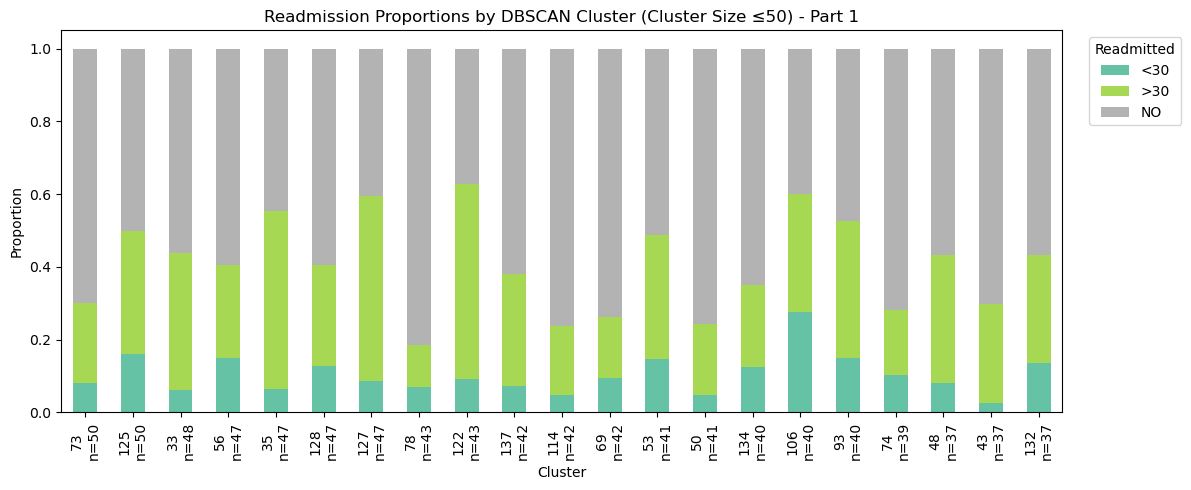

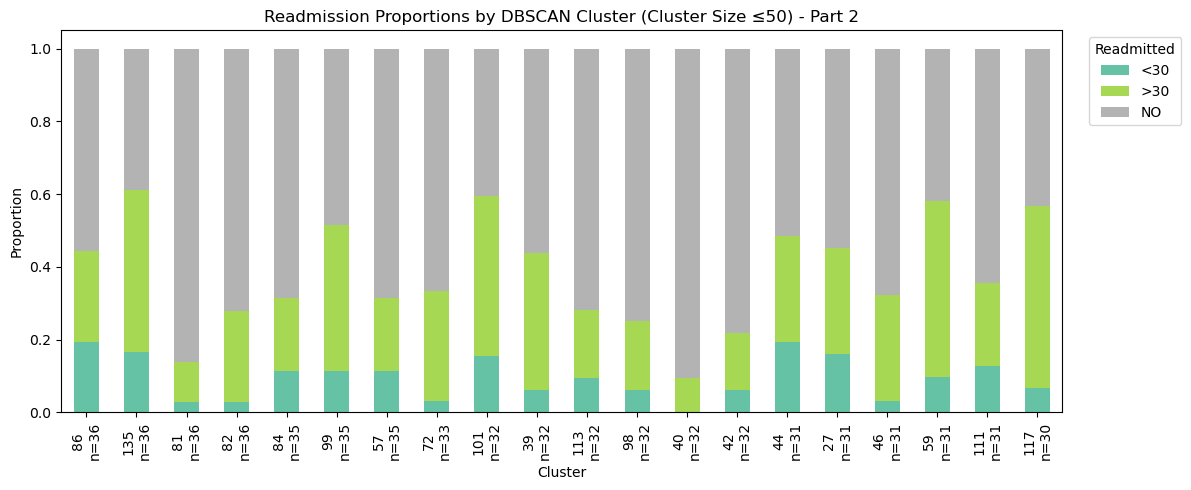

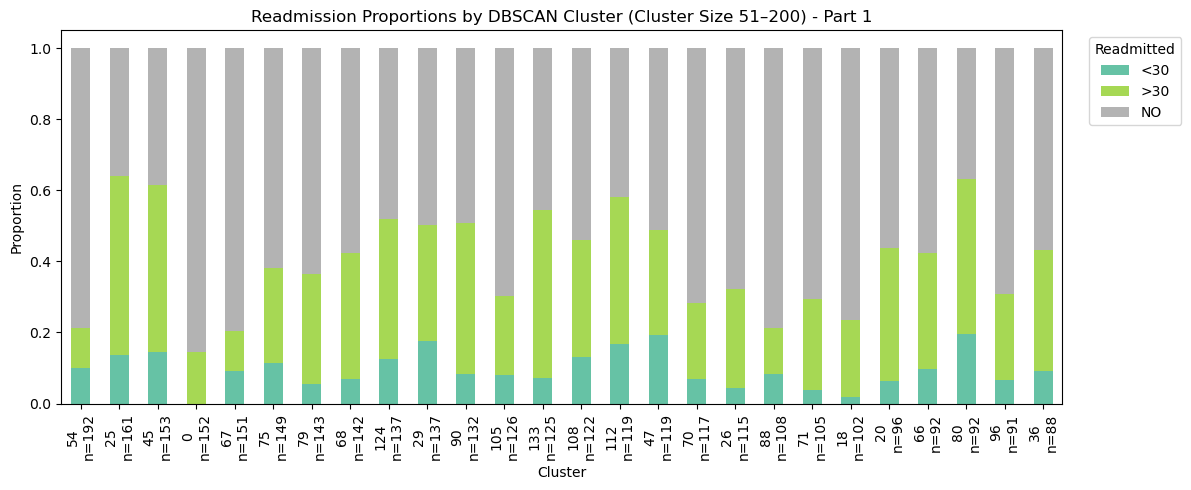

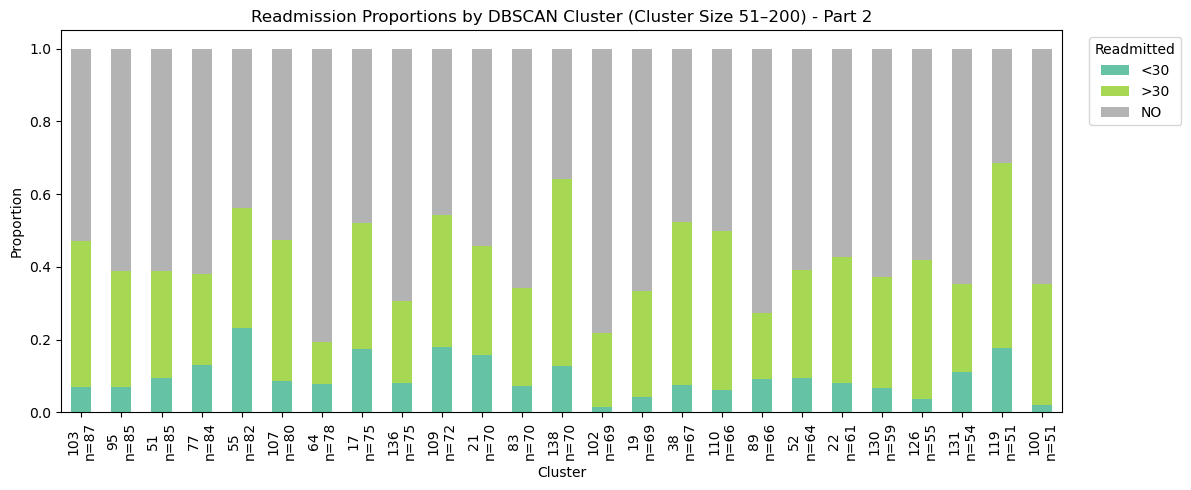

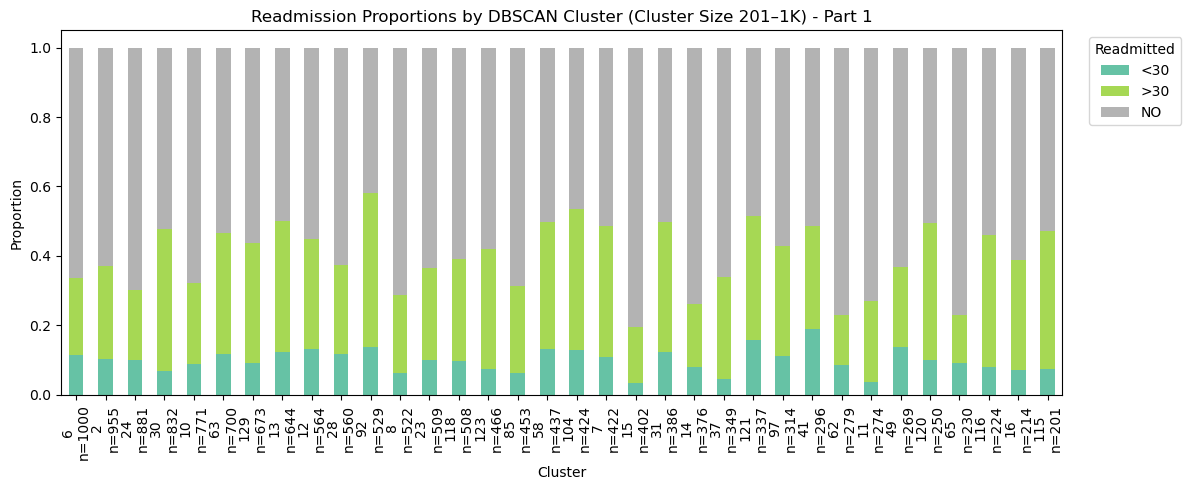

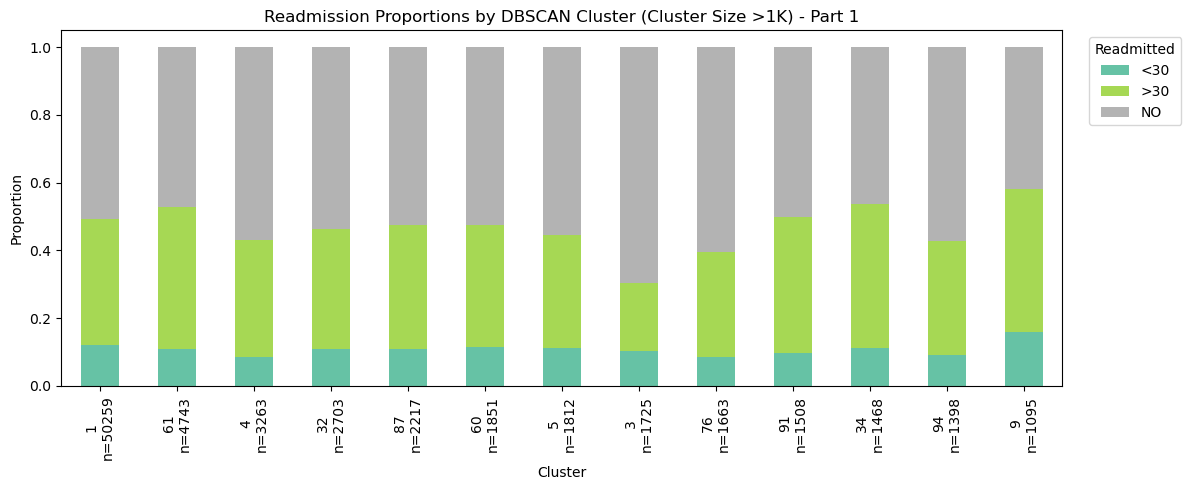

In [84]:
# Step 1: Get cluster sizes and exclude noise
cluster_counts = df_clustered['cluster_dbscan_care'].value_counts()
cluster_counts = cluster_counts[cluster_counts.index != -1] # remove noise

# Step 2: Create bins and labels
bins = [0, 50, 200, 1000, float('inf')]
labels = ['≤50', '51–200', '201–1K', '>1K']
cluster_bins = pd.cut(cluster_counts, bins=bins, labels=labels)

# Step 3: Attach bin labels to readmission crosstab
readmit_ct = pd.crosstab(df_clustered['cluster_dbscan_care'], df_clustered['readmitted'])
readmit_ct = readmit_ct.loc[readmit_ct.index != -1] # remove noise

# Add sizes and bin info
readmit_ct['size'] = readmit_ct.sum(axis=1)
readmit_ct['bin'] = cluster_bins

# Step 4: Normalize proportions
readmit_props = readmit_ct.drop(columns=['size', 'bin']).div(readmit_ct['size'], axis=0)

# Step 5: Create label with cluster size
readmit_props['size'] = readmit_ct['size']
readmit_props['bin'] = readmit_ct['bin']
readmit_props['label'] = [f"{idx}\nn={size}" for idx, size in zip(readmit_props.index, readmit_props['size'])]

# Step 6: Plot function
def plot_readmit_chunks(df, bin_label, title, chunks=2):
    subset = df[df['bin'] == bin_label]
    if subset.empty:
        return
    
    subset_sorted = subset.sort_values('size', ascending=False)
    n = len(subset_sorted)
    chunk_size = -(-n // chunks)  # ceiling division

    for i in range(0, n, chunk_size):
        chunk = subset_sorted.iloc[i:i+chunk_size]
        props = chunk[['<30', '>30', 'NO']]
        props.index = chunk['label']

        props.plot(kind='bar', stacked=True, colormap='Set2', figsize=(12, 5))
        plt.title(f"{title} (Cluster Size {bin_label}) - Part {i//chunk_size + 1}")
        plt.xlabel("Cluster")
        plt.ylabel("Proportion")
        plt.xticks(rotation=90)
        plt.legend(title='Readmitted', bbox_to_anchor=(1.02, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

# Step 7: Final Plots
plot_readmit_chunks(readmit_props, '≤50', "Readmission Proportions by DBSCAN Cluster", chunks=2)
plot_readmit_chunks(readmit_props, '51–200', "Readmission Proportions by DBSCAN Cluster", chunks=2)
plot_readmit_chunks(readmit_props, '201–1K', "Readmission Proportions by DBSCAN Cluster", chunks=1)
plot_readmit_chunks(readmit_props, '>1K', "Readmission Proportions by DBSCAN Cluster", chunks=1)

Observations:
- Most clusters had a similar readmission mix. 
- Small to medium cluster show more varied proportions, likely due to small sample size.

#### Cluster Composition

We used filtered heatmaps to visualize the distribution of Admission Source IDs, Medical Specialties, and Payer Codes across clusters. These heatmaps only display clusters and features with values above a specific threshold, helping us focus on more informative patterns.

Thresholds applied:
- Admission Source ID: ≥ 2 patients  
- Medical Specialty: ≥ 10 patients  
- Payer Code: ≥ 5 patients  

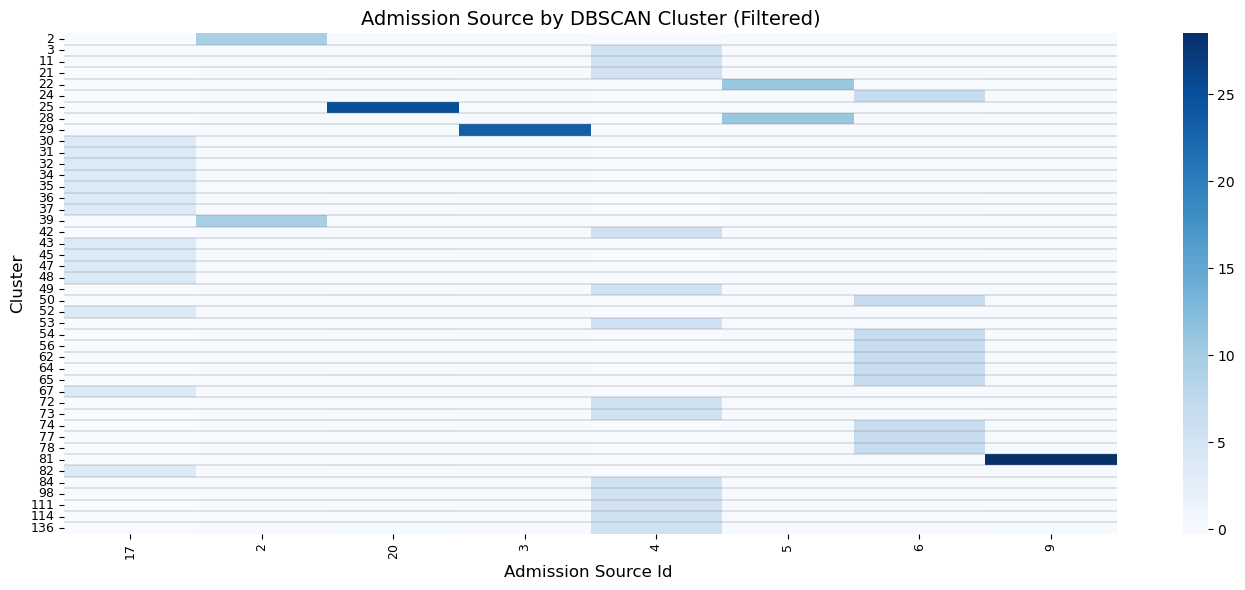

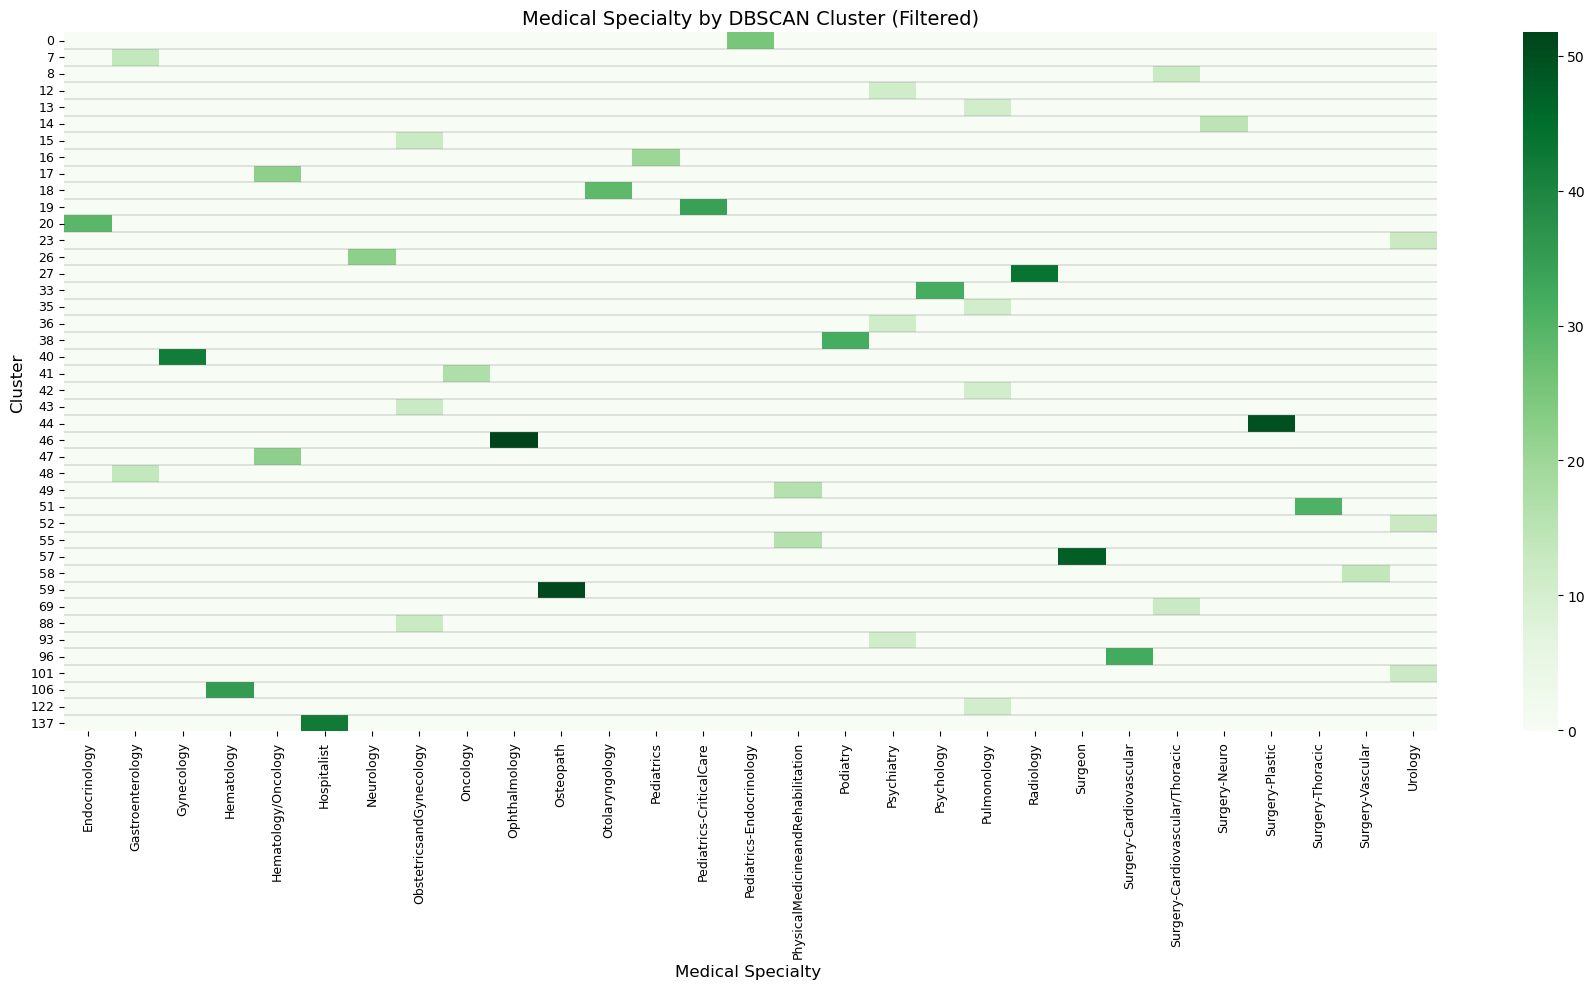

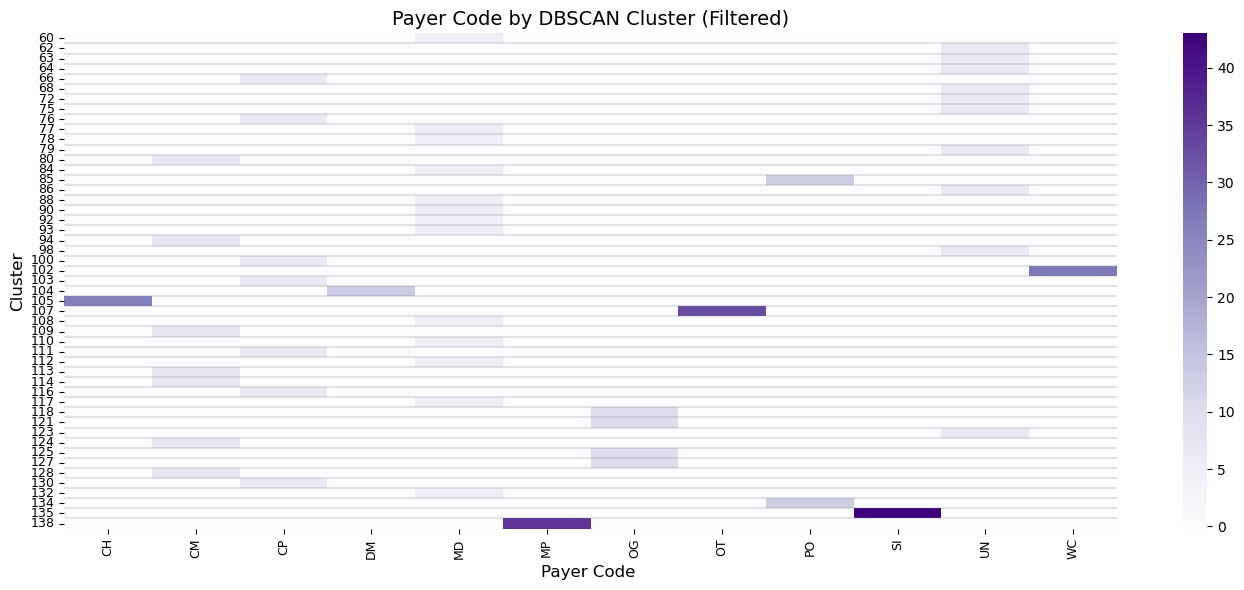

In [85]:
def plot_filtered_heatmap(data, feature_prefix, threshold=0.05, cmap='Greens', title='', figsize=(14, 6)):
    """
    Plots a heatmap showing only rows and columns with at least one value above a given threshold.
    
    Parameters:
        data (DataFrame): Cluster × One-hot-encoded features matrix
        feature_prefix (str): Prefix to strip from column names for display
        threshold (float): Minimum value required to include a feature or cluster
        cmap (str): Colormap for the heatmap
        title (str): Plot title
        figsize (tuple): Manual figure size in inches
    """
    # Filter to rows and columns that have at least one cell above the threshold
    mask_cols = data.columns[(data > threshold).any(axis=0)]
    mask_rows = data.index[(data[mask_cols] > threshold).any(axis=1)]
    
    filtered = data.loc[mask_rows, mask_cols]
    if filtered.empty:
        print("No values above threshold.")
        return

    # Use the passed figure size
    plt.figure(figsize=figsize)
    ax = sns.heatmap(filtered, cmap=cmap, cbar=True,
                     xticklabels=[col.replace(feature_prefix, '') for col in filtered.columns],
                     yticklabels=True,
                     linewidths=0,
                     linecolor='gray')
    
    # Subtle horizontal lines for separation
    for y in range(1, filtered.shape[0]):
        ax.axhline(y=y, color='gray', linestyle='-', linewidth=0.3)

    plt.title(title, fontsize=14)
    plt.xlabel(feature_prefix.replace('_', ' ').title(), fontsize=12)
    plt.ylabel("Cluster", fontsize=12)
    plt.xticks(rotation=90, fontsize=9)
    plt.yticks(fontsize=9)
    plt.tight_layout()
    plt.show()

# Switch to DBSCAN clusters
X_encoded['cluster'] = df_clustered['cluster_dbscan_care']
cluster_feature_means = X_encoded.groupby('cluster').mean()

plot_filtered_heatmap(cluster_feature_means[admission_cols],
                      feature_prefix='admission_source_id_',
                      threshold=2,
                      cmap='Blues',
                      title='Admission Source by DBSCAN Cluster (Filtered)',
                      figsize=(14, 6))

plot_filtered_heatmap(cluster_feature_means[specialty_cols],
                      feature_prefix='medical_specialty_',
                      threshold=10,
                      cmap='Greens',
                      title='Medical Specialty by DBSCAN Cluster (Filtered)',
                      figsize=(18, 10))

plot_filtered_heatmap(cluster_feature_means[payer_cols],
                      feature_prefix='payer_code_',
                      threshold=5,
                      cmap='Purples',
                      title='Payer Code by DBSCAN Cluster (Filtered)',
                      figsize=(14, 6))

Observations:

- Admission Source ID:
  - Cluster `25` is strongly associated with Source `20` (20: Not Mapped).
  - Cluster `29` shows high representation of Source `3` (3: HMO Referral).
  - Cluster `81` includes mostly Source `9` (9: Not Available).

- Medical Specialty:
  - Cluster `46` includes many `Opthamology` cases.
  - Cluster `59` stands out for `Osteopath`.
  - Cluster `57` has a high concentration of `Surgeon`.
  - Cluster `44` includes many `Plastic Surgeon` cases.

- Payer Code:
  - Cluster `138` is dominated by patients with payer code `MP`.
  - Cluster `107` has high representation of `OT`.
  - Cluster `135` includes many patients with code `SI`.

These filtered visualizations highlight interesting and unexpected subgroupings and associations between patient clusters and specific care context features, even within a sparse, high-dimensional space.

#### Hierarchical Agglomerative Clustering: Tuning Linkage and Cluster Counts

- We used HAC to explore clustering as a alternative method useful when the number, size, or shape of clusters is unknown.
- To tune HAC, we ran a grid search over:
  - Linkage methods (ward and average, skipping complete to reduce computation time)
  - Cluster counts from 20 to 150 (this range includes the 139 clusters found by DBSCAN and 34 clusters from k-means)
- Silhouette scores were used to compare configurations.

We sampled 20,000 rows from the data to avoid kernel crashes.

In [86]:
# Kernel kept dying so running search on a sample of the data
# Sample 20,000 rows from X
np.random.seed(1234)
sample_idx = np.random.choice(X_care.shape[0], size=20000, replace=False)
X_care_sample = X_care[sample_idx]

print("\n--- HAC Grid Search Results ---")

results = []
best_score = -1
best_config = None

start_time = time.time()

# Linkages to try
linkages = ['ward', 'average']

# Grid search
for link in linkages:
    for n_clstr in range(20, 151, 10): # range includes 139 (DBSCAN) and 34 (k-means)
        if link == 'ward':
            hac = AgglomerativeClustering(n_clusters=n_clstr, linkage=link)
        else:
            hac = AgglomerativeClustering(n_clusters=n_clstr, linkage=link, metric='euclidean')

        # labels = hac.fit_predict(X_care)
        # score = silhouette_score(X_care, labels, sample_size=5000, random_state=1234)
        labels = hac.fit_predict(X_care_sample)
        score = silhouette_score(X_care_sample, labels)
                                 
        results.append({
            'linkage': link,
            'n_clusters': n_clstr,
            'silhouette': score
        })

        if score > best_score:
            best_score = score
            best_config = (link, n_clstr)

results_df = pd.DataFrame(results)
print(results_df.sort_values('silhouette', ascending=False))

print(f"\nBest config: linkage={best_config[0]}, n_clusters={best_config[1]}, silhouette={best_score:.4f}")

print(f"HAC time: {(time.time() - start_time)/60:.2f} minutes")


--- HAC Grid Search Results ---
    linkage  n_clusters  silhouette
14  average          20    0.886628
13     ward         150    0.833404
15  average          30    0.831169
12     ward         140    0.823688
11     ward         130    0.806934
10     ward         120    0.800757
9      ward         110    0.777600
16  average          40    0.752960
8      ward         100    0.740349
17  average          50    0.713111
7      ward          90    0.616863
18  average          60    0.598102
19  average          70    0.535136
20  average          80    0.495103
21  average          90    0.490808
6      ward          80    0.489919
22  average         100    0.485747
23  average         110    0.479920
24  average         120    0.463518
25  average         130    0.448006
26  average         140    0.445347
27  average         150    0.437224
5      ward          70    0.397363
4      ward          60    0.315025
3      ward          50    0.259607
2      ward          40    0.19

#### Visual Comparison: Silhouette Score by Linkage

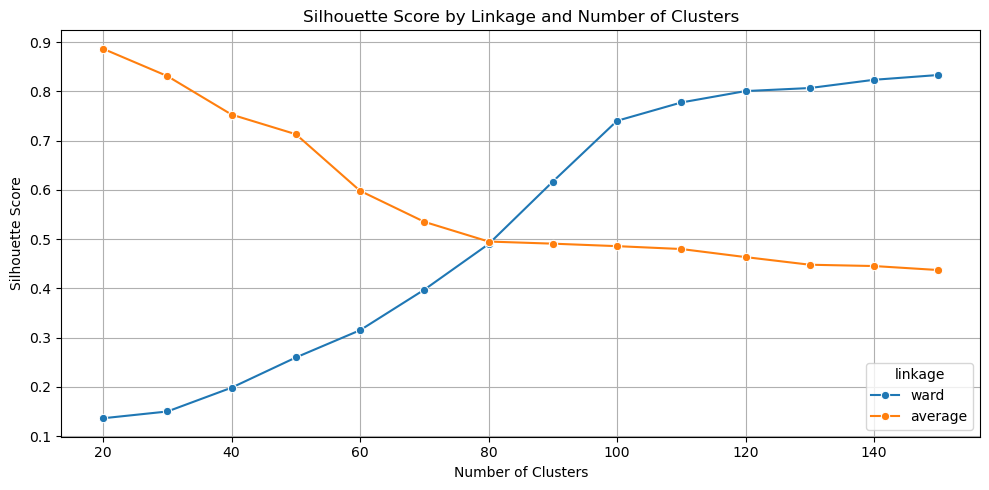

In [87]:
# Plot to compare linkages visually

plt.figure(figsize=(10, 5))
sns.lineplot(data=results_df, x='n_clusters', y='silhouette', hue='linkage', marker='o')
plt.title("Silhouette Score by Linkage and Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.tight_layout()
plt.show()

Observations:
- Best silhouette score overall: 20 clusters using average linkage
- Best for ward: 150 clusters
- Overlap: At 80 clusters, silhouette scores for average and ward are similar (~0.49), which might make it a reasonable balance point

#### Clustering on the Sampled Data

We selected three configurations (20, 80, and 150 clusters) to compare more closely.

In [88]:
# Fit HAC on the sample (running the full dataset kills the kernel)

# HAC with 20 clusters (highest overall silhouette score, coarser, more manageable number)
hac_20 = AgglomerativeClustering(n_clusters=20, linkage='average', metric='euclidean')
labels_20 = hac_20.fit_predict(X_care_sample)

# HAC with 80 clusters (where ward and average overlap)
hac_80 = AgglomerativeClustering(n_clusters=80, linkage='ward')
labels_80 = hac_80.fit_predict(X_care_sample)

# HAC with 150 clusters (highest ward silhouette score)
hac_150 = AgglomerativeClustering(n_clusters=150, linkage='ward')
labels_150 = hac_150.fit_predict(X_care_sample)

# Initialize columns with NaN, assign only for sampled rows
df_clustered['cluster_hac20_care'] = np.nan
df_clustered['cluster_hac80_care'] = np.nan
df_clustered['cluster_hac150_care'] = np.nan

df_clustered.loc[sample_idx, 'cluster_hac20_care'] = labels_20
df_clustered.loc[sample_idx, 'cluster_hac80_care'] = labels_80
df_clustered.loc[sample_idx, 'cluster_hac150_care'] = labels_150

In [89]:
def summarize_cluster_sizes(labels):
    sizes = pd.Series(labels).value_counts()
    return sizes.describe()

print("Summary for HAC (20 clusters):")
print(summarize_cluster_sizes(labels_20), "\n")

print("Summary for HAC (80 clusters):")
print(summarize_cluster_sizes(labels_80), "\n")

print("Summary for HAC (150 clusters):")
print(summarize_cluster_sizes(labels_150))

Summary for HAC (20 clusters):
count       20.000000
mean      1000.000000
std       4463.897872
min          1.000000
25%          1.000000
50%          2.000000
75%          2.000000
max      19965.000000
Name: count, dtype: float64 

Summary for HAC (80 clusters):
count      80.000000
mean      250.000000
std       762.330554
min         1.000000
25%         4.000000
50%        24.000000
75%       159.250000
max      6080.000000
Name: count, dtype: float64 

Summary for HAC (150 clusters):
count     150.000000
mean      133.333333
std       283.618154
min         1.000000
25%        11.250000
50%        40.500000
75%       140.750000
max      2383.000000
Name: count, dtype: float64


Observations:
- The 20 cluster configuration is very imbalanced with one dominant cluster.
- The 80 and 150 clusterings show better distribution, though still skewed.

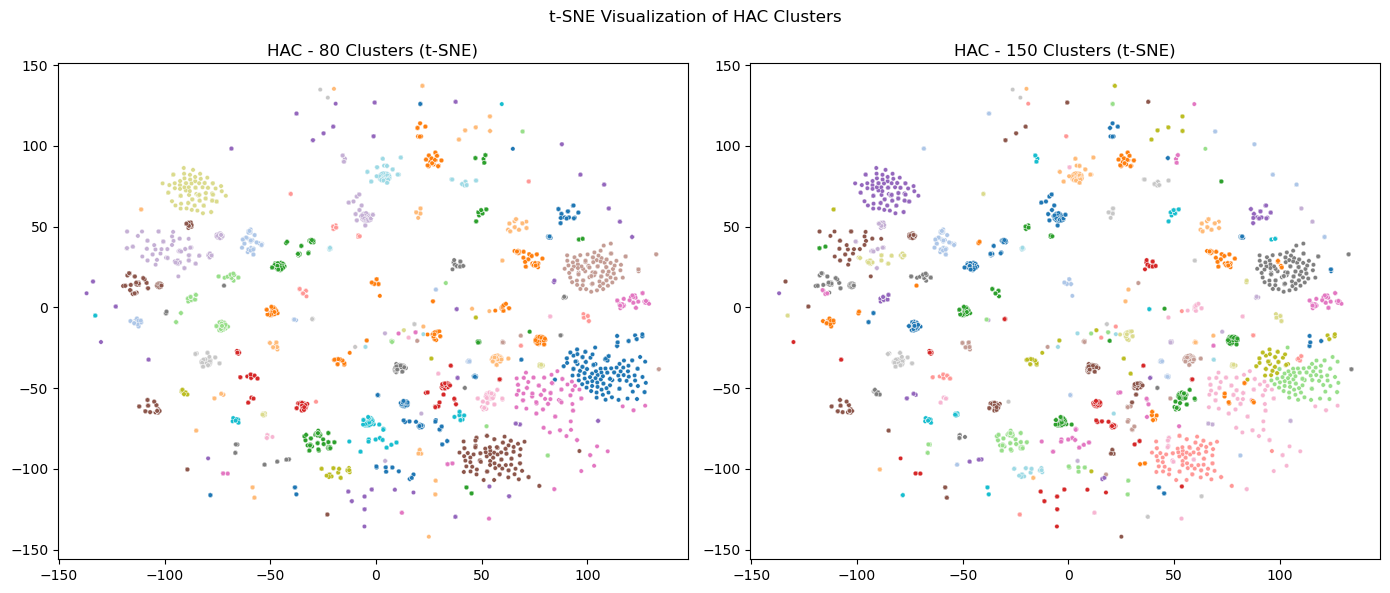

In [90]:
# t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=1234, max_iter=1000)
X_tsne = tsne.fit_transform(X_care_sample)

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=labels_80,
                palette='tab20', s=10, ax=axes[0], legend=False)
axes[0].set_title("HAC - 80 Clusters (t-SNE)")

sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=labels_150,
                palette='tab20', s=10, ax=axes[1], legend=False)
axes[1].set_title("HAC - 150 Clusters (t-SNE)")

plt.suptitle("t-SNE Visualization of HAC Clusters")
plt.tight_layout()
plt.show()

Observations:
- At 80 clusters, we start to see distinct separation between groups.
- With 150 clusters, smaller subgroups become more visible.

#### Dendrogram Visualization

We plotted a truncated dendrogram showing the last 120 merge steps using Ward linkage.

We added horizontal lines at the distance thresholds corresponding to approximately 80 and 150 clusters to help visualize where the algorithm would cut the tree to form clusters at those levels.

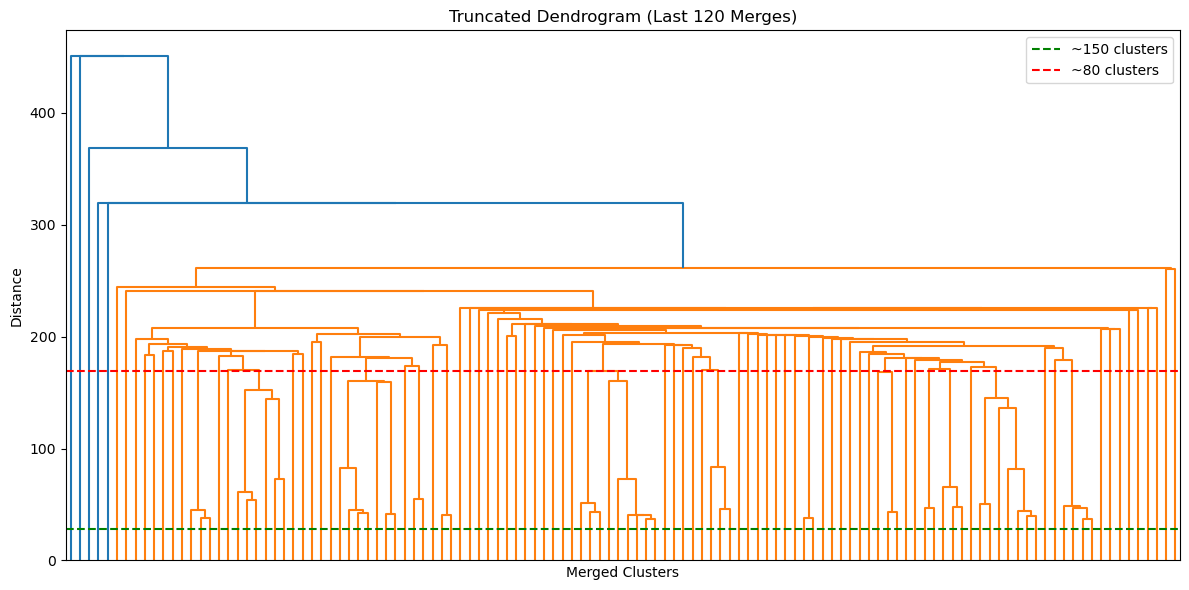

In [91]:
# Compute the linkage matrix (ward is default for numeric, Euclidean data)
Z = linkage(X_care_sample, method='ward')

# Plot the truncated dendrogram (last 120 merges)
plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode='lastp', p=120, 
           leaf_rotation=45, leaf_font_size=10, show_contracted=True)

# Add horizontal lines to indicate cut levels (can help choose n_clusters)
plt.axhline(y=Z[-150, 2], color='green', linestyle='--', label='~150 clusters')
plt.axhline(y=Z[-80, 2], color='red', linestyle='--', label='~80 clusters')

plt.title("Truncated Dendrogram (Last 120 Merges)")
plt.xlabel("Merged Clusters")
plt.ylabel("Distance")
plt.xticks([])  # turn off x-axis labels
plt.legend()
plt.tight_layout()
plt.show()

#### Readmission Proportions By Cluster

We sorted the HAC-80 clusters by size and plotted the proportion of patients in each readmission category for every cluster.

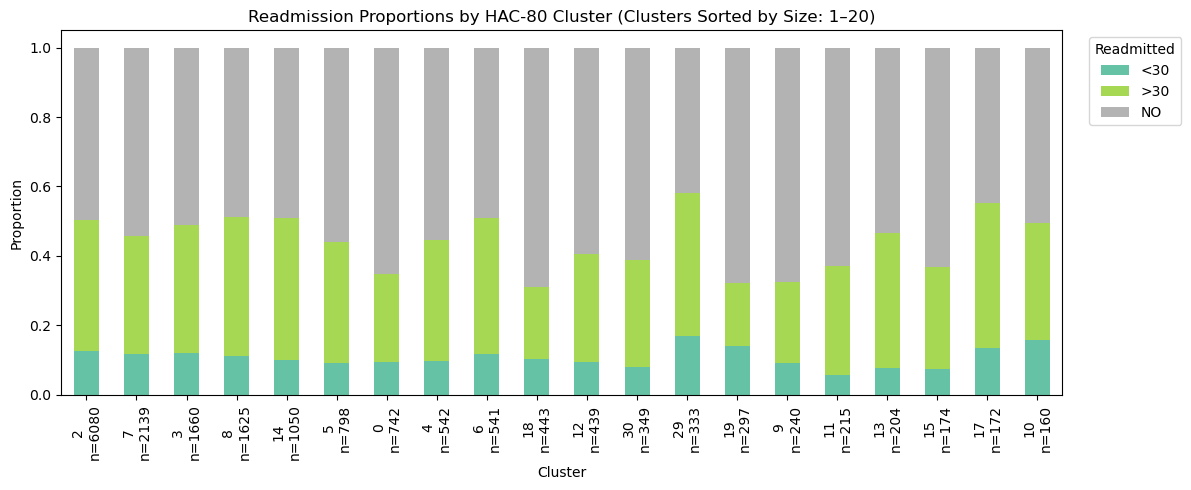

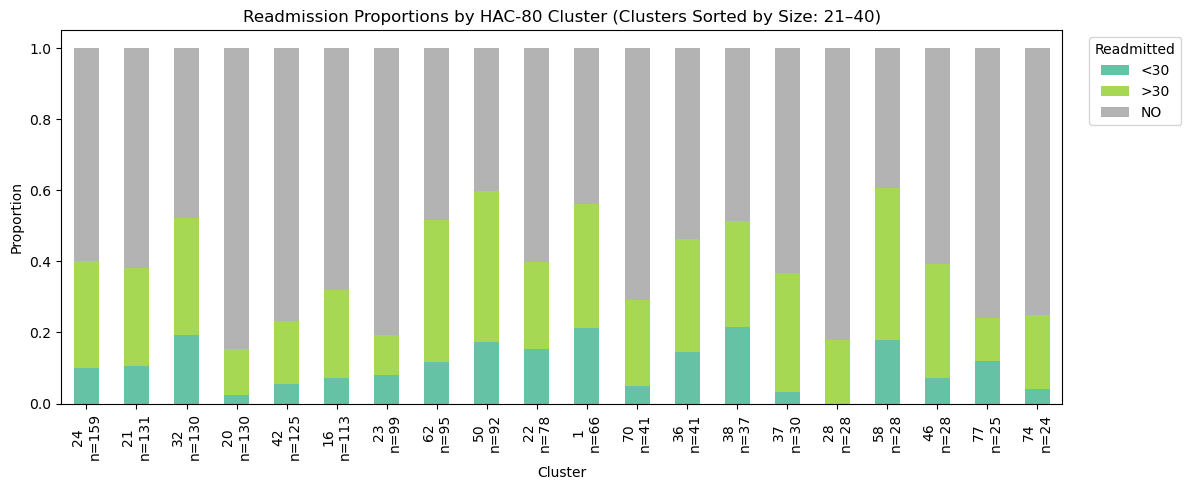

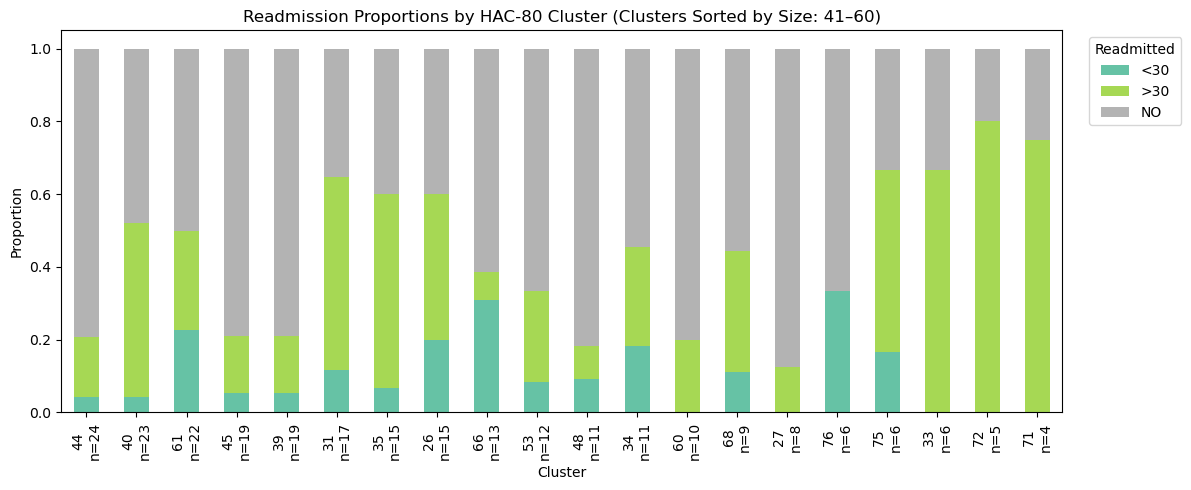

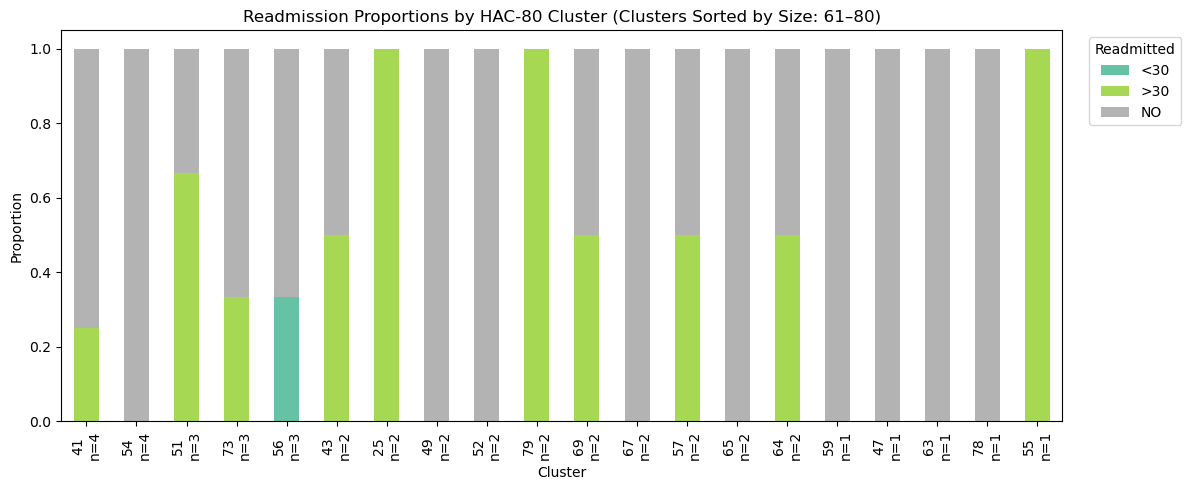

In [92]:
# Get cluster sizes
hac_col = 'cluster_hac80_care'
cluster_counts = df_clustered[hac_col].value_counts()
readmit_ct = pd.crosstab(df_clustered[hac_col], df_clustered['readmitted'])

# Attach sizes to readmit proportions
readmit_ct['size'] = readmit_ct.sum(axis=1)
readmit_props = readmit_ct.drop(columns='size').div(readmit_ct['size'], axis=0)

# Add back size and label for plotting
readmit_props['size'] = readmit_ct['size']
readmit_props['label'] = [f"{int(idx)}\nn={size}" for idx, size in zip(readmit_props.index, readmit_props['size'])]

# Plotting in sorted chunks
def plot_readmit_hac_sorted(df, title, chunks=4):
    df_sorted = df.sort_values('size', ascending=False)
    chunk_size = -(-len(df_sorted) // chunks)  # ceiling division

    for i in range(0, len(df_sorted), chunk_size):
        chunk = df_sorted.iloc[i:i + chunk_size]
        props = chunk[['<30', '>30', 'NO']]
        props.index = chunk['label']

        props.plot(kind='bar', stacked=True, colormap='Set2', figsize=(12, 5))
        plt.title(f"{title} (Clusters Sorted by Size: {i + 1}–{i + len(chunk)})")
        plt.xlabel("Cluster")
        plt.ylabel("Proportion")
        plt.xticks(rotation=90)
        plt.legend(title='Readmitted', bbox_to_anchor=(1.02, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

# Final plots
plot_readmit_hac_sorted(readmit_props, "Readmission Proportions by HAC-80 Cluster", chunks=4)

General Cluster Observations:
- Cluster size distribution is highly skewed.
- A few large clusters dominate (e.g. one with over 6000 records), while most are very small (median size = 24).

Interpretation of Readmission Patterns:
- The largest 25% of clusters have similar proportions of readmissions.
- Mid-sized clusters show more variability in readmission proportions, which may reflect meaningful subgroups with different tendencies.
- Interpreting patterns in the smallest 50% of clusters is difficult due to very low sample sizes.

#### Care Context Features by HAC-80 Cluster (Filtered)

These filtered heatmaps show the strongest associations between clusters and specific care context features. By only including values above a threshold, we focus on the most informative patterns in the data.

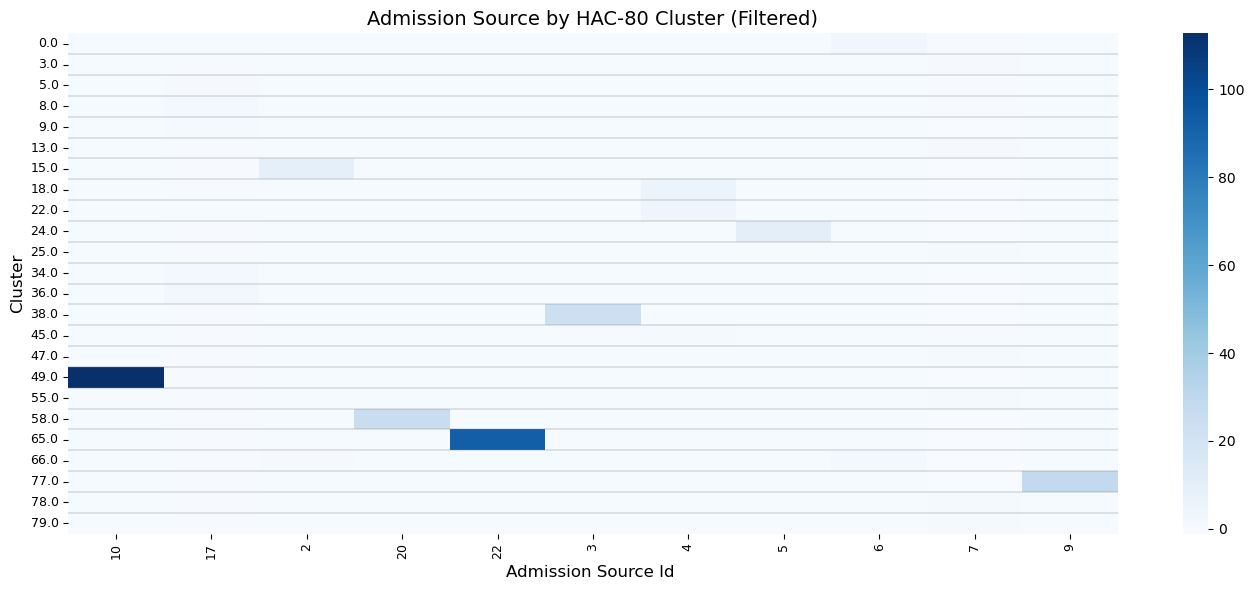

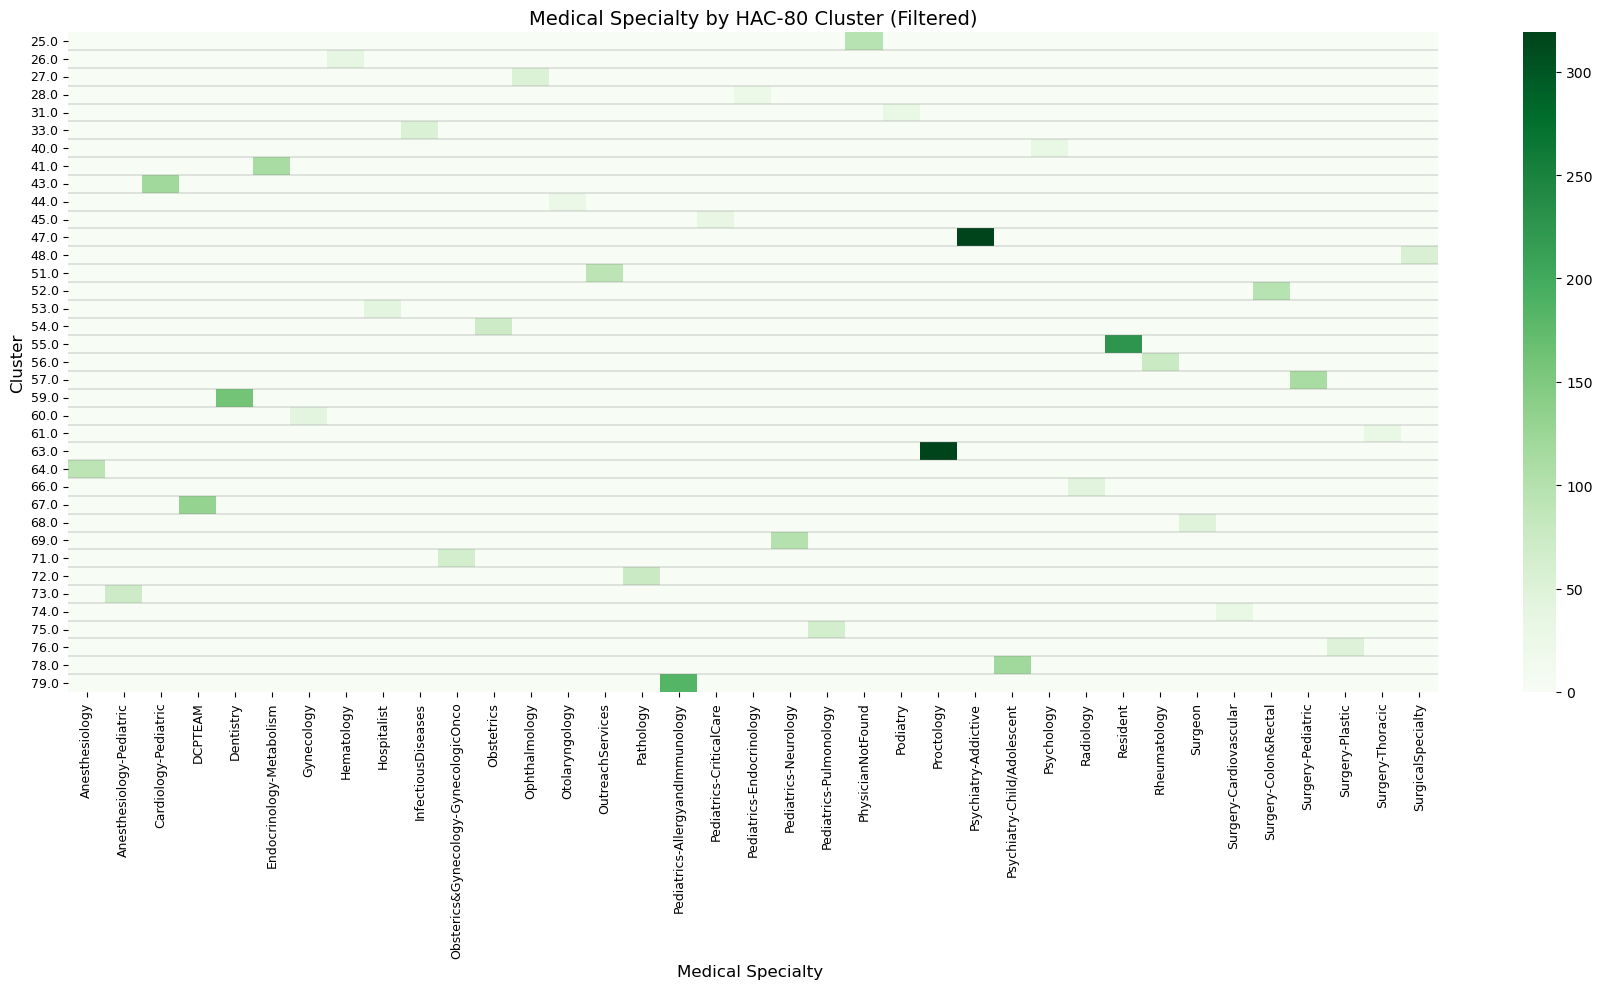

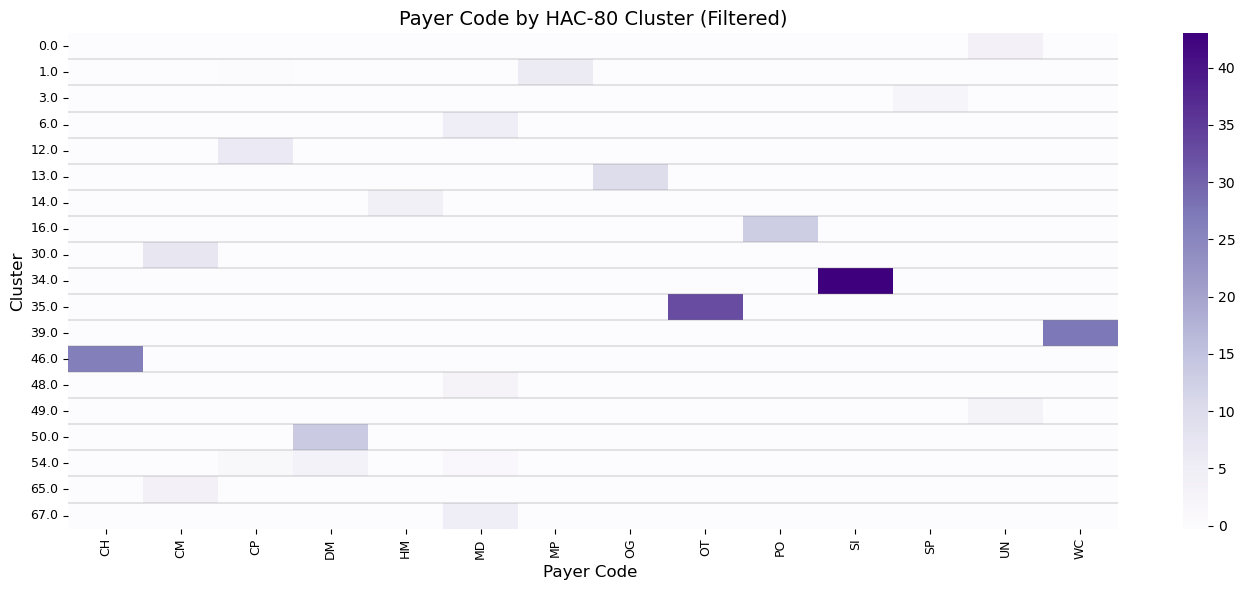

In [93]:
# Step 1: Assign HAC-80 cluster labels
X_encoded['cluster'] = df_clustered['cluster_hac80_care']  # assuming this is already assigned

# Step 2: Compute cluster-wise means
cluster_feature_means_hac80 = X_encoded.groupby('cluster').mean()

# Step 3: Run filtered heatmap for each feature group

# Admission Source
plot_filtered_heatmap(cluster_feature_means_hac80[admission_cols],
                      feature_prefix='admission_source_id_',
                      threshold=0.5,
                      cmap='Blues',
                      title='Admission Source by HAC-80 Cluster (Filtered)',
                      figsize=(14, 6))

# Medical Specialty
plot_filtered_heatmap(cluster_feature_means_hac80[specialty_cols],
                      feature_prefix='medical_specialty_',
                      threshold=25,
                      cmap='Greens',
                      title='Medical Specialty by HAC-80 Cluster (Filtered)',
                      figsize=(18, 10))

# Payer Code
plot_filtered_heatmap(cluster_feature_means_hac80[payer_cols],
                      feature_prefix='payer_code_',
                      threshold=2,
                      cmap='Purples',
                      title='Payer Code by HAC-80 Cluster (Filtered)',
                      figsize=(14, 6))

Observations:

- Admission Source ID:
  - Cluster `49` is dominated by patients from Source `10` (10: Transfer from critical access hospital).
  - Cluster `65` is primarily associated with Source `22` (22: Transfer from hospital inpatient/same facility).
  - Cluster `58` includes a number of patients from Source `20` (20: Not Mapped).
  - Cluster `77` includes patients from Source `9` (9: Not Available).

- Medical Specialty:
  - Cluster `47` is dominated by `Psychiatry-Addictive`.
  - Cluster `63` is primarily associated with `Proctology`.
  - Cluster `55` stands out for `Resident`.
  - Cluster `79` includes many `Pediatrics-Allergy & Immunology` cases.

- Payer Code:
  - Cluster `34` shows high representation of code `SI`.
  - Cluster `35` is dominated by patients with code `OT`.
  - Cluster `46` is strongly associated with `CH`.
  - Cluster `39` includes many patients with code `WC`.

This suggests that the 80 HAC clusters capture meaningful (and unexpected) subgroups within particular admission sources, medical specialties, and payer codes.

### Compare Clustering Models for Care Context: K-Means, DBSCAN, HAC (80 & 150)

To compare how well each clustering method grouped the data, we looked at:
- Silhouette Score – How distinct and well-formed the clusters are (higher is better).
- ARI – How much agreement there is between different clustering assignments, adjusting for chance.
- Cluster Size Distribution – Whether clusters are balanced in size or dominated by just a few large ones.

In [94]:
# Compare silhouette scores of clustering models
silhouette_scores = {
    'KMeans': silhouette_score(X, df_clustered['cluster_kmeans_care']), # used X for k-means
    'DBSCAN': silhouette_score(                                         # used X_care for dbscan
        X_care[df_clustered['cluster_dbscan_care'] != -1],
        df_clustered.loc[df_clustered['cluster_dbscan_care'] != -1, 'cluster_dbscan_care']
    ),
    'HAC-80': silhouette_score(X_care_sample, df_clustered.loc[sample_idx, 'cluster_hac80_care']),
    'HAC-150': silhouette_score(X_care_sample, df_clustered.loc[sample_idx, 'cluster_hac150_care']),
}

print("Silhouette Scores:")
for method, score in silhouette_scores.items():
    print(f"{method}: {score:.4f}")

Silhouette Scores:
KMeans: 0.2746
DBSCAN: 0.5086
HAC-80: 0.4899
HAC-150: 0.8334


In [95]:
# Adjusted Rand Index (Pairwise Agreement)

# Use correct label columns
labels_kmeans = df_clustered['cluster_kmeans_care']
labels_dbscan = df_clustered['cluster_dbscan_care']
labels_hac80 = df_clustered['cluster_hac80_care']
labels_hac150 = df_clustered['cluster_hac150_care']

# Calculate ARI only on the overlapping sample
sample_mask = df_clustered[['cluster_kmeans_care', 'cluster_dbscan_care',
                            'cluster_hac80_care', 'cluster_hac150_care']].notna().all(axis=1)

ari_scores = {
    'KMeans vs DBSCAN': adjusted_rand_score(labels_kmeans[sample_mask], labels_dbscan[sample_mask]),
    'KMeans vs HAC-80': adjusted_rand_score(labels_kmeans[sample_mask], labels_hac80[sample_mask]),
    'KMeans vs HAC-150': adjusted_rand_score(labels_kmeans[sample_mask], labels_hac150[sample_mask]),
    'DBSCAN vs HAC-80': adjusted_rand_score(labels_dbscan[sample_mask], labels_hac80[sample_mask]),
    'DBSCAN vs HAC-150': adjusted_rand_score(labels_dbscan[sample_mask], labels_hac150[sample_mask]),
    'HAC-80 vs HAC-150': adjusted_rand_score(labels_hac80[sample_mask], labels_hac150[sample_mask]),
}

print("\nAdjusted Rand Index (ARI):")
for pair, score in ari_scores.items():
    print(f"{pair}: {score:.4f}")


Adjusted Rand Index (ARI):
KMeans vs DBSCAN: 0.1792
KMeans vs HAC-80: 0.4299
KMeans vs HAC-150: 0.3403
DBSCAN vs HAC-80: 0.5301
DBSCAN vs HAC-150: 0.2027
HAC-80 vs HAC-150: 0.4133


In [96]:
# Function to summarize cluster sizes
def summarize_cluster_sizes(label_series, name, include_noise=False):
    counts = label_series.value_counts().sort_index()
    if not include_noise:
        counts = counts[counts.index != -1]
    summary = {
        'Model': name,
        'Clusters': len(counts),
        'Min': counts.min(),
        'Max': counts.max(),
        'Median': counts.median(),
        'Mean': round(counts.mean(), 2)
    }
    if include_noise:
        summary['Noise Points'] = (label_series == -1).sum()
        summary['Noise %'] = round((summary['Noise Points'] / len(label_series)) * 100, 2)
    return summary

# Summarize each model
summaries = [
    summarize_cluster_sizes(labels_kmeans, 'KMeans'),
    summarize_cluster_sizes(labels_dbscan, 'DBSCAN', include_noise=True),
    summarize_cluster_sizes(labels_hac80, 'HAC-80'),
    summarize_cluster_sizes(labels_hac150, 'HAC-150')
]
summary_df = pd.DataFrame(summaries)
print(summary_df)

     Model  Clusters  Min    Max  Median     Mean  Noise Points  Noise %
0   KMeans        34    1  29031   467.0  2993.12           NaN      NaN
1   DBSCAN       140   30  50259    94.0   726.90        3240.0     3.18
2   HAC-80        80    1   6080    24.0   250.00           NaN      NaN
3  HAC-150       150    1   2383    40.5   133.33           NaN      NaN


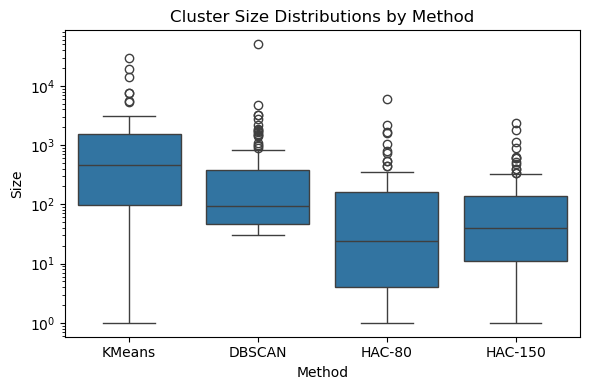

In [97]:
cluster_distributions = {
    'KMeans': labels_kmeans.value_counts(),
    'DBSCAN': labels_dbscan.value_counts(),
    'HAC-80': labels_hac80.value_counts(),
    'HAC-150': labels_hac150.value_counts()
}

df_sizes = pd.DataFrame([
    {'Method': name, 'Size': size}
    for name, sizes in cluster_distributions.items()
    for size in sizes if size != -1  # DBSCAN noise filter
])

plt.figure(figsize=(6, 4))
sns.boxplot(x='Method', y='Size', data=df_sizes)
plt.yscale('log')  # optional if sizes vary a lot
plt.title("Cluster Size Distributions by Method")
plt.tight_layout()
plt.show()

#### Interpretation of Cluster Results on the Care Context Features and Comparison of Methods

HAC-150 had the highest silhouette score, suggesting well-separated clusters. DBSCAN and HAC-80 also performed reasonably well. K-Means had the lowest silhouette score, indicating less compactness and separation.

The Adjusted Rand Index (ARI) value indicated the highest agreement was between DBSCAN and HAC-80, suggesting they captured similar groupings. However, HAC-80 had a reasonable amount of overlap with all of the other methods. DBSCAN was quite different than both K-Means and HAC-150.

K-Means produced the smallest number of clusters that were size imbalanced, with one extremely large group and many very small ones. DBSCAN returned 140 clusters, one containing nearly half of the data and many moderately small clusters. HAC-80 was more skewed than HAC-150 with HAC-150 generating smaller clusters and a finer segmentation of the data.

While HAC-80 and K-Means would both be reasonable choices for downstream clustering due to their relative simplicity, HAC required subsampling due to computational limitations. Because of this constraint, we would choose K-Means for downstream tasks.

### Downstream Evaluation of Classification after Clustering

#### Cluster the Data and Prepare a Master Dataset

In this step, we apply K-Means clustering to two sets of features—Resource Use and Care Context—based on earlier clustering analysis. (This is repeated here to keep the notebook modular and self-contained, especially since some of the previous cluster labels were overwritten.) We then add the resulting cluster labels to a clean copy of the dataset to use in downstream classification tasks.

We also extract the target variable and define a reduced feature set based on prior feature selection using Random Forest importance (done in EDA).

In [98]:
# Start with a fresh copy of the cleaned dataset
df_cluster = df_clean.copy()

# Extract the target variable and binarize: 1 if readmitted within 30 days, else 0
y = df_clean['readmitted']
y_binary = np.where(y == '<30', 1, 0)

# Final set of RF-selected features (done in EDA)
final_rf_features = [
    'age', 'diag_2', 'time_in_hospital', 'payer_code', 'number_outpatient', 'gender',
    'admission_type_id', 'race', 'number_diagnoses', 'num_procedures', 'num_medications',
    'number_emergency', 'discharge_disposition_id', 'admission_source_id', 'diag_1',
    'medical_specialty', 'diag_3', 'number_inpatient', 'num_lab_procedures'
]

# Define feature groups used for clustering
resource_vars = ['time_in_hospital', 'number_outpatient', 'num_procedures',
                 'num_medications', 'number_emergency', 'number_inpatient', 'num_lab_procedures']

care_context_vars = ['payer_code', 'admission_source_id', 'medical_specialty']

# Preprocess clustering variables
# Encode care context variables and scale them
care_context_encoded = pd.get_dummies(df_clean[care_context_vars], drop_first=True)
care_context_scaled = StandardScaler().fit_transform(care_context_encoded)

# # Scale resource use variables
resource_scaled = StandardScaler().fit_transform(df_clean[resource_vars])

# Fit K-Means models to generate cluster labels
kmeans_resource = KMeans(n_clusters=10, init='k-means++', n_init=10, random_state=1234)
resource_labels = kmeans_resource.fit_predict(resource_scaled)

kmeans_care = KMeans(n_clusters=34, init='k-means++', n_init=10, random_state=1234)
care_labels = kmeans_care.fit_predict(care_context_scaled)

# Create a master dataset that includes both cluster labels
df_master = df_clean.copy()
df_master['cluster_kmeans_resource'] = resource_labels
df_master['cluster_kmeans_care'] = care_labels

#### Define Four Feature Sets for Classification

We define four datasets to evaluate the impact of clustering on classification performance:
- Unclustered: Includes only the important variables identified through Random Forest feature selection.
- Resource Clustered: Removes the original resource use variables and replaces them with a 10-cluster K-Means label.
- Care Context Clustered: Removes the original care context variables and replaces them with a 34-cluster K-Means label.
- Both Clusters: Removes both sets of clustering input variables and includes both cluster labels.

In [99]:
# 1. Unclustered — includes all RF-selected features
X_unclustered = df_master[final_rf_features].copy()

# 2. Resource Clustered — drop resource use variables, add cluster label
X_resource = X_unclustered.drop(columns=resource_vars, errors='ignore')
X_resource['resource_use_cluster'] = df_master['cluster_kmeans_resource']

# 3. Care Context Clustered — drop care context variables, add cluster label
X_care = X_unclustered.drop(columns=care_context_vars, errors='ignore')
X_care['care_context_cluster'] = df_master['cluster_kmeans_care']

# 4. Both Clusters — drop both groups of variables, add both cluster labels
X_both = X_unclustered.drop(columns=(resource_vars + care_context_vars), errors='ignore')
X_both['resource_use_cluster'] = df_master['cluster_kmeans_resource']
X_both['care_context_cluster'] = df_master['cluster_kmeans_care']

#### Encode and Scale Each Feature Set for Classification

To prepare each dataset for classification, we apply one-hot encoding to categorical variables and scale the numeric ones using StandardScaler. This ensures all features are on the same scale and compatible with SGD.

We define a helper function to streamline this process for each of our four datasets.

In [100]:
# Helper function to encode categorical variables and scale numeric ones
def encode_and_scale(X_raw):
    categorical_cols = X_raw.select_dtypes(include=['object', 'category']).columns
    numerical_cols = X_raw.select_dtypes(include=['int64', 'float64']).columns

    # One-hot encode categorical variables (drop_first avoids multicollinearity)
    X_encoded = pd.get_dummies(X_raw, columns=categorical_cols, drop_first=True)

    # Apply StandardScaler to numeric features only
    preprocessor = ColumnTransformer(
        [('num', StandardScaler(), numerical_cols)],
        remainder='passthrough'
    )

    X_processed = preprocessor.fit_transform(X_encoded)
    return X_processed, X_encoded.columns  # return transformed data and column names

# Apply encoding and scaling to each dataset
X_unclustered_scaled, cols_unclustered = encode_and_scale(X_unclustered)
X_resource_scaled, cols_resource = encode_and_scale(X_resource)
X_care_scaled, cols_care = encode_and_scale(X_care)
X_both_scaled, cols_both = encode_and_scale(X_both)

#### Model Training and Evaluation Across Datasets

In this section, we train and evaluate an SGD Logistic Regression model on each of the four datasets defined above. This model was selected based on its strong performance in prior classification on the unclustered dataset, where it achieved the best balance of recall and F1 score, key priorities for identifying patients at high risk of readmission.

For each dataset:
- The data is split into training and holdout sets (80/20).
- We apply one-hot encoding to categorical variables and scale numeric variables using a ColumnTransformer.
- A 5-fold cross-validation grid search is performed to tune hyperparameters over a a small, efficient parameter set.
- The best model from the grid search is evaluated using cross-validation metrics on the training set and performance metrics on the holdout set.
- Key metrics, precision, recall, F1 score, accuracy, and ROC AUC, are stored for comparison.
- The final trained models are saved for downstream visualizations.

In [101]:
# Dictionary of datasets
datasets = {
    'Unclustered': X_unclustered,
    'Resource Clustered': X_resource,
    'Care Context Clustered': X_care,
    'Both Clusters': X_both
}

results = []

# Hyperparameter grid
param_grid_sgd = {
    'clf__alpha': [1e-5, 1e-4],
    'clf__eta0': [0.001, 0.01],
    'clf__learning_rate': ['adaptive'],
    'clf__max_iter': [1000],
    'clf__class_weight': ['balanced']
}

# Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)

# Wrap the entire model training & evaluation section in a warning filter context
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)

    # Loop over datasets
    for name, X in datasets.items():
        print(f"\nProcessing: {name}")
        
        # Train/test split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y_binary, test_size=0.2, stratify=y_binary, random_state=1234
        )
        
        # Define preprocessing per dataset
        numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
        categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
    
        preprocessor = ColumnTransformer([
            ('num', StandardScaler(), numeric_cols),
            ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
        ])
    
        # Build pipeline
        pipe = Pipeline([
            ('preprocessor', preprocessor),
            ('clf', SGDClassifier(loss='log_loss', random_state=1234))
        ])
    
        # Grid search with timing
        start_time = time.time()
        grid = GridSearchCV(
            pipe, param_grid=param_grid_sgd, cv=skf, scoring='f1', return_train_score=True, n_jobs=1 # set n_jobs to 1 to suppress encoding warnings
        )
        grid.fit(X_train, y_train)
        tuning_minutes = (time.time() - start_time) / 60
    
        best_model = grid.best_estimator_
        best_params = grid.best_params_
    
        print(f"Best Parameters for {name}: {best_params}")
    
        # Cross-validated scores on training set
        cv_recall = cross_val_score(best_model, X_train, y_train, cv=skf, scoring='recall', n_jobs=1)
        cv_f1 = cross_val_score(best_model, X_train, y_train, cv=skf, scoring='f1', n_jobs=1)
        cv_accuracy = cross_val_score(best_model, X_train, y_train, cv=skf, scoring='accuracy', n_jobs=1)
    
        print(f"Cross-Validated Metrics (Train):")
        print(f"  Recall:   {cv_recall.mean():.4f} (+/- {cv_recall.std():.4f})")
        print(f"  F1 Score: {cv_f1.mean():.4f} (+/- {cv_f1.std():.4f})")
        print(f"  Accuracy: {cv_accuracy.mean():.4f} (+/- {cv_accuracy.std():.4f})")
    
        # Final fit and evaluation on holdout
        best_model.fit(X_train, y_train)
        y_pred = best_model.predict(X_test)
        y_prob = best_model.predict_proba(X_test)[:, 1]
    
        # Store results
        metrics = {
            'Dataset': name,
            'Best Params': best_params,
            'Best Model': best_model,  #needed for plotting
            'Train Recall (CV)': cv_recall.mean(),
            'Train F1 (CV)': cv_f1.mean(),
            'Train Accuracy (CV)': cv_accuracy.mean(),
            'Test Precision': mt.precision_score(y_test, y_pred),
            'Test Recall': mt.recall_score(y_test, y_pred),
            'Test F1': mt.f1_score(y_test, y_pred),
            'Test Accuracy': mt.accuracy_score(y_test, y_pred),
            'Test ROC AUC': mt.roc_auc_score(y_test, y_prob),
            'Tuning Time (min)': tuning_minutes
        }
    
        results.append(metrics)

# Convert list of dictionaries to DataFrame
results_df = pd.DataFrame(results)

# Format and sort results nicely
results_clean = results_df.drop(columns=['Best Model', 'Best Params']).copy()

# Round numerical values
numeric_cols = results_clean.select_dtypes(include='number').columns
results_clean[numeric_cols] = results_clean[numeric_cols].round(4)

# Rename columns for readability
results_clean.rename(columns={
    'Train Recall (CV)': 'Train Recall',
    'Train F1 (CV)': 'Train F1',
    'Train Accuracy (CV)': 'Train Acc',
    'Test Precision': 'Precision',
    'Test Recall': 'Recall',
    'Test F1': 'F1 Score',
    'Test Accuracy': 'Accuracy',
    'Test ROC AUC': 'ROC AUC',
    'Tuning Time (min)': 'Tune Time (min)'
}, inplace=True)

# Reorder if desired
col_order = ['Dataset', 'Precision', 'Recall', 'F1 Score', 'Accuracy', 'ROC AUC',
             'Train Recall', 'Train F1', 'Train Acc', 'Tune Time (min)']
results_clean = results_clean[col_order]

# Display nicely
from IPython.display import display
display(results_clean)


Processing: Unclustered
Best Parameters for Unclustered: {'clf__alpha': 0.0001, 'clf__class_weight': 'balanced', 'clf__eta0': 0.001, 'clf__learning_rate': 'adaptive', 'clf__max_iter': 1000}
Cross-Validated Metrics (Train):
  Recall:   0.5641 (+/- 0.0173)
  F1 Score: 0.2758 (+/- 0.0061)
  Accuracy: 0.6695 (+/- 0.0028)

Processing: Resource Clustered
Best Parameters for Resource Clustered: {'clf__alpha': 1e-05, 'clf__class_weight': 'balanced', 'clf__eta0': 0.001, 'clf__learning_rate': 'adaptive', 'clf__max_iter': 1000}
Cross-Validated Metrics (Train):
  Recall:   0.5767 (+/- 0.0134)
  F1 Score: 0.2465 (+/- 0.0047)
  Accuracy: 0.6066 (+/- 0.0034)

Processing: Care Context Clustered
Best Parameters for Care Context Clustered: {'clf__alpha': 0.0001, 'clf__class_weight': 'balanced', 'clf__eta0': 0.001, 'clf__learning_rate': 'adaptive', 'clf__max_iter': 1000}
Cross-Validated Metrics (Train):
  Recall:   0.5543 (+/- 0.0155)
  F1 Score: 0.2735 (+/- 0.0059)
  Accuracy: 0.6714 (+/- 0.0030)

Proc

Dataset  Precision  Recall  F1 Score  Accuracy  ROC AUC  \
0             Unclustered     0.1794  0.5645    0.2723    0.6634   0.6727   
1      Resource Clustered     0.1590  0.5923    0.2507    0.6049   0.6394   
2  Care Context Clustered     0.1816  0.5605    0.2743    0.6691   0.6720   
3           Both Clusters     0.1587  0.5865    0.2499    0.6071   0.6358   

   Train Recall  Train F1  Train Acc  Tune Time (min)  
0        0.5641    0.2758     0.6695           0.1511  
1        0.5767    0.2465     0.6066           0.1342  
2        0.5543    0.2735     0.6714           0.1258  
3        0.5687    0.2457     0.6105           0.1113

Takeaways:
- Clustering resource use variables slightly improves recall (e.g. Resource Clustered = 0.5923 vs. Unclustered = 0.5645), suggesting that cluster labels may help the model identify early readmissions more often. However, this comes at a slight cost of precision and overall accuracy.
- Care context clustering yields performance similar to the unclustered model. It reduces ~100 categorical features into 34 clusters, offering a meaningful simplification without significant performance loss. This version has the highest precision, F1 score, and accuracy, but with slightly lower recall.
- The unclustered dataset performs best overall in ROC AUC (0.6727), and is similar to the clustered models across metrics.
- Train and test metrics are closely aligned, indicating minimal overfitting across all versions.

#### Visual Comparison of Classification Performance

To visually compare model performance across the four datasets, we generate:
- Confusion Matrices to summarize predicted vs. actual classifications.
- Precision-Recall Curves to assess performance on the positive (readmitted within 30 days) class, which is rare and more clinically important.
- ROC Curves to view the model’s overall ability to separate the two classes, with the AUC score as a single-number summary of that performance.

These visuals help us quickly compare how each dataset performs and where the models might be trading off precision and recall.

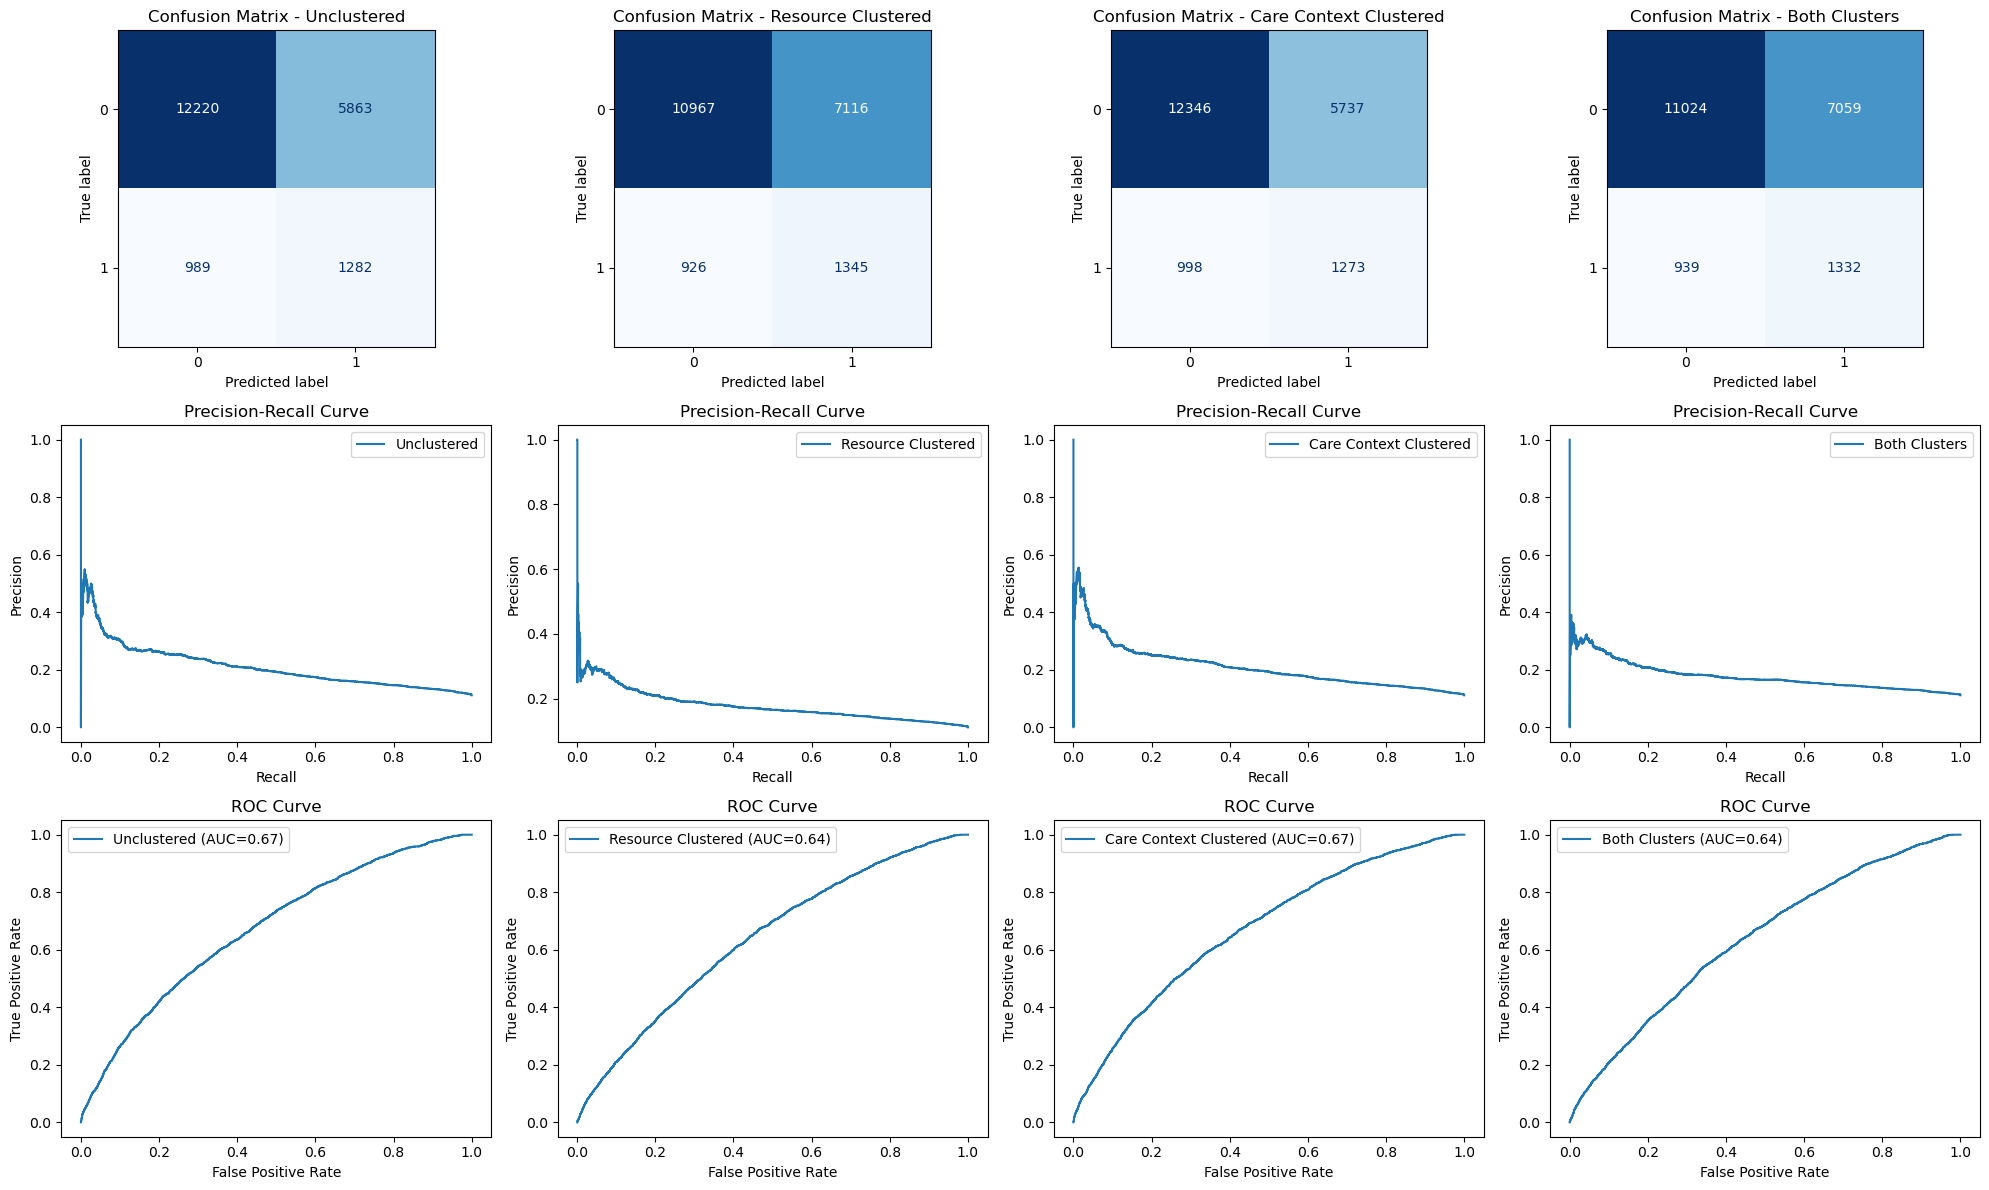

In [102]:
# Create subplots: 3 rows (CM, PR, ROC) × N columns (datasets)
n_datasets = len(results)
fig, axes = plt.subplots(nrows=3, ncols=n_datasets, figsize=(5 * n_datasets, 12))

# Wrap the entire model training & evaluation section in a warning filter context
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)

    for i, result in enumerate(results):
        dataset_name = result['Dataset']
        best_model = result['Best Model']  # You'll need to store this in your loop (see below)
        
        # Recreate test set split for consistency
        X_train, X_test, y_train, y_test = train_test_split(
            datasets[dataset_name], y_binary, test_size=0.2, stratify=y_binary, random_state=1234
        )
    
        # Predict on holdout
        y_test_pred = best_model.predict(X_test)
        y_test_prob = best_model.predict_proba(X_test)[:, 1]
    
        # 1. Confusion Matrix
        cm = mt.confusion_matrix(y_test, y_test_pred)
        cm_display = mt.ConfusionMatrixDisplay(cm)
        cm_display.plot(ax=axes[0, i], cmap="Blues", colorbar=False)
        axes[0, i].set_title(f"Confusion Matrix - {dataset_name}")
    
        # 2. Precision-Recall Curve
        precision, recall, _ = mt.precision_recall_curve(y_test, y_test_prob)
        axes[1, i].plot(recall, precision, label=f"{dataset_name}")
        axes[1, i].set_title("Precision-Recall Curve")
        axes[1, i].set_xlabel("Recall")
        axes[1, i].set_ylabel("Precision")
        axes[1, i].legend(loc="best")
    
        # 3. ROC Curve
        fpr, tpr, _ = mt.roc_curve(y_test, y_test_prob)
        roc_auc = mt.roc_auc_score(y_test, y_test_prob)
        axes[2, i].plot(fpr, tpr, label=f"{dataset_name} (AUC={roc_auc:.2f})")
        axes[2, i].set_title("ROC Curve")
        axes[2, i].set_xlabel("False Positive Rate")
        axes[2, i].set_ylabel("True Positive Rate")
        axes[2, i].legend(loc="best")
    
    plt.tight_layout()
    plt.show()

Confusion Matrices:
- All models show difficulty in reducing false positives, with a high number of negative cases (non-readmissions) incorrectly predicted as positive.
- The unclustered and care context clustered models return the most balanced performance between true positives and true negatives.
- Models that include resource clusters (either alone or combined) have higher recall, indicating more true positives, but also more false positives.

Precision-Recall and ROC Curves:
- All PR curves show steep drops in precision after the initial threshold, reflecting class imbalance and low precision.
- The unclustered and care context clustered models have nearly identical ROC curves (~0.67 AUC), suggesting similar discriminatory power.
- Models using resource clusters (alone or with care clusters) perform worse on both PR and ROC metrics.

### Deployment 

#### Clustering Patient Data for Readmission Risk

Use Case: 
- The clustering approaches here, based on resource use and care context, can help healthcare providers, insurance companies, and hospitals better segment patients according to their healthcare utilization and administrative characteristics.
- These clusters can be used to tailor interventions, improve case management, and potentially reduce readmission rates.

Model Utility:
- While the clusters didn’t lead to drastic improvements in predictive performance, the resource use clusters improved recall, making the model better at catching likely readmissions.
- The care context clusters offered a compact way to replace ~100 sparse categorical features with a single variable, simplifying downstream models while preserving accuracy.
- From a business standpoint, this tradeoff may be worthwhile if the goal is to identify high-risk groups early and allocate care more efficiently.

Deployment Strategy:
- Batch predictions (e.g. weekly or monthly updates) would likely be more practical than real-time processing in a hospital setting.
- Environment: What is the architecture of the client's environment and what integrations would be necessary?

Data Collection & Model Maintenance:
- Quarterly model retraining is recommended to deal with shifts in patient demographics, hospital policies, or treatment practices.
- Monitor for cluster drift: as healthcare delivery shifts (e.g. telehealth adoption, policy changes), the meaning of resource use or care clusters might also change.
- Consider collecting and integrating additional features such as:
  - Lab results and vitals (objective clinical data)
  - Medication adherence and behavioral health markers

Limitations & Future Directions:  
- Clustering led to modest improvements in model performance, especially for recall, but the overall impact was limited.
- Exploring other feature combinations or clustering strategies may yield better results.
- Input from clinicians and case managers will be important for making the clusters interpretable and useful in practice. Their feedback can guide improvements to both the model and its deployment.